In [1]:
!unzip celeba.zip -d /content/dataset

Archive:  celeba.zip
replace /content/dataset/celeba_hq_256/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/celeba_hq_256/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import os
import shutil
import random

# Path to the folder containing all images
all_images_path = "/content/dataset/celeba_hq_256"

# Paths for source and target folders
output_path = "/content/NewDataset"
source_path = os.path.join(output_path, "source")
target_path = os.path.join(output_path, "target")

# Create source and target directories
os.makedirs(source_path, exist_ok=True)
os.makedirs(target_path, exist_ok=True)

# Get a list of all image files
image_files = [f for f in os.listdir(all_images_path) if f.endswith(('.jpg', '.png'))]

# Shuffle the images for random splitting
random.shuffle(image_files)

# Define split ratio
split_ratio = 0.5  # 50% for source, 50% for target

# Split the images
split_index = int(len(image_files) * split_ratio)
source_files = image_files[:split_index]
target_files = image_files[split_index:]

# Move images to respective folders
for img in source_files:
    shutil.copy(os.path.join(all_images_path, img), os.path.join(source_path, img))

for img in target_files:
    shutil.copy(os.path.join(all_images_path, img), os.path.join(target_path, img))

print(f"Images successfully split into:\nSource: {source_path}\nTarget: {target_path}")
print(f"Source images: {len(source_files)}")
print(f"Target images: {len(target_files)}")


Images successfully split into:
Source: /content/NewDataset/source
Target: /content/NewDataset/target
Source images: 15000
Target images: 15000


In [7]:
!pip install sympy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FaceSwapDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.source_dir = os.path.join(dataset_dir, "source")
        self.target_dir = os.path.join(dataset_dir, "target")
        self.source_images = sorted(os.listdir(self.source_dir))
        self.target_images = sorted(os.listdir(self.target_dir))
        self.transform = transform

    def __len__(self):
        return len(self.source_images)

    def __getitem__(self, idx):
        source_path = os.path.join(self.source_dir, self.source_images[idx])
        target_path = os.path.join(self.target_dir, self.target_images[idx])

        source_image = Image.open(source_path).convert("RGB")
        target_image = Image.open(target_path).convert("RGB")

        if self.transform:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset_dir = "/content/NewDataset"
dataset = FaceSwapDataset(dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [4]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    """Residual Block with Convolutional Layers."""
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Add Residual Blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 256)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [10]:
import torch.optim as optim
from tqdm import tqdm

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
num_epochs = 15

In [7]:
# Feature Matching Loss for Generator
def feature_matching_loss(discriminator, real_input, fake_input):
    real_features = discriminator.main[:-1](real_input)  # Exclude final Sigmoid layer
    fake_features = discriminator.main[:-1](fake_input)
    return nn.MSELoss()(real_features, fake_features)

In [8]:
import torchvision.utils as vutils

In [9]:
from torch.utils.data import Subset

# Assuming `dataloader` is your DataLoader object
# Get the total size of the dataset
dataset_size = len(dataloader.dataset)

# Calculate the number of samples to use (15% of the total dataset)
subset_size = int(dataset_size)

# Create a subset of the dataset (first 15% of the data)
subset_indices = list(range(subset_size))
subset_dataset = Subset(dataloader.dataset, subset_indices)

# Create a new DataLoader for the subset
subset_dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=dataloader.batch_size, shuffle=True)




  0%|          | 1/1408 [00:02<1:04:58,  2.77s/it]

Epoch [1/15], Step [1/1408], D Loss: 1.2200, G Loss: 0.8109


  1%|          | 11/1408 [00:07<10:18,  2.26it/s]

Epoch [1/15], Step [11/1408], D Loss: 1.0911, G Loss: 0.9868


  1%|▏         | 21/1408 [00:11<10:14,  2.26it/s]

Epoch [1/15], Step [21/1408], D Loss: 1.1093, G Loss: 0.9070


  2%|▏         | 31/1408 [00:15<09:48,  2.34it/s]

Epoch [1/15], Step [31/1408], D Loss: 1.1277, G Loss: 0.8405


  3%|▎         | 41/1408 [00:19<09:41,  2.35it/s]

Epoch [1/15], Step [41/1408], D Loss: 1.1601, G Loss: 0.8115


  4%|▎         | 51/1408 [00:24<09:57,  2.27it/s]

Epoch [1/15], Step [51/1408], D Loss: 1.1330, G Loss: 0.8031


  4%|▍         | 61/1408 [00:28<09:34,  2.34it/s]

Epoch [1/15], Step [61/1408], D Loss: 1.1385, G Loss: 0.7759


  5%|▌         | 71/1408 [00:32<09:37,  2.32it/s]

Epoch [1/15], Step [71/1408], D Loss: 1.1329, G Loss: 0.8048


  6%|▌         | 81/1408 [00:37<09:46,  2.26it/s]

Epoch [1/15], Step [81/1408], D Loss: 1.1360, G Loss: 0.7641


  6%|▋         | 91/1408 [00:41<10:23,  2.11it/s]

Epoch [1/15], Step [91/1408], D Loss: 1.1235, G Loss: 0.8140


  7%|▋         | 101/1408 [00:46<09:38,  2.26it/s]

Epoch [1/15], Step [101/1408], D Loss: 1.0973, G Loss: 0.8513


  8%|▊         | 111/1408 [00:51<09:29,  2.28it/s]

Epoch [1/15], Step [111/1408], D Loss: 1.0949, G Loss: 0.9842


  9%|▊         | 121/1408 [00:55<09:32,  2.25it/s]

Epoch [1/15], Step [121/1408], D Loss: 1.0869, G Loss: 0.9648


  9%|▉         | 131/1408 [00:59<09:29,  2.24it/s]

Epoch [1/15], Step [131/1408], D Loss: 1.0621, G Loss: 1.0010


 10%|█         | 141/1408 [01:04<09:16,  2.27it/s]

Epoch [1/15], Step [141/1408], D Loss: 0.9717, G Loss: 1.3279


 11%|█         | 151/1408 [01:08<09:02,  2.32it/s]

Epoch [1/15], Step [151/1408], D Loss: 0.9854, G Loss: 1.5260


 11%|█▏        | 161/1408 [01:13<09:27,  2.20it/s]

Epoch [1/15], Step [161/1408], D Loss: 0.9459, G Loss: 1.3477


 12%|█▏        | 171/1408 [01:17<09:08,  2.26it/s]

Epoch [1/15], Step [171/1408], D Loss: 0.8966, G Loss: 2.2428


 13%|█▎        | 181/1408 [01:22<09:03,  2.26it/s]

Epoch [1/15], Step [181/1408], D Loss: 1.1069, G Loss: 2.1665


 14%|█▎        | 191/1408 [01:26<09:20,  2.17it/s]

Epoch [1/15], Step [191/1408], D Loss: 1.0031, G Loss: 1.6694


 14%|█▍        | 201/1408 [01:31<08:57,  2.24it/s]

Epoch [1/15], Step [201/1408], D Loss: 1.0894, G Loss: 3.1814


 15%|█▍        | 211/1408 [01:35<08:56,  2.23it/s]

Epoch [1/15], Step [211/1408], D Loss: 0.7382, G Loss: 2.6776


 16%|█▌        | 221/1408 [01:40<08:59,  2.20it/s]

Epoch [1/15], Step [221/1408], D Loss: 0.6922, G Loss: 3.6122


 16%|█▋        | 231/1408 [01:44<08:44,  2.24it/s]

Epoch [1/15], Step [231/1408], D Loss: 0.6897, G Loss: 3.5346


 17%|█▋        | 241/1408 [01:49<09:16,  2.10it/s]

Epoch [1/15], Step [241/1408], D Loss: 0.6381, G Loss: 4.2599


 18%|█▊        | 251/1408 [01:53<08:46,  2.20it/s]

Epoch [1/15], Step [251/1408], D Loss: 0.9080, G Loss: 3.6044


 19%|█▊        | 261/1408 [01:58<08:39,  2.21it/s]

Epoch [1/15], Step [261/1408], D Loss: 0.6620, G Loss: 4.1832


 19%|█▉        | 271/1408 [02:02<08:48,  2.15it/s]

Epoch [1/15], Step [271/1408], D Loss: 0.8537, G Loss: 4.1927


 20%|█▉        | 281/1408 [02:07<08:34,  2.19it/s]

Epoch [1/15], Step [281/1408], D Loss: 0.5904, G Loss: 6.2472


 21%|██        | 291/1408 [02:12<08:29,  2.19it/s]

Epoch [1/15], Step [291/1408], D Loss: 0.7667, G Loss: 4.8882


 21%|██▏       | 301/1408 [02:16<08:43,  2.12it/s]

Epoch [1/15], Step [301/1408], D Loss: 0.5677, G Loss: 7.3242


 22%|██▏       | 311/1408 [02:21<08:28,  2.16it/s]

Epoch [1/15], Step [311/1408], D Loss: 0.6158, G Loss: 5.5199


 23%|██▎       | 321/1408 [02:25<08:17,  2.18it/s]

Epoch [1/15], Step [321/1408], D Loss: 0.7408, G Loss: 4.2175


 24%|██▎       | 331/1408 [02:30<08:20,  2.15it/s]

Epoch [1/15], Step [331/1408], D Loss: 0.5958, G Loss: 7.1036


 24%|██▍       | 341/1408 [02:35<08:08,  2.18it/s]

Epoch [1/15], Step [341/1408], D Loss: 0.7162, G Loss: 5.5814


 25%|██▍       | 351/1408 [02:39<08:21,  2.11it/s]

Epoch [1/15], Step [351/1408], D Loss: 0.6465, G Loss: 5.4329


 26%|██▌       | 361/1408 [02:44<08:00,  2.18it/s]

Epoch [1/15], Step [361/1408], D Loss: 0.6843, G Loss: 4.2881


 26%|██▋       | 371/1408 [02:49<08:05,  2.14it/s]

Epoch [1/15], Step [371/1408], D Loss: 0.8742, G Loss: 5.0163


 27%|██▋       | 381/1408 [02:54<08:19,  2.06it/s]

Epoch [1/15], Step [381/1408], D Loss: 0.6589, G Loss: 5.2504


 28%|██▊       | 391/1408 [02:58<07:48,  2.17it/s]

Epoch [1/15], Step [391/1408], D Loss: 0.6293, G Loss: 4.9616


 28%|██▊       | 401/1408 [03:03<07:49,  2.15it/s]

Epoch [1/15], Step [401/1408], D Loss: 0.5931, G Loss: 6.4415


 29%|██▉       | 411/1408 [03:08<07:45,  2.14it/s]

Epoch [1/15], Step [411/1408], D Loss: 0.6521, G Loss: 5.7091


 30%|██▉       | 421/1408 [03:12<07:40,  2.14it/s]

Epoch [1/15], Step [421/1408], D Loss: 0.6171, G Loss: 5.8004


 31%|███       | 431/1408 [03:17<07:48,  2.08it/s]

Epoch [1/15], Step [431/1408], D Loss: 0.6204, G Loss: 5.8684


 31%|███▏      | 441/1408 [03:22<07:28,  2.15it/s]

Epoch [1/15], Step [441/1408], D Loss: 0.8540, G Loss: 7.2028


 32%|███▏      | 451/1408 [03:26<07:21,  2.17it/s]

Epoch [1/15], Step [451/1408], D Loss: 0.8837, G Loss: 3.5388


 33%|███▎      | 461/1408 [03:31<07:29,  2.11it/s]

Epoch [1/15], Step [461/1408], D Loss: 0.6988, G Loss: 5.2144


 33%|███▎      | 471/1408 [03:36<07:07,  2.19it/s]

Epoch [1/15], Step [471/1408], D Loss: 0.6000, G Loss: 6.2918


 34%|███▍      | 481/1408 [03:40<07:07,  2.17it/s]

Epoch [1/15], Step [481/1408], D Loss: 2.2255, G Loss: 5.5445


 35%|███▍      | 491/1408 [03:45<07:10,  2.13it/s]

Epoch [1/15], Step [491/1408], D Loss: 0.7891, G Loss: 3.6787


 36%|███▌      | 501/1408 [03:49<06:55,  2.18it/s]

Epoch [1/15], Step [501/1408], D Loss: 0.6371, G Loss: 5.1359


 36%|███▋      | 511/1408 [03:54<07:03,  2.12it/s]

Epoch [1/15], Step [511/1408], D Loss: 0.7533, G Loss: 4.1464


 37%|███▋      | 521/1408 [03:59<06:49,  2.17it/s]

Epoch [1/15], Step [521/1408], D Loss: 0.6831, G Loss: 5.6808


 38%|███▊      | 531/1408 [04:03<06:42,  2.18it/s]

Epoch [1/15], Step [531/1408], D Loss: 0.5820, G Loss: 6.4048


 38%|███▊      | 541/1408 [04:08<06:58,  2.07it/s]

Epoch [1/15], Step [541/1408], D Loss: 0.8880, G Loss: 5.1108


 39%|███▉      | 551/1408 [04:13<06:38,  2.15it/s]

Epoch [1/15], Step [551/1408], D Loss: 0.5832, G Loss: 7.7666


 40%|███▉      | 561/1408 [04:17<06:28,  2.18it/s]

Epoch [1/15], Step [561/1408], D Loss: 0.6207, G Loss: 6.1945


 41%|████      | 571/1408 [04:22<06:27,  2.16it/s]

Epoch [1/15], Step [571/1408], D Loss: 0.6696, G Loss: 4.7208


 41%|████▏     | 581/1408 [04:27<06:22,  2.16it/s]

Epoch [1/15], Step [581/1408], D Loss: 0.5966, G Loss: 6.7582


 42%|████▏     | 591/1408 [04:31<06:31,  2.09it/s]

Epoch [1/15], Step [591/1408], D Loss: 1.3088, G Loss: 4.6448


 43%|████▎     | 601/1408 [04:36<06:15,  2.15it/s]

Epoch [1/15], Step [601/1408], D Loss: 0.7074, G Loss: 3.8182


 43%|████▎     | 611/1408 [04:41<06:08,  2.16it/s]

Epoch [1/15], Step [611/1408], D Loss: 0.5933, G Loss: 6.2797


 44%|████▍     | 621/1408 [04:46<06:07,  2.14it/s]

Epoch [1/15], Step [621/1408], D Loss: 0.5676, G Loss: 7.4354


 45%|████▍     | 631/1408 [04:50<05:56,  2.18it/s]

Epoch [1/15], Step [631/1408], D Loss: 0.5494, G Loss: 8.1051


 46%|████▌     | 641/1408 [04:55<05:56,  2.15it/s]

Epoch [1/15], Step [641/1408], D Loss: 0.7705, G Loss: 5.9993


 46%|████▌     | 651/1408 [04:59<05:48,  2.17it/s]

Epoch [1/15], Step [651/1408], D Loss: 0.7938, G Loss: 2.8392


 47%|████▋     | 661/1408 [05:04<05:43,  2.17it/s]

Epoch [1/15], Step [661/1408], D Loss: 0.8291, G Loss: 3.7939


 48%|████▊     | 671/1408 [05:09<05:49,  2.11it/s]

Epoch [1/15], Step [671/1408], D Loss: 0.6247, G Loss: 5.1122


 48%|████▊     | 681/1408 [05:13<05:37,  2.15it/s]

Epoch [1/15], Step [681/1408], D Loss: 0.6782, G Loss: 4.6271


 49%|████▉     | 691/1408 [05:18<05:29,  2.17it/s]

Epoch [1/15], Step [691/1408], D Loss: 0.5682, G Loss: 8.5342


 50%|████▉     | 701/1408 [05:23<05:34,  2.11it/s]

Epoch [1/15], Step [701/1408], D Loss: 0.7458, G Loss: 4.9541


 50%|█████     | 711/1408 [05:27<05:21,  2.17it/s]

Epoch [1/15], Step [711/1408], D Loss: 0.8954, G Loss: 2.8101


 51%|█████     | 721/1408 [05:32<05:17,  2.17it/s]

Epoch [1/15], Step [721/1408], D Loss: 0.7533, G Loss: 3.8358


 52%|█████▏    | 731/1408 [05:37<05:16,  2.14it/s]

Epoch [1/15], Step [731/1408], D Loss: 0.7129, G Loss: 6.2394


 53%|█████▎    | 741/1408 [05:41<05:08,  2.16it/s]

Epoch [1/15], Step [741/1408], D Loss: 0.6991, G Loss: 4.5604


 53%|█████▎    | 751/1408 [05:46<05:11,  2.11it/s]

Epoch [1/15], Step [751/1408], D Loss: 1.2665, G Loss: 7.1755


 54%|█████▍    | 761/1408 [05:51<05:02,  2.14it/s]

Epoch [1/15], Step [761/1408], D Loss: 0.6475, G Loss: 4.9634


 55%|█████▍    | 771/1408 [05:55<04:53,  2.17it/s]

Epoch [1/15], Step [771/1408], D Loss: 1.1508, G Loss: 5.3407


 55%|█████▌    | 781/1408 [06:00<04:54,  2.13it/s]

Epoch [1/15], Step [781/1408], D Loss: 0.6393, G Loss: 8.1838


 56%|█████▌    | 791/1408 [06:05<04:44,  2.17it/s]

Epoch [1/15], Step [791/1408], D Loss: 0.5686, G Loss: 6.9768


 57%|█████▋    | 801/1408 [06:09<04:40,  2.16it/s]

Epoch [1/15], Step [801/1408], D Loss: 0.6042, G Loss: 7.2162


 58%|█████▊    | 811/1408 [06:14<04:36,  2.16it/s]

Epoch [1/15], Step [811/1408], D Loss: 0.6363, G Loss: 5.2882


 58%|█████▊    | 821/1408 [06:18<04:28,  2.19it/s]

Epoch [1/15], Step [821/1408], D Loss: 0.6927, G Loss: 5.0702


 59%|█████▉    | 831/1408 [06:23<04:31,  2.12it/s]

Epoch [1/15], Step [831/1408], D Loss: 0.7117, G Loss: 7.2170


 60%|█████▉    | 841/1408 [06:28<04:23,  2.15it/s]

Epoch [1/15], Step [841/1408], D Loss: 3.2568, G Loss: 2.0173


 60%|██████    | 851/1408 [06:32<04:18,  2.15it/s]

Epoch [1/15], Step [851/1408], D Loss: 0.7155, G Loss: 3.3062


 61%|██████    | 861/1408 [06:37<04:22,  2.08it/s]

Epoch [1/15], Step [861/1408], D Loss: 0.6680, G Loss: 4.4659


 62%|██████▏   | 871/1408 [06:42<04:11,  2.14it/s]

Epoch [1/15], Step [871/1408], D Loss: 0.6847, G Loss: 4.6707


 63%|██████▎   | 881/1408 [06:47<04:08,  2.12it/s]

Epoch [1/15], Step [881/1408], D Loss: 0.7666, G Loss: 5.7218


 63%|██████▎   | 891/1408 [06:51<03:59,  2.16it/s]

Epoch [1/15], Step [891/1408], D Loss: 0.6005, G Loss: 6.2474


 64%|██████▍   | 901/1408 [06:56<03:55,  2.15it/s]

Epoch [1/15], Step [901/1408], D Loss: 1.1082, G Loss: 3.4261


 65%|██████▍   | 911/1408 [07:01<03:58,  2.09it/s]

Epoch [1/15], Step [911/1408], D Loss: 0.6679, G Loss: 4.1766


 65%|██████▌   | 921/1408 [07:05<03:42,  2.19it/s]

Epoch [1/15], Step [921/1408], D Loss: 0.7096, G Loss: 4.1253


 66%|██████▌   | 931/1408 [07:10<03:43,  2.13it/s]

Epoch [1/15], Step [931/1408], D Loss: 0.6107, G Loss: 6.6435


 67%|██████▋   | 941/1408 [07:15<03:39,  2.13it/s]

Epoch [1/15], Step [941/1408], D Loss: 0.6708, G Loss: 5.2183


 68%|██████▊   | 951/1408 [07:19<03:30,  2.17it/s]

Epoch [1/15], Step [951/1408], D Loss: 0.7478, G Loss: 6.5109


 68%|██████▊   | 961/1408 [07:24<03:25,  2.17it/s]

Epoch [1/15], Step [961/1408], D Loss: 0.6090, G Loss: 5.7526


 69%|██████▉   | 971/1408 [07:29<03:22,  2.16it/s]

Epoch [1/15], Step [971/1408], D Loss: 0.6109, G Loss: 6.1176


 70%|██████▉   | 981/1408 [07:33<03:18,  2.15it/s]

Epoch [1/15], Step [981/1408], D Loss: 0.5795, G Loss: 9.2164


 70%|███████   | 991/1408 [07:38<03:18,  2.10it/s]

Epoch [1/15], Step [991/1408], D Loss: 0.5489, G Loss: 8.4247


 71%|███████   | 1001/1408 [07:43<03:13,  2.11it/s]

Epoch [1/15], Step [1001/1408], D Loss: 0.6733, G Loss: 8.5899


 72%|███████▏  | 1011/1408 [07:47<03:04,  2.15it/s]

Epoch [1/15], Step [1011/1408], D Loss: 1.3129, G Loss: 3.6475


 73%|███████▎  | 1021/1408 [07:52<03:01,  2.13it/s]

Epoch [1/15], Step [1021/1408], D Loss: 0.6115, G Loss: 5.3667


 73%|███████▎  | 1031/1408 [07:57<02:54,  2.17it/s]

Epoch [1/15], Step [1031/1408], D Loss: 1.0559, G Loss: 6.3309


 74%|███████▍  | 1041/1408 [08:01<02:48,  2.17it/s]

Epoch [1/15], Step [1041/1408], D Loss: 0.6291, G Loss: 5.8979


 75%|███████▍  | 1051/1408 [08:06<02:45,  2.15it/s]

Epoch [1/15], Step [1051/1408], D Loss: 0.8027, G Loss: 6.0298


 75%|███████▌  | 1061/1408 [08:11<02:41,  2.15it/s]

Epoch [1/15], Step [1061/1408], D Loss: 0.6679, G Loss: 6.7529


 76%|███████▌  | 1071/1408 [08:15<02:41,  2.08it/s]

Epoch [1/15], Step [1071/1408], D Loss: 0.5941, G Loss: 8.6861


 77%|███████▋  | 1081/1408 [08:20<02:31,  2.17it/s]

Epoch [1/15], Step [1081/1408], D Loss: 1.7331, G Loss: 3.5100


 77%|███████▋  | 1091/1408 [08:24<02:26,  2.17it/s]

Epoch [1/15], Step [1091/1408], D Loss: 0.9970, G Loss: 2.3390


 78%|███████▊  | 1101/1408 [08:29<02:21,  2.17it/s]

Epoch [1/15], Step [1101/1408], D Loss: 0.6560, G Loss: 4.3060


 79%|███████▉  | 1111/1408 [08:34<02:16,  2.18it/s]

Epoch [1/15], Step [1111/1408], D Loss: 0.6031, G Loss: 6.0445


 80%|███████▉  | 1121/1408 [08:38<02:13,  2.16it/s]

Epoch [1/15], Step [1121/1408], D Loss: 0.7144, G Loss: 6.0360


 80%|████████  | 1131/1408 [08:43<02:10,  2.13it/s]

Epoch [1/15], Step [1131/1408], D Loss: 0.7076, G Loss: 4.7647


 81%|████████  | 1141/1408 [08:48<02:02,  2.17it/s]

Epoch [1/15], Step [1141/1408], D Loss: 0.5882, G Loss: 6.5092


 82%|████████▏ | 1151/1408 [08:52<02:01,  2.12it/s]

Epoch [1/15], Step [1151/1408], D Loss: 0.6547, G Loss: 4.8783


 82%|████████▏ | 1161/1408 [08:57<01:53,  2.17it/s]

Epoch [1/15], Step [1161/1408], D Loss: 0.6358, G Loss: 6.0367


 83%|████████▎ | 1171/1408 [09:02<01:50,  2.14it/s]

Epoch [1/15], Step [1171/1408], D Loss: 0.6699, G Loss: 7.5410


 84%|████████▍ | 1181/1408 [09:07<01:48,  2.10it/s]

Epoch [1/15], Step [1181/1408], D Loss: 1.1617, G Loss: 4.3875


 85%|████████▍ | 1191/1408 [09:11<01:41,  2.15it/s]

Epoch [1/15], Step [1191/1408], D Loss: 0.5968, G Loss: 7.6503


 85%|████████▌ | 1201/1408 [09:16<01:36,  2.15it/s]

Epoch [1/15], Step [1201/1408], D Loss: 0.8957, G Loss: 4.6874


 86%|████████▌ | 1211/1408 [09:21<01:32,  2.12it/s]

Epoch [1/15], Step [1211/1408], D Loss: 0.8377, G Loss: 4.0376


 87%|████████▋ | 1221/1408 [09:25<01:26,  2.16it/s]

Epoch [1/15], Step [1221/1408], D Loss: 0.7545, G Loss: 4.7660


 87%|████████▋ | 1231/1408 [09:30<01:25,  2.08it/s]

Epoch [1/15], Step [1231/1408], D Loss: 0.6562, G Loss: 5.3793


 88%|████████▊ | 1241/1408 [09:35<01:18,  2.14it/s]

Epoch [1/15], Step [1241/1408], D Loss: 0.6827, G Loss: 4.8669


 89%|████████▉ | 1251/1408 [09:39<01:13,  2.15it/s]

Epoch [1/15], Step [1251/1408], D Loss: 0.8927, G Loss: 4.1857


 90%|████████▉ | 1261/1408 [09:44<01:08,  2.14it/s]

Epoch [1/15], Step [1261/1408], D Loss: 0.6408, G Loss: 5.5604


 90%|█████████ | 1271/1408 [09:49<01:03,  2.16it/s]

Epoch [1/15], Step [1271/1408], D Loss: 0.6647, G Loss: 5.2493


 91%|█████████ | 1281/1408 [09:53<01:00,  2.11it/s]

Epoch [1/15], Step [1281/1408], D Loss: 0.5968, G Loss: 6.2814


 92%|█████████▏| 1291/1408 [09:58<00:54,  2.13it/s]

Epoch [1/15], Step [1291/1408], D Loss: 0.6142, G Loss: 5.5840


 92%|█████████▏| 1301/1408 [10:03<00:49,  2.17it/s]

Epoch [1/15], Step [1301/1408], D Loss: 0.8521, G Loss: 4.1711


 93%|█████████▎| 1311/1408 [10:07<00:46,  2.07it/s]

Epoch [1/15], Step [1311/1408], D Loss: 0.6843, G Loss: 7.3062


 94%|█████████▍| 1321/1408 [10:12<00:40,  2.16it/s]

Epoch [1/15], Step [1321/1408], D Loss: 0.6532, G Loss: 4.6460


 95%|█████████▍| 1331/1408 [10:17<00:35,  2.15it/s]

Epoch [1/15], Step [1331/1408], D Loss: 0.5561, G Loss: 10.1946


 95%|█████████▌| 1341/1408 [10:21<00:31,  2.12it/s]

Epoch [1/15], Step [1341/1408], D Loss: 0.6013, G Loss: 6.0139


 96%|█████████▌| 1351/1408 [10:26<00:26,  2.16it/s]

Epoch [1/15], Step [1351/1408], D Loss: 0.5808, G Loss: 7.4231


 97%|█████████▋| 1361/1408 [10:31<00:21,  2.14it/s]

Epoch [1/15], Step [1361/1408], D Loss: 0.6695, G Loss: 9.4072


 97%|█████████▋| 1371/1408 [10:35<00:17,  2.17it/s]

Epoch [1/15], Step [1371/1408], D Loss: 0.5270, G Loss: 10.0338


 98%|█████████▊| 1381/1408 [10:40<00:12,  2.18it/s]

Epoch [1/15], Step [1381/1408], D Loss: 0.7216, G Loss: 10.0751


 99%|█████████▉| 1391/1408 [10:45<00:08,  2.09it/s]

Epoch [1/15], Step [1391/1408], D Loss: 1.6847, G Loss: 2.2399


100%|█████████▉| 1401/1408 [10:49<00:03,  2.14it/s]

Epoch [1/15], Step [1401/1408], D Loss: 0.6808, G Loss: 4.1074


100%|██████████| 1408/1408 [10:53<00:00,  2.16it/s]


Generator Loss improved to 4.9927.


  0%|          | 1/1408 [00:00<10:49,  2.17it/s]

Epoch [2/15], Step [1/1408], D Loss: 0.6544, G Loss: 4.4732


  1%|          | 11/1408 [00:05<11:20,  2.05it/s]

Epoch [2/15], Step [11/1408], D Loss: 0.6445, G Loss: 4.9224


  1%|▏         | 21/1408 [00:09<10:47,  2.14it/s]

Epoch [2/15], Step [21/1408], D Loss: 0.6878, G Loss: 6.5863


  2%|▏         | 31/1408 [00:14<10:41,  2.15it/s]

Epoch [2/15], Step [31/1408], D Loss: 0.6142, G Loss: 5.3437


  3%|▎         | 41/1408 [00:19<10:54,  2.09it/s]

Epoch [2/15], Step [41/1408], D Loss: 0.6739, G Loss: 6.3506


  4%|▎         | 51/1408 [00:24<10:27,  2.16it/s]

Epoch [2/15], Step [51/1408], D Loss: 0.6535, G Loss: 5.0636


  4%|▍         | 61/1408 [00:28<10:53,  2.06it/s]

Epoch [2/15], Step [61/1408], D Loss: 0.6699, G Loss: 5.0926


  5%|▌         | 71/1408 [00:33<10:19,  2.16it/s]

Epoch [2/15], Step [71/1408], D Loss: 0.6636, G Loss: 5.5923


  6%|▌         | 81/1408 [00:38<10:16,  2.15it/s]

Epoch [2/15], Step [81/1408], D Loss: 0.5914, G Loss: 7.1182


  6%|▋         | 91/1408 [00:42<10:34,  2.08it/s]

Epoch [2/15], Step [91/1408], D Loss: 0.7252, G Loss: 4.2934


  7%|▋         | 101/1408 [00:47<10:05,  2.16it/s]

Epoch [2/15], Step [101/1408], D Loss: 0.6813, G Loss: 4.9108


  8%|▊         | 111/1408 [00:52<10:00,  2.16it/s]

Epoch [2/15], Step [111/1408], D Loss: 0.6379, G Loss: 6.4551


  9%|▊         | 121/1408 [00:56<09:56,  2.16it/s]

Epoch [2/15], Step [121/1408], D Loss: 0.6366, G Loss: 5.7976


  9%|▉         | 131/1408 [01:01<09:46,  2.18it/s]

Epoch [2/15], Step [131/1408], D Loss: 0.6007, G Loss: 8.2345


 10%|█         | 141/1408 [01:06<10:04,  2.10it/s]

Epoch [2/15], Step [141/1408], D Loss: 1.3277, G Loss: 4.4108


 11%|█         | 151/1408 [01:10<09:40,  2.16it/s]

Epoch [2/15], Step [151/1408], D Loss: 0.6111, G Loss: 6.6666


 11%|█▏        | 161/1408 [01:15<09:33,  2.17it/s]

Epoch [2/15], Step [161/1408], D Loss: 0.5711, G Loss: 7.3933


 12%|█▏        | 171/1408 [01:20<09:49,  2.10it/s]

Epoch [2/15], Step [171/1408], D Loss: 0.6444, G Loss: 4.6590


 13%|█▎        | 181/1408 [01:24<09:26,  2.17it/s]

Epoch [2/15], Step [181/1408], D Loss: 0.5937, G Loss: 6.3654


 14%|█▎        | 191/1408 [01:29<09:17,  2.18it/s]

Epoch [2/15], Step [191/1408], D Loss: 0.7422, G Loss: 5.3218


 14%|█▍        | 201/1408 [01:34<09:21,  2.15it/s]

Epoch [2/15], Step [201/1408], D Loss: 0.5799, G Loss: 6.8742


 15%|█▍        | 211/1408 [01:38<09:05,  2.19it/s]

Epoch [2/15], Step [211/1408], D Loss: 0.7822, G Loss: 4.5510


 16%|█▌        | 221/1408 [01:43<09:12,  2.15it/s]

Epoch [2/15], Step [221/1408], D Loss: 0.6591, G Loss: 6.1889


 16%|█▋        | 231/1408 [01:47<09:03,  2.16it/s]

Epoch [2/15], Step [231/1408], D Loss: 0.6924, G Loss: 5.9142


 17%|█▋        | 241/1408 [01:52<08:52,  2.19it/s]

Epoch [2/15], Step [241/1408], D Loss: 0.7170, G Loss: 4.4282


 18%|█▊        | 251/1408 [01:57<09:04,  2.12it/s]

Epoch [2/15], Step [251/1408], D Loss: 0.8913, G Loss: 4.3908


 19%|█▊        | 261/1408 [02:01<08:47,  2.17it/s]

Epoch [2/15], Step [261/1408], D Loss: 0.7115, G Loss: 4.9615


 19%|█▉        | 271/1408 [02:06<08:41,  2.18it/s]

Epoch [2/15], Step [271/1408], D Loss: 0.6254, G Loss: 8.0728


 20%|█▉        | 281/1408 [02:11<08:49,  2.13it/s]

Epoch [2/15], Step [281/1408], D Loss: 0.5737, G Loss: 7.5639


 21%|██        | 291/1408 [02:15<08:35,  2.17it/s]

Epoch [2/15], Step [291/1408], D Loss: 0.6296, G Loss: 5.6912


 21%|██▏       | 301/1408 [02:20<08:39,  2.13it/s]

Epoch [2/15], Step [301/1408], D Loss: 0.5857, G Loss: 8.7948


 22%|██▏       | 311/1408 [02:25<08:35,  2.13it/s]

Epoch [2/15], Step [311/1408], D Loss: 0.7455, G Loss: 6.8732


 23%|██▎       | 321/1408 [02:29<08:19,  2.18it/s]

Epoch [2/15], Step [321/1408], D Loss: 6.7761, G Loss: 1.2335


 24%|██▎       | 331/1408 [02:34<08:37,  2.08it/s]

Epoch [2/15], Step [331/1408], D Loss: 0.9744, G Loss: 2.5739


 24%|██▍       | 341/1408 [02:39<08:07,  2.19it/s]

Epoch [2/15], Step [341/1408], D Loss: 0.7130, G Loss: 3.5313


 25%|██▍       | 351/1408 [02:43<08:07,  2.17it/s]

Epoch [2/15], Step [351/1408], D Loss: 0.6695, G Loss: 4.1141


 26%|██▌       | 361/1408 [02:48<08:07,  2.15it/s]

Epoch [2/15], Step [361/1408], D Loss: 0.7341, G Loss: 4.2568


 26%|██▋       | 371/1408 [02:52<08:00,  2.16it/s]

Epoch [2/15], Step [371/1408], D Loss: 0.7090, G Loss: 4.4469


 27%|██▋       | 381/1408 [02:57<08:08,  2.10it/s]

Epoch [2/15], Step [381/1408], D Loss: 2.0007, G Loss: 4.7739


 28%|██▊       | 391/1408 [03:02<07:54,  2.14it/s]

Epoch [2/15], Step [391/1408], D Loss: 0.7692, G Loss: 3.1591


 28%|██▊       | 401/1408 [03:06<07:41,  2.18it/s]

Epoch [2/15], Step [401/1408], D Loss: 0.8713, G Loss: 2.8262


 29%|██▉       | 411/1408 [03:11<07:54,  2.10it/s]

Epoch [2/15], Step [411/1408], D Loss: 0.6555, G Loss: 4.4200


 30%|██▉       | 421/1408 [03:16<07:36,  2.16it/s]

Epoch [2/15], Step [421/1408], D Loss: 0.6879, G Loss: 3.9461


 31%|███       | 431/1408 [03:20<07:26,  2.19it/s]

Epoch [2/15], Step [431/1408], D Loss: 0.6632, G Loss: 4.8851


 31%|███▏      | 441/1408 [03:25<07:28,  2.16it/s]

Epoch [2/15], Step [441/1408], D Loss: 0.7118, G Loss: 3.5896


 32%|███▏      | 451/1408 [03:30<07:25,  2.15it/s]

Epoch [2/15], Step [451/1408], D Loss: 0.6605, G Loss: 4.5229


 33%|███▎      | 461/1408 [03:34<07:26,  2.12it/s]

Epoch [2/15], Step [461/1408], D Loss: 0.7029, G Loss: 3.3411


 33%|███▎      | 471/1408 [03:39<07:12,  2.17it/s]

Epoch [2/15], Step [471/1408], D Loss: 0.6624, G Loss: 4.6190


 34%|███▍      | 481/1408 [03:44<07:16,  2.12it/s]

Epoch [2/15], Step [481/1408], D Loss: 0.6766, G Loss: 4.3576


 35%|███▍      | 491/1408 [03:48<07:21,  2.08it/s]

Epoch [2/15], Step [491/1408], D Loss: 0.6730, G Loss: 5.6339


 36%|███▌      | 501/1408 [03:53<06:59,  2.16it/s]

Epoch [2/15], Step [501/1408], D Loss: 0.9935, G Loss: 3.1359


 36%|███▋      | 511/1408 [03:58<06:50,  2.19it/s]

Epoch [2/15], Step [511/1408], D Loss: 0.6454, G Loss: 4.6117


 37%|███▋      | 521/1408 [04:02<06:53,  2.14it/s]

Epoch [2/15], Step [521/1408], D Loss: 0.6162, G Loss: 5.3735


 38%|███▊      | 531/1408 [04:07<06:42,  2.18it/s]

Epoch [2/15], Step [531/1408], D Loss: 2.3585, G Loss: 5.0005


 38%|███▊      | 541/1408 [04:12<06:53,  2.09it/s]

Epoch [2/15], Step [541/1408], D Loss: 0.8149, G Loss: 2.9294


 39%|███▉      | 551/1408 [04:16<06:35,  2.17it/s]

Epoch [2/15], Step [551/1408], D Loss: 0.6725, G Loss: 4.7284


 40%|███▉      | 561/1408 [04:21<06:26,  2.19it/s]

Epoch [2/15], Step [561/1408], D Loss: 0.7606, G Loss: 3.6259


 41%|████      | 571/1408 [04:26<06:35,  2.11it/s]

Epoch [2/15], Step [571/1408], D Loss: 0.7425, G Loss: 4.9265


 41%|████▏     | 581/1408 [04:30<06:23,  2.16it/s]

Epoch [2/15], Step [581/1408], D Loss: 0.6610, G Loss: 4.9606


 42%|████▏     | 591/1408 [04:35<06:15,  2.18it/s]

Epoch [2/15], Step [591/1408], D Loss: 0.6918, G Loss: 6.0061


 43%|████▎     | 601/1408 [04:40<06:15,  2.15it/s]

Epoch [2/15], Step [601/1408], D Loss: 0.6150, G Loss: 5.6540


 43%|████▎     | 611/1408 [04:44<06:09,  2.16it/s]

Epoch [2/15], Step [611/1408], D Loss: 0.6575, G Loss: 4.4481


 44%|████▍     | 621/1408 [04:49<06:07,  2.14it/s]

Epoch [2/15], Step [621/1408], D Loss: 0.6869, G Loss: 4.5705


 45%|████▍     | 631/1408 [04:53<05:59,  2.16it/s]

Epoch [2/15], Step [631/1408], D Loss: 0.7050, G Loss: 4.7974


 46%|████▌     | 641/1408 [04:58<05:50,  2.19it/s]

Epoch [2/15], Step [641/1408], D Loss: 0.7062, G Loss: 3.2794


 46%|████▌     | 651/1408 [05:03<05:54,  2.14it/s]

Epoch [2/15], Step [651/1408], D Loss: 0.8203, G Loss: 5.5897


 47%|████▋     | 661/1408 [05:07<05:42,  2.18it/s]

Epoch [2/15], Step [661/1408], D Loss: 0.8471, G Loss: 8.7280


 48%|████▊     | 671/1408 [05:12<05:36,  2.19it/s]

Epoch [2/15], Step [671/1408], D Loss: 0.9049, G Loss: 6.7773


 48%|████▊     | 681/1408 [05:16<05:40,  2.13it/s]

Epoch [2/15], Step [681/1408], D Loss: 0.7998, G Loss: 3.2364


 49%|████▉     | 691/1408 [05:21<05:30,  2.17it/s]

Epoch [2/15], Step [691/1408], D Loss: 0.6918, G Loss: 4.6670


 50%|████▉     | 701/1408 [05:26<05:25,  2.17it/s]

Epoch [2/15], Step [701/1408], D Loss: 0.6991, G Loss: 3.6696


 50%|█████     | 711/1408 [05:30<05:25,  2.14it/s]

Epoch [2/15], Step [711/1408], D Loss: 0.5840, G Loss: 6.3228


 51%|█████     | 721/1408 [05:35<05:18,  2.16it/s]

Epoch [2/15], Step [721/1408], D Loss: 0.7049, G Loss: 4.4790


 52%|█████▏    | 731/1408 [05:40<05:18,  2.13it/s]

Epoch [2/15], Step [731/1408], D Loss: 0.6271, G Loss: 5.1357


 53%|█████▎    | 741/1408 [05:44<05:09,  2.15it/s]

Epoch [2/15], Step [741/1408], D Loss: 0.6673, G Loss: 5.5605


 53%|█████▎    | 751/1408 [05:49<05:00,  2.19it/s]

Epoch [2/15], Step [751/1408], D Loss: 0.9848, G Loss: 5.8980


 54%|█████▍    | 761/1408 [05:54<05:06,  2.11it/s]

Epoch [2/15], Step [761/1408], D Loss: 0.6037, G Loss: 5.7884


 55%|█████▍    | 771/1408 [05:58<04:53,  2.17it/s]

Epoch [2/15], Step [771/1408], D Loss: 0.6060, G Loss: 5.7452


 55%|█████▌    | 781/1408 [06:03<04:46,  2.19it/s]

Epoch [2/15], Step [781/1408], D Loss: 0.8541, G Loss: 8.2706


 56%|█████▌    | 791/1408 [06:08<04:47,  2.15it/s]

Epoch [2/15], Step [791/1408], D Loss: 0.6292, G Loss: 5.8508


 57%|█████▋    | 801/1408 [06:12<04:42,  2.15it/s]

Epoch [2/15], Step [801/1408], D Loss: 0.5971, G Loss: 7.3610


 58%|█████▊    | 811/1408 [06:17<04:36,  2.16it/s]

Epoch [2/15], Step [811/1408], D Loss: 1.4081, G Loss: 2.0576


 58%|█████▊    | 821/1408 [06:21<04:30,  2.17it/s]

Epoch [2/15], Step [821/1408], D Loss: 0.7269, G Loss: 4.0217


 59%|█████▉    | 831/1408 [06:26<04:23,  2.19it/s]

Epoch [2/15], Step [831/1408], D Loss: 0.6763, G Loss: 3.8186


 60%|█████▉    | 841/1408 [06:31<04:29,  2.11it/s]

Epoch [2/15], Step [841/1408], D Loss: 0.6594, G Loss: 4.8525


 60%|██████    | 851/1408 [06:35<04:16,  2.17it/s]

Epoch [2/15], Step [851/1408], D Loss: 0.7265, G Loss: 3.3505


 61%|██████    | 861/1408 [06:40<04:12,  2.17it/s]

Epoch [2/15], Step [861/1408], D Loss: 0.6860, G Loss: 4.7119


 62%|██████▏   | 871/1408 [06:45<04:12,  2.13it/s]

Epoch [2/15], Step [871/1408], D Loss: 0.6631, G Loss: 4.3751


 63%|██████▎   | 881/1408 [06:49<04:04,  2.15it/s]

Epoch [2/15], Step [881/1408], D Loss: 0.6315, G Loss: 6.0891


 63%|██████▎   | 891/1408 [06:54<04:02,  2.14it/s]

Epoch [2/15], Step [891/1408], D Loss: 1.2681, G Loss: 5.8240


 64%|██████▍   | 901/1408 [06:59<03:53,  2.18it/s]

Epoch [2/15], Step [901/1408], D Loss: 0.6497, G Loss: 4.6093


 65%|██████▍   | 911/1408 [07:03<03:50,  2.16it/s]

Epoch [2/15], Step [911/1408], D Loss: 0.6362, G Loss: 5.4850


 65%|██████▌   | 921/1408 [07:08<03:57,  2.05it/s]

Epoch [2/15], Step [921/1408], D Loss: 0.6487, G Loss: 5.1578


 66%|██████▌   | 931/1408 [07:13<03:40,  2.16it/s]

Epoch [2/15], Step [931/1408], D Loss: 0.7072, G Loss: 4.1016


 67%|██████▋   | 941/1408 [07:17<03:35,  2.17it/s]

Epoch [2/15], Step [941/1408], D Loss: 0.6667, G Loss: 4.4339


 68%|██████▊   | 951/1408 [07:22<03:34,  2.13it/s]

Epoch [2/15], Step [951/1408], D Loss: 0.6535, G Loss: 5.1651


 68%|██████▊   | 961/1408 [07:27<03:26,  2.16it/s]

Epoch [2/15], Step [961/1408], D Loss: 0.5940, G Loss: 6.0812


 69%|██████▉   | 971/1408 [07:31<03:24,  2.14it/s]

Epoch [2/15], Step [971/1408], D Loss: 0.7750, G Loss: 3.2816


 70%|██████▉   | 981/1408 [07:36<03:19,  2.14it/s]

Epoch [2/15], Step [981/1408], D Loss: 0.6020, G Loss: 5.6018


 70%|███████   | 991/1408 [07:41<03:13,  2.16it/s]

Epoch [2/15], Step [991/1408], D Loss: 0.6068, G Loss: 5.4448


 71%|███████   | 1001/1408 [07:45<03:13,  2.10it/s]

Epoch [2/15], Step [1001/1408], D Loss: 0.6347, G Loss: 5.2258


 72%|███████▏  | 1011/1408 [07:50<03:02,  2.17it/s]

Epoch [2/15], Step [1011/1408], D Loss: 0.6693, G Loss: 5.5214


 73%|███████▎  | 1021/1408 [07:55<02:58,  2.16it/s]

Epoch [2/15], Step [1021/1408], D Loss: 0.5117, G Loss: 14.5189


 73%|███████▎  | 1031/1408 [07:59<02:56,  2.14it/s]

Epoch [2/15], Step [1031/1408], D Loss: 0.5458, G Loss: 9.0416


 74%|███████▍  | 1041/1408 [08:04<02:50,  2.15it/s]

Epoch [2/15], Step [1041/1408], D Loss: 0.5942, G Loss: 6.2281


 75%|███████▍  | 1051/1408 [08:09<02:45,  2.15it/s]

Epoch [2/15], Step [1051/1408], D Loss: 1.6346, G Loss: 1.8169


 75%|███████▌  | 1061/1408 [08:13<02:39,  2.18it/s]

Epoch [2/15], Step [1061/1408], D Loss: 0.9715, G Loss: 2.4239


 76%|███████▌  | 1071/1408 [08:18<02:33,  2.19it/s]

Epoch [2/15], Step [1071/1408], D Loss: 0.6632, G Loss: 4.8689


 77%|███████▋  | 1081/1408 [08:23<02:39,  2.05it/s]

Epoch [2/15], Step [1081/1408], D Loss: 0.7240, G Loss: 5.2386


 77%|███████▋  | 1091/1408 [08:27<02:25,  2.18it/s]

Epoch [2/15], Step [1091/1408], D Loss: 0.6317, G Loss: 5.5244


 78%|███████▊  | 1101/1408 [08:32<02:22,  2.15it/s]

Epoch [2/15], Step [1101/1408], D Loss: 0.7072, G Loss: 3.9823


 79%|███████▉  | 1111/1408 [08:37<02:19,  2.13it/s]

Epoch [2/15], Step [1111/1408], D Loss: 0.7356, G Loss: 4.9417


 80%|███████▉  | 1121/1408 [08:41<02:11,  2.18it/s]

Epoch [2/15], Step [1121/1408], D Loss: 0.6839, G Loss: 3.8748


 80%|████████  | 1131/1408 [08:46<02:07,  2.18it/s]

Epoch [2/15], Step [1131/1408], D Loss: 0.6059, G Loss: 5.4378


 81%|████████  | 1141/1408 [08:51<02:04,  2.14it/s]

Epoch [2/15], Step [1141/1408], D Loss: 0.6167, G Loss: 5.1437


 82%|████████▏ | 1151/1408 [08:55<01:58,  2.17it/s]

Epoch [2/15], Step [1151/1408], D Loss: 0.6429, G Loss: 5.3361


 82%|████████▏ | 1161/1408 [09:00<01:57,  2.10it/s]

Epoch [2/15], Step [1161/1408], D Loss: 0.8028, G Loss: 4.0251


 83%|████████▎ | 1171/1408 [09:04<01:49,  2.17it/s]

Epoch [2/15], Step [1171/1408], D Loss: 0.6564, G Loss: 5.1110


 84%|████████▍ | 1181/1408 [09:09<01:45,  2.15it/s]

Epoch [2/15], Step [1181/1408], D Loss: 0.6145, G Loss: 5.6218


 85%|████████▍ | 1191/1408 [09:14<01:42,  2.11it/s]

Epoch [2/15], Step [1191/1408], D Loss: 0.7732, G Loss: 5.5109


 85%|████████▌ | 1201/1408 [09:18<01:36,  2.14it/s]

Epoch [2/15], Step [1201/1408], D Loss: 0.9115, G Loss: 4.0428


 86%|████████▌ | 1211/1408 [09:23<01:32,  2.14it/s]

Epoch [2/15], Step [1211/1408], D Loss: 0.6353, G Loss: 6.6780


 87%|████████▋ | 1221/1408 [09:28<01:27,  2.15it/s]

Epoch [2/15], Step [1221/1408], D Loss: 0.6373, G Loss: 5.2037


 87%|████████▋ | 1231/1408 [09:32<01:21,  2.17it/s]

Epoch [2/15], Step [1231/1408], D Loss: 0.6867, G Loss: 4.3460


 88%|████████▊ | 1241/1408 [09:37<01:18,  2.12it/s]

Epoch [2/15], Step [1241/1408], D Loss: 0.5984, G Loss: 6.3002


 89%|████████▉ | 1251/1408 [09:42<01:12,  2.16it/s]

Epoch [2/15], Step [1251/1408], D Loss: 5.3416, G Loss: 2.7290


 90%|████████▉ | 1261/1408 [09:46<01:07,  2.19it/s]

Epoch [2/15], Step [1261/1408], D Loss: 1.0343, G Loss: 1.9539


 90%|█████████ | 1271/1408 [09:51<01:04,  2.11it/s]

Epoch [2/15], Step [1271/1408], D Loss: 0.9592, G Loss: 3.0527


 91%|█████████ | 1281/1408 [09:56<00:58,  2.16it/s]

Epoch [2/15], Step [1281/1408], D Loss: 0.7948, G Loss: 2.9234


 92%|█████████▏| 1291/1408 [10:00<00:53,  2.17it/s]

Epoch [2/15], Step [1291/1408], D Loss: 0.6673, G Loss: 4.2685


 92%|█████████▏| 1301/1408 [10:05<00:50,  2.14it/s]

Epoch [2/15], Step [1301/1408], D Loss: 0.6900, G Loss: 4.0460


 93%|█████████▎| 1311/1408 [10:10<00:45,  2.15it/s]

Epoch [2/15], Step [1311/1408], D Loss: 0.8131, G Loss: 3.8757


 94%|█████████▍| 1321/1408 [10:14<00:41,  2.12it/s]

Epoch [2/15], Step [1321/1408], D Loss: 0.6848, G Loss: 4.1940


 95%|█████████▍| 1331/1408 [10:19<00:35,  2.15it/s]

Epoch [2/15], Step [1331/1408], D Loss: 1.2192, G Loss: 5.1807


 95%|█████████▌| 1341/1408 [10:24<00:30,  2.18it/s]

Epoch [2/15], Step [1341/1408], D Loss: 0.6700, G Loss: 4.2259


 96%|█████████▌| 1351/1408 [10:28<00:26,  2.13it/s]

Epoch [2/15], Step [1351/1408], D Loss: 0.8791, G Loss: 5.0333


 97%|█████████▋| 1361/1408 [10:33<00:21,  2.16it/s]

Epoch [2/15], Step [1361/1408], D Loss: 0.6868, G Loss: 4.8539


 97%|█████████▋| 1371/1408 [10:38<00:17,  2.16it/s]

Epoch [2/15], Step [1371/1408], D Loss: 0.7241, G Loss: 3.7782


 98%|█████████▊| 1381/1408 [10:42<00:12,  2.12it/s]

Epoch [2/15], Step [1381/1408], D Loss: 0.6988, G Loss: 4.3141


 99%|█████████▉| 1391/1408 [10:47<00:07,  2.16it/s]

Epoch [2/15], Step [1391/1408], D Loss: 0.6965, G Loss: 4.8388


100%|█████████▉| 1401/1408 [10:51<00:03,  2.14it/s]

Epoch [2/15], Step [1401/1408], D Loss: 0.6391, G Loss: 4.4961


100%|██████████| 1408/1408 [10:55<00:00,  2.15it/s]


No improvement in Generator Loss for 1 epoch(s).


  0%|          | 1/1408 [00:00<10:53,  2.15it/s]

Epoch [3/15], Step [1/1408], D Loss: 0.6838, G Loss: 6.3697


  1%|          | 11/1408 [00:05<10:43,  2.17it/s]

Epoch [3/15], Step [11/1408], D Loss: 2.3317, G Loss: 4.8233


  1%|▏         | 21/1408 [00:09<11:09,  2.07it/s]

Epoch [3/15], Step [21/1408], D Loss: 0.7693, G Loss: 3.4488


  2%|▏         | 31/1408 [00:14<10:30,  2.19it/s]

Epoch [3/15], Step [31/1408], D Loss: 0.6931, G Loss: 3.9498


  3%|▎         | 41/1408 [00:19<10:36,  2.15it/s]

Epoch [3/15], Step [41/1408], D Loss: 0.6559, G Loss: 4.4465


  4%|▎         | 51/1408 [00:23<10:28,  2.16it/s]

Epoch [3/15], Step [51/1408], D Loss: 0.6812, G Loss: 5.5556


  4%|▍         | 61/1408 [00:28<10:26,  2.15it/s]

Epoch [3/15], Step [61/1408], D Loss: 0.6528, G Loss: 4.7393


  5%|▌         | 71/1408 [00:32<10:28,  2.13it/s]

Epoch [3/15], Step [71/1408], D Loss: 0.7117, G Loss: 3.5591


  6%|▌         | 81/1408 [00:37<10:14,  2.16it/s]

Epoch [3/15], Step [81/1408], D Loss: 0.6858, G Loss: 4.4935


  6%|▋         | 91/1408 [00:42<10:02,  2.18it/s]

Epoch [3/15], Step [91/1408], D Loss: 0.6997, G Loss: 4.0510


  7%|▋         | 101/1408 [00:47<10:36,  2.05it/s]

Epoch [3/15], Step [101/1408], D Loss: 0.7094, G Loss: 3.4923


  8%|▊         | 111/1408 [00:51<09:56,  2.17it/s]

Epoch [3/15], Step [111/1408], D Loss: 0.6587, G Loss: 4.7516


  9%|▊         | 121/1408 [00:56<09:51,  2.18it/s]

Epoch [3/15], Step [121/1408], D Loss: 0.7096, G Loss: 3.8451


  9%|▉         | 131/1408 [01:00<09:57,  2.14it/s]

Epoch [3/15], Step [131/1408], D Loss: 0.6699, G Loss: 5.1378


 10%|█         | 141/1408 [01:05<09:54,  2.13it/s]

Epoch [3/15], Step [141/1408], D Loss: 0.5915, G Loss: 8.2565


 11%|█         | 151/1408 [01:10<09:44,  2.15it/s]

Epoch [3/15], Step [151/1408], D Loss: 0.6307, G Loss: 6.8336


 11%|█▏        | 161/1408 [01:14<09:36,  2.16it/s]

Epoch [3/15], Step [161/1408], D Loss: 10.2582, G Loss: 6.3354


 12%|█▏        | 171/1408 [01:19<09:26,  2.18it/s]

Epoch [3/15], Step [171/1408], D Loss: 1.1203, G Loss: 1.0138


 13%|█▎        | 181/1408 [01:24<09:42,  2.11it/s]

Epoch [3/15], Step [181/1408], D Loss: 1.1806, G Loss: 1.6567


 14%|█▎        | 191/1408 [01:28<09:19,  2.18it/s]

Epoch [3/15], Step [191/1408], D Loss: 0.7526, G Loss: 3.4243


 14%|█▍        | 201/1408 [01:33<09:20,  2.16it/s]

Epoch [3/15], Step [201/1408], D Loss: 0.6686, G Loss: 5.1508


 15%|█▍        | 211/1408 [01:38<09:16,  2.15it/s]

Epoch [3/15], Step [211/1408], D Loss: 0.7143, G Loss: 3.4745


 16%|█▌        | 221/1408 [01:42<09:07,  2.17it/s]

Epoch [3/15], Step [221/1408], D Loss: 0.6496, G Loss: 4.8756


 16%|█▋        | 231/1408 [01:47<08:59,  2.18it/s]

Epoch [3/15], Step [231/1408], D Loss: 0.7204, G Loss: 4.4354


 17%|█▋        | 241/1408 [01:52<09:03,  2.15it/s]

Epoch [3/15], Step [241/1408], D Loss: 0.9482, G Loss: 3.1630


 18%|█▊        | 251/1408 [01:56<08:51,  2.18it/s]

Epoch [3/15], Step [251/1408], D Loss: 0.8258, G Loss: 3.3431


 19%|█▊        | 261/1408 [02:01<08:57,  2.13it/s]

Epoch [3/15], Step [261/1408], D Loss: 0.6724, G Loss: 4.1455


 19%|█▉        | 271/1408 [02:05<08:41,  2.18it/s]

Epoch [3/15], Step [271/1408], D Loss: 0.7149, G Loss: 4.2281


 20%|█▉        | 281/1408 [02:10<08:39,  2.17it/s]

Epoch [3/15], Step [281/1408], D Loss: 0.7338, G Loss: 4.1162


 21%|██        | 291/1408 [02:15<08:56,  2.08it/s]

Epoch [3/15], Step [291/1408], D Loss: 0.6393, G Loss: 4.7775


 21%|██▏       | 301/1408 [02:19<08:28,  2.18it/s]

Epoch [3/15], Step [301/1408], D Loss: 0.7078, G Loss: 4.1447


 22%|██▏       | 311/1408 [02:24<08:23,  2.18it/s]

Epoch [3/15], Step [311/1408], D Loss: 0.7487, G Loss: 4.2868


 23%|██▎       | 321/1408 [02:29<08:20,  2.17it/s]

Epoch [3/15], Step [321/1408], D Loss: 0.6059, G Loss: 5.8178


 24%|██▎       | 331/1408 [02:33<08:11,  2.19it/s]

Epoch [3/15], Step [331/1408], D Loss: 0.8386, G Loss: 3.4312


 24%|██▍       | 341/1408 [02:38<08:22,  2.12it/s]

Epoch [3/15], Step [341/1408], D Loss: 0.6728, G Loss: 4.5114


 25%|██▍       | 351/1408 [02:43<08:10,  2.16it/s]

Epoch [3/15], Step [351/1408], D Loss: 0.6457, G Loss: 4.9687


 26%|██▌       | 361/1408 [02:47<08:05,  2.16it/s]

Epoch [3/15], Step [361/1408], D Loss: 0.6519, G Loss: 6.3851


 26%|██▋       | 371/1408 [02:52<08:17,  2.09it/s]

Epoch [3/15], Step [371/1408], D Loss: 0.6074, G Loss: 5.5148


 27%|██▋       | 381/1408 [02:57<07:53,  2.17it/s]

Epoch [3/15], Step [381/1408], D Loss: 0.9078, G Loss: 3.3104


 28%|██▊       | 391/1408 [03:01<07:50,  2.16it/s]

Epoch [3/15], Step [391/1408], D Loss: 0.6773, G Loss: 5.1614


 28%|██▊       | 401/1408 [03:06<07:46,  2.16it/s]

Epoch [3/15], Step [401/1408], D Loss: 0.6985, G Loss: 6.6719


 29%|██▉       | 411/1408 [03:10<07:39,  2.17it/s]

Epoch [3/15], Step [411/1408], D Loss: 1.2757, G Loss: 5.5061


 30%|██▉       | 421/1408 [03:15<07:46,  2.11it/s]

Epoch [3/15], Step [421/1408], D Loss: 0.7249, G Loss: 4.6855


 31%|███       | 431/1408 [03:20<07:37,  2.13it/s]

Epoch [3/15], Step [431/1408], D Loss: 1.1042, G Loss: 6.1297


 31%|███▏      | 441/1408 [03:25<07:27,  2.16it/s]

Epoch [3/15], Step [441/1408], D Loss: 0.6976, G Loss: 4.2119


 32%|███▏      | 451/1408 [03:29<07:37,  2.09it/s]

Epoch [3/15], Step [451/1408], D Loss: 0.6167, G Loss: 5.9382


 33%|███▎      | 461/1408 [03:34<07:16,  2.17it/s]

Epoch [3/15], Step [461/1408], D Loss: 0.7475, G Loss: 5.1903


 33%|███▎      | 471/1408 [03:38<07:09,  2.18it/s]

Epoch [3/15], Step [471/1408], D Loss: 0.8269, G Loss: 8.6156


 34%|███▍      | 481/1408 [03:43<07:10,  2.15it/s]

Epoch [3/15], Step [481/1408], D Loss: 0.6764, G Loss: 4.3377


 35%|███▍      | 491/1408 [03:48<07:05,  2.15it/s]

Epoch [3/15], Step [491/1408], D Loss: 0.6990, G Loss: 6.8376


 36%|███▌      | 501/1408 [03:52<07:06,  2.13it/s]

Epoch [3/15], Step [501/1408], D Loss: 1.6623, G Loss: 1.0105


 36%|███▋      | 511/1408 [03:57<07:01,  2.13it/s]

Epoch [3/15], Step [511/1408], D Loss: 1.2084, G Loss: 1.1260


 37%|███▋      | 521/1408 [04:02<06:50,  2.16it/s]

Epoch [3/15], Step [521/1408], D Loss: 1.3069, G Loss: 1.9591


 38%|███▊      | 531/1408 [04:07<07:09,  2.04it/s]

Epoch [3/15], Step [531/1408], D Loss: 0.7222, G Loss: 3.4797


 38%|███▊      | 541/1408 [04:11<06:41,  2.16it/s]

Epoch [3/15], Step [541/1408], D Loss: 0.6782, G Loss: 5.3453


 39%|███▉      | 551/1408 [04:16<06:33,  2.18it/s]

Epoch [3/15], Step [551/1408], D Loss: 0.7025, G Loss: 4.1826


 40%|███▉      | 561/1408 [04:21<06:35,  2.14it/s]

Epoch [3/15], Step [561/1408], D Loss: 0.7811, G Loss: 3.6080


 41%|████      | 571/1408 [04:25<06:26,  2.16it/s]

Epoch [3/15], Step [571/1408], D Loss: 0.6691, G Loss: 4.0183


 41%|████▏     | 581/1408 [04:30<06:35,  2.09it/s]

Epoch [3/15], Step [581/1408], D Loss: 0.6410, G Loss: 4.8625


 42%|████▏     | 591/1408 [04:35<06:16,  2.17it/s]

Epoch [3/15], Step [591/1408], D Loss: 0.6295, G Loss: 5.3577


 43%|████▎     | 601/1408 [04:39<06:11,  2.17it/s]

Epoch [3/15], Step [601/1408], D Loss: 0.9476, G Loss: 4.8503


 43%|████▎     | 611/1408 [04:44<06:19,  2.10it/s]

Epoch [3/15], Step [611/1408], D Loss: 0.6993, G Loss: 3.6637


 44%|████▍     | 621/1408 [04:48<06:03,  2.17it/s]

Epoch [3/15], Step [621/1408], D Loss: 0.6156, G Loss: 5.8313


 45%|████▍     | 631/1408 [04:53<05:57,  2.17it/s]

Epoch [3/15], Step [631/1408], D Loss: 1.0749, G Loss: 4.0751


 46%|████▌     | 641/1408 [04:58<06:00,  2.13it/s]

Epoch [3/15], Step [641/1408], D Loss: 0.6756, G Loss: 4.5070


 46%|████▌     | 651/1408 [05:02<05:50,  2.16it/s]

Epoch [3/15], Step [651/1408], D Loss: 0.7412, G Loss: 4.7158


 47%|████▋     | 661/1408 [05:07<05:56,  2.09it/s]

Epoch [3/15], Step [661/1408], D Loss: 0.6409, G Loss: 4.7914


 48%|████▊     | 671/1408 [05:12<05:42,  2.15it/s]

Epoch [3/15], Step [671/1408], D Loss: 0.6501, G Loss: 6.6894


 48%|████▊     | 681/1408 [05:17<05:37,  2.15it/s]

Epoch [3/15], Step [681/1408], D Loss: 0.6851, G Loss: 4.0884


 49%|████▉     | 691/1408 [05:21<05:39,  2.11it/s]

Epoch [3/15], Step [691/1408], D Loss: 0.7738, G Loss: 4.6401


 50%|████▉     | 701/1408 [05:26<05:28,  2.15it/s]

Epoch [3/15], Step [701/1408], D Loss: 0.8992, G Loss: 4.6778


 50%|█████     | 711/1408 [05:30<05:21,  2.17it/s]

Epoch [3/15], Step [711/1408], D Loss: 0.6509, G Loss: 6.2869


 51%|█████     | 721/1408 [05:35<05:18,  2.16it/s]

Epoch [3/15], Step [721/1408], D Loss: 0.7632, G Loss: 5.1483


 52%|█████▏    | 731/1408 [05:40<05:15,  2.15it/s]

Epoch [3/15], Step [731/1408], D Loss: 1.0360, G Loss: 4.0167


 53%|█████▎    | 741/1408 [05:44<05:09,  2.16it/s]

Epoch [3/15], Step [741/1408], D Loss: 0.6342, G Loss: 5.6432


 53%|█████▎    | 751/1408 [05:49<05:04,  2.15it/s]

Epoch [3/15], Step [751/1408], D Loss: 0.6261, G Loss: 5.5692


 54%|█████▍    | 761/1408 [05:54<04:58,  2.17it/s]

Epoch [3/15], Step [761/1408], D Loss: 0.7165, G Loss: 3.9228


 55%|█████▍    | 771/1408 [05:59<05:11,  2.04it/s]

Epoch [3/15], Step [771/1408], D Loss: 0.6673, G Loss: 6.2598


 55%|█████▌    | 781/1408 [06:03<04:47,  2.18it/s]

Epoch [3/15], Step [781/1408], D Loss: 1.2415, G Loss: 5.5852


 56%|█████▌    | 791/1408 [06:08<04:46,  2.15it/s]

Epoch [3/15], Step [791/1408], D Loss: 1.1634, G Loss: 1.0282


 57%|█████▋    | 801/1408 [06:12<04:49,  2.10it/s]

Epoch [3/15], Step [801/1408], D Loss: 1.1402, G Loss: 2.2702


 58%|█████▊    | 811/1408 [06:17<04:35,  2.16it/s]

Epoch [3/15], Step [811/1408], D Loss: 1.0163, G Loss: 2.0108


 58%|█████▊    | 821/1408 [06:22<04:33,  2.15it/s]

Epoch [3/15], Step [821/1408], D Loss: 0.6940, G Loss: 3.6766


 59%|█████▉    | 831/1408 [06:27<04:30,  2.14it/s]

Epoch [3/15], Step [831/1408], D Loss: 0.7668, G Loss: 3.3225


 60%|█████▉    | 841/1408 [06:31<04:20,  2.18it/s]

Epoch [3/15], Step [841/1408], D Loss: 0.7180, G Loss: 3.3387


 60%|██████    | 851/1408 [06:36<04:24,  2.11it/s]

Epoch [3/15], Step [851/1408], D Loss: 0.7713, G Loss: 3.3484


 61%|██████    | 861/1408 [06:40<04:12,  2.17it/s]

Epoch [3/15], Step [861/1408], D Loss: 0.6609, G Loss: 4.8912


 62%|██████▏   | 871/1408 [06:45<04:07,  2.17it/s]

Epoch [3/15], Step [871/1408], D Loss: 0.7523, G Loss: 4.8049


 63%|██████▎   | 881/1408 [06:50<04:13,  2.08it/s]

Epoch [3/15], Step [881/1408], D Loss: 0.6498, G Loss: 4.7873


 63%|██████▎   | 891/1408 [06:54<03:58,  2.17it/s]

Epoch [3/15], Step [891/1408], D Loss: 0.6913, G Loss: 4.2961


 64%|██████▍   | 901/1408 [06:59<03:52,  2.18it/s]

Epoch [3/15], Step [901/1408], D Loss: 0.6828, G Loss: 4.1937


 65%|██████▍   | 911/1408 [07:04<03:52,  2.14it/s]

Epoch [3/15], Step [911/1408], D Loss: 0.6526, G Loss: 5.8681


 65%|██████▌   | 921/1408 [07:08<03:49,  2.12it/s]

Epoch [3/15], Step [921/1408], D Loss: 1.1807, G Loss: 0.8263


 66%|██████▌   | 931/1408 [07:13<03:49,  2.08it/s]

Epoch [3/15], Step [931/1408], D Loss: 1.1546, G Loss: 0.7384


 67%|██████▋   | 941/1408 [07:18<03:35,  2.17it/s]

Epoch [3/15], Step [941/1408], D Loss: 1.1657, G Loss: 0.7773


 68%|██████▊   | 951/1408 [07:23<03:31,  2.16it/s]

Epoch [3/15], Step [951/1408], D Loss: 1.1395, G Loss: 0.8259


 68%|██████▊   | 961/1408 [07:27<03:29,  2.13it/s]

Epoch [3/15], Step [961/1408], D Loss: 1.1710, G Loss: 0.7730


 69%|██████▉   | 971/1408 [07:32<03:22,  2.16it/s]

Epoch [3/15], Step [971/1408], D Loss: 1.1897, G Loss: 0.7538


 70%|██████▉   | 981/1408 [07:36<03:17,  2.17it/s]

Epoch [3/15], Step [981/1408], D Loss: 1.1395, G Loss: 0.7834


 70%|███████   | 991/1408 [07:41<03:14,  2.14it/s]

Epoch [3/15], Step [991/1408], D Loss: 1.1353, G Loss: 0.8233


 71%|███████   | 1001/1408 [07:46<03:08,  2.16it/s]

Epoch [3/15], Step [1001/1408], D Loss: 1.1595, G Loss: 0.8329


 72%|███████▏  | 1011/1408 [07:50<03:09,  2.10it/s]

Epoch [3/15], Step [1011/1408], D Loss: 1.1082, G Loss: 0.8825


 73%|███████▎  | 1021/1408 [07:55<02:59,  2.16it/s]

Epoch [3/15], Step [1021/1408], D Loss: 1.1057, G Loss: 0.9917


 73%|███████▎  | 1031/1408 [08:00<02:54,  2.15it/s]

Epoch [3/15], Step [1031/1408], D Loss: 1.1092, G Loss: 0.8995


 74%|███████▍  | 1041/1408 [08:05<02:59,  2.05it/s]

Epoch [3/15], Step [1041/1408], D Loss: 1.1659, G Loss: 0.8126


 75%|███████▍  | 1051/1408 [08:09<02:44,  2.17it/s]

Epoch [3/15], Step [1051/1408], D Loss: 1.1054, G Loss: 0.8751


 75%|███████▌  | 1061/1408 [08:14<02:40,  2.17it/s]

Epoch [3/15], Step [1061/1408], D Loss: 1.0926, G Loss: 0.9583


 76%|███████▌  | 1071/1408 [08:18<02:36,  2.15it/s]

Epoch [3/15], Step [1071/1408], D Loss: 1.1742, G Loss: 1.6990


 77%|███████▋  | 1081/1408 [08:23<02:30,  2.17it/s]

Epoch [3/15], Step [1081/1408], D Loss: 1.1080, G Loss: 0.8257


 77%|███████▋  | 1091/1408 [08:28<02:29,  2.12it/s]

Epoch [3/15], Step [1091/1408], D Loss: 1.0218, G Loss: 1.1089


 78%|███████▊  | 1101/1408 [08:32<02:24,  2.13it/s]

Epoch [3/15], Step [1101/1408], D Loss: 1.0155, G Loss: 1.1716


 79%|███████▉  | 1111/1408 [08:37<02:16,  2.18it/s]

Epoch [3/15], Step [1111/1408], D Loss: 1.0698, G Loss: 0.9620


 80%|███████▉  | 1121/1408 [08:42<02:17,  2.08it/s]

Epoch [3/15], Step [1121/1408], D Loss: 1.0659, G Loss: 1.0320


 80%|████████  | 1131/1408 [08:46<02:07,  2.18it/s]

Epoch [3/15], Step [1131/1408], D Loss: 1.0188, G Loss: 1.9839


 81%|████████  | 1141/1408 [08:51<02:02,  2.18it/s]

Epoch [3/15], Step [1141/1408], D Loss: 1.1638, G Loss: 0.7368


 82%|████████▏ | 1151/1408 [08:56<01:59,  2.15it/s]

Epoch [3/15], Step [1151/1408], D Loss: 1.1039, G Loss: 0.9159


 82%|████████▏ | 1161/1408 [09:00<01:54,  2.15it/s]

Epoch [3/15], Step [1161/1408], D Loss: 1.1255, G Loss: 0.7604


 83%|████████▎ | 1171/1408 [09:05<01:50,  2.15it/s]

Epoch [3/15], Step [1171/1408], D Loss: 1.2338, G Loss: 2.3862


 84%|████████▍ | 1181/1408 [09:10<01:45,  2.15it/s]

Epoch [3/15], Step [1181/1408], D Loss: 0.9493, G Loss: 1.9682


 85%|████████▍ | 1191/1408 [09:14<01:41,  2.15it/s]

Epoch [3/15], Step [1191/1408], D Loss: 1.0073, G Loss: 2.2675


 85%|████████▌ | 1201/1408 [09:19<01:39,  2.08it/s]

Epoch [3/15], Step [1201/1408], D Loss: 0.7746, G Loss: 3.0533


 86%|████████▌ | 1211/1408 [09:24<01:30,  2.18it/s]

Epoch [3/15], Step [1211/1408], D Loss: 0.7435, G Loss: 3.8301


 87%|████████▋ | 1221/1408 [09:28<01:26,  2.15it/s]

Epoch [3/15], Step [1221/1408], D Loss: 0.8597, G Loss: 3.7516


 87%|████████▋ | 1231/1408 [09:33<01:23,  2.11it/s]

Epoch [3/15], Step [1231/1408], D Loss: 0.7443, G Loss: 3.3328


 88%|████████▊ | 1241/1408 [09:38<01:17,  2.15it/s]

Epoch [3/15], Step [1241/1408], D Loss: 0.6666, G Loss: 4.5289


 89%|████████▉ | 1251/1408 [09:42<01:12,  2.16it/s]

Epoch [3/15], Step [1251/1408], D Loss: 1.0044, G Loss: 5.1427


 90%|████████▉ | 1261/1408 [09:47<01:07,  2.16it/s]

Epoch [3/15], Step [1261/1408], D Loss: 0.7177, G Loss: 5.0649


 90%|█████████ | 1271/1408 [09:52<01:02,  2.18it/s]

Epoch [3/15], Step [1271/1408], D Loss: 0.7681, G Loss: 3.6831


 91%|█████████ | 1281/1408 [09:56<01:00,  2.10it/s]

Epoch [3/15], Step [1281/1408], D Loss: 0.7483, G Loss: 3.7124


 92%|█████████▏| 1291/1408 [10:01<00:54,  2.14it/s]

Epoch [3/15], Step [1291/1408], D Loss: 0.6429, G Loss: 4.8219


 92%|█████████▏| 1301/1408 [10:06<00:49,  2.17it/s]

Epoch [3/15], Step [1301/1408], D Loss: 0.8382, G Loss: 4.2513


 93%|█████████▎| 1311/1408 [10:10<00:45,  2.14it/s]

Epoch [3/15], Step [1311/1408], D Loss: 0.6582, G Loss: 4.5984


 94%|█████████▍| 1321/1408 [10:15<00:39,  2.18it/s]

Epoch [3/15], Step [1321/1408], D Loss: 0.7639, G Loss: 3.3685


 95%|█████████▍| 1331/1408 [10:20<00:36,  2.10it/s]

Epoch [3/15], Step [1331/1408], D Loss: 0.6424, G Loss: 4.7386


 95%|█████████▌| 1341/1408 [10:24<00:31,  2.14it/s]

Epoch [3/15], Step [1341/1408], D Loss: 0.7782, G Loss: 3.5586


 96%|█████████▌| 1351/1408 [10:29<00:26,  2.16it/s]

Epoch [3/15], Step [1351/1408], D Loss: 0.8301, G Loss: 3.3783


 97%|█████████▋| 1361/1408 [10:34<00:22,  2.06it/s]

Epoch [3/15], Step [1361/1408], D Loss: 0.6800, G Loss: 4.9909


 97%|█████████▋| 1371/1408 [10:38<00:17,  2.17it/s]

Epoch [3/15], Step [1371/1408], D Loss: 0.6757, G Loss: 4.9148


 98%|█████████▊| 1381/1408 [10:43<00:12,  2.18it/s]

Epoch [3/15], Step [1381/1408], D Loss: 0.8795, G Loss: 4.0797


 99%|█████████▉| 1391/1408 [10:48<00:07,  2.15it/s]

Epoch [3/15], Step [1391/1408], D Loss: 0.6760, G Loss: 4.4649


100%|█████████▉| 1401/1408 [10:52<00:03,  2.17it/s]

Epoch [3/15], Step [1401/1408], D Loss: 0.7574, G Loss: 4.3893


100%|██████████| 1408/1408 [10:55<00:00,  2.15it/s]


Generator Loss improved to 3.7453.


  0%|          | 1/1408 [00:00<10:46,  2.17it/s]

Epoch [4/15], Step [1/1408], D Loss: 0.6762, G Loss: 4.6215


  1%|          | 11/1408 [00:05<10:53,  2.14it/s]

Epoch [4/15], Step [11/1408], D Loss: 0.6121, G Loss: 5.8526


  1%|▏         | 21/1408 [00:09<10:41,  2.16it/s]

Epoch [4/15], Step [21/1408], D Loss: 9.3505, G Loss: 8.4801


  2%|▏         | 31/1408 [00:14<10:59,  2.09it/s]

Epoch [4/15], Step [31/1408], D Loss: 1.1996, G Loss: 0.6734


  3%|▎         | 41/1408 [00:19<10:31,  2.17it/s]

Epoch [4/15], Step [41/1408], D Loss: 1.1907, G Loss: 0.7886


  4%|▎         | 51/1408 [00:23<10:26,  2.17it/s]

Epoch [4/15], Step [51/1408], D Loss: 1.1262, G Loss: 0.8010


  4%|▍         | 61/1408 [00:28<10:45,  2.09it/s]

Epoch [4/15], Step [61/1408], D Loss: 1.1598, G Loss: 0.8733


  5%|▌         | 71/1408 [00:33<10:13,  2.18it/s]

Epoch [4/15], Step [71/1408], D Loss: 1.1872, G Loss: 1.7970


  6%|▌         | 81/1408 [00:37<10:18,  2.15it/s]

Epoch [4/15], Step [81/1408], D Loss: 1.3616, G Loss: 1.3203


  6%|▋         | 91/1408 [00:42<10:11,  2.15it/s]

Epoch [4/15], Step [91/1408], D Loss: 0.9126, G Loss: 3.4135


  7%|▋         | 101/1408 [00:47<10:04,  2.16it/s]

Epoch [4/15], Step [101/1408], D Loss: 0.8092, G Loss: 2.6961


  8%|▊         | 111/1408 [00:51<10:14,  2.11it/s]

Epoch [4/15], Step [111/1408], D Loss: 0.7773, G Loss: 2.8667


  9%|▊         | 121/1408 [00:56<09:54,  2.17it/s]

Epoch [4/15], Step [121/1408], D Loss: 0.7096, G Loss: 4.3733


  9%|▉         | 131/1408 [01:01<09:51,  2.16it/s]

Epoch [4/15], Step [131/1408], D Loss: 0.6972, G Loss: 3.6645


 10%|█         | 141/1408 [01:05<10:02,  2.10it/s]

Epoch [4/15], Step [141/1408], D Loss: 0.6769, G Loss: 4.2560


 11%|█         | 151/1408 [01:10<09:42,  2.16it/s]

Epoch [4/15], Step [151/1408], D Loss: 0.6688, G Loss: 4.2529


 11%|█▏        | 161/1408 [01:15<09:42,  2.14it/s]

Epoch [4/15], Step [161/1408], D Loss: 0.6866, G Loss: 3.9150


 12%|█▏        | 171/1408 [01:19<09:41,  2.13it/s]

Epoch [4/15], Step [171/1408], D Loss: 0.6731, G Loss: 4.3779


 13%|█▎        | 181/1408 [01:24<09:29,  2.15it/s]

Epoch [4/15], Step [181/1408], D Loss: 0.6876, G Loss: 4.9234


 14%|█▎        | 191/1408 [01:29<09:35,  2.11it/s]

Epoch [4/15], Step [191/1408], D Loss: 0.6838, G Loss: 4.1023


 14%|█▍        | 201/1408 [01:33<09:22,  2.14it/s]

Epoch [4/15], Step [201/1408], D Loss: 0.6768, G Loss: 4.1849


 15%|█▍        | 211/1408 [01:38<09:13,  2.16it/s]

Epoch [4/15], Step [211/1408], D Loss: 0.7211, G Loss: 3.9469


 16%|█▌        | 221/1408 [01:43<09:35,  2.06it/s]

Epoch [4/15], Step [221/1408], D Loss: 0.6179, G Loss: 5.4438


 16%|█▋        | 231/1408 [01:47<09:03,  2.17it/s]

Epoch [4/15], Step [231/1408], D Loss: 0.9464, G Loss: 2.0100


 17%|█▋        | 241/1408 [01:52<09:03,  2.15it/s]

Epoch [4/15], Step [241/1408], D Loss: 1.5250, G Loss: 0.9893


 18%|█▊        | 251/1408 [01:57<09:08,  2.11it/s]

Epoch [4/15], Step [251/1408], D Loss: 1.1603, G Loss: 0.7779


 19%|█▊        | 261/1408 [02:02<08:49,  2.17it/s]

Epoch [4/15], Step [261/1408], D Loss: 1.1703, G Loss: 0.7661


 19%|█▉        | 271/1408 [02:06<08:55,  2.13it/s]

Epoch [4/15], Step [271/1408], D Loss: 1.1949, G Loss: 0.8064


 20%|█▉        | 281/1408 [02:11<08:48,  2.13it/s]

Epoch [4/15], Step [281/1408], D Loss: 1.1445, G Loss: 0.8971


 21%|██        | 291/1408 [02:16<08:36,  2.16it/s]

Epoch [4/15], Step [291/1408], D Loss: 0.8863, G Loss: 2.4254


 21%|██▏       | 301/1408 [02:20<08:51,  2.08it/s]

Epoch [4/15], Step [301/1408], D Loss: 0.7537, G Loss: 3.1531


 22%|██▏       | 311/1408 [02:25<08:31,  2.15it/s]

Epoch [4/15], Step [311/1408], D Loss: 0.7133, G Loss: 3.5028


 23%|██▎       | 321/1408 [02:30<08:21,  2.17it/s]

Epoch [4/15], Step [321/1408], D Loss: 0.7062, G Loss: 3.8724


 24%|██▎       | 331/1408 [02:34<08:24,  2.14it/s]

Epoch [4/15], Step [331/1408], D Loss: 0.7078, G Loss: 3.5839


 24%|██▍       | 341/1408 [02:39<08:13,  2.16it/s]

Epoch [4/15], Step [341/1408], D Loss: 0.7894, G Loss: 3.1007


 25%|██▍       | 351/1408 [02:44<08:22,  2.10it/s]

Epoch [4/15], Step [351/1408], D Loss: 0.7221, G Loss: 3.1783


 26%|██▌       | 361/1408 [02:48<08:08,  2.14it/s]

Epoch [4/15], Step [361/1408], D Loss: 0.8626, G Loss: 4.1926


 26%|██▋       | 371/1408 [02:53<07:59,  2.16it/s]

Epoch [4/15], Step [371/1408], D Loss: 0.7530, G Loss: 3.8906


 27%|██▋       | 381/1408 [02:58<08:11,  2.09it/s]

Epoch [4/15], Step [381/1408], D Loss: 0.6363, G Loss: 5.2447


 28%|██▊       | 391/1408 [03:02<07:51,  2.16it/s]

Epoch [4/15], Step [391/1408], D Loss: 0.7026, G Loss: 3.4967


 28%|██▊       | 401/1408 [03:07<07:45,  2.16it/s]

Epoch [4/15], Step [401/1408], D Loss: 0.6983, G Loss: 4.6912


 29%|██▉       | 411/1408 [03:12<07:55,  2.10it/s]

Epoch [4/15], Step [411/1408], D Loss: 0.7125, G Loss: 3.7139


 30%|██▉       | 421/1408 [03:16<07:37,  2.16it/s]

Epoch [4/15], Step [421/1408], D Loss: 0.6822, G Loss: 4.1520


 31%|███       | 431/1408 [03:21<07:41,  2.12it/s]

Epoch [4/15], Step [431/1408], D Loss: 0.7610, G Loss: 4.0744


 31%|███▏      | 441/1408 [03:26<07:27,  2.16it/s]

Epoch [4/15], Step [441/1408], D Loss: 1.5322, G Loss: 2.3126


 32%|███▏      | 451/1408 [03:30<07:24,  2.15it/s]

Epoch [4/15], Step [451/1408], D Loss: 1.2326, G Loss: 2.2823


 33%|███▎      | 461/1408 [03:35<07:28,  2.11it/s]

Epoch [4/15], Step [461/1408], D Loss: 0.7099, G Loss: 3.4006


 33%|███▎      | 471/1408 [03:40<07:11,  2.17it/s]

Epoch [4/15], Step [471/1408], D Loss: 0.6696, G Loss: 4.2344


 34%|███▍      | 481/1408 [03:44<07:17,  2.12it/s]

Epoch [4/15], Step [481/1408], D Loss: 0.6327, G Loss: 5.6733


 35%|███▍      | 491/1408 [03:49<07:14,  2.11it/s]

Epoch [4/15], Step [491/1408], D Loss: 0.7547, G Loss: 3.0075


 36%|███▌      | 501/1408 [03:54<06:56,  2.18it/s]

Epoch [4/15], Step [501/1408], D Loss: 0.8551, G Loss: 3.2526


 36%|███▋      | 511/1408 [03:58<06:54,  2.16it/s]

Epoch [4/15], Step [511/1408], D Loss: 0.7019, G Loss: 3.8047


 37%|███▋      | 521/1408 [04:03<06:57,  2.12it/s]

Epoch [4/15], Step [521/1408], D Loss: 0.7328, G Loss: 3.8694


 38%|███▊      | 531/1408 [04:08<06:44,  2.17it/s]

Epoch [4/15], Step [531/1408], D Loss: 0.6779, G Loss: 4.2025


 38%|███▊      | 541/1408 [04:12<06:53,  2.10it/s]

Epoch [4/15], Step [541/1408], D Loss: 0.6294, G Loss: 5.0829


 39%|███▉      | 551/1408 [04:17<06:44,  2.12it/s]

Epoch [4/15], Step [551/1408], D Loss: 0.7591, G Loss: 3.4894


 40%|███▉      | 561/1408 [04:22<06:29,  2.17it/s]

Epoch [4/15], Step [561/1408], D Loss: 0.6959, G Loss: 4.0414


 41%|████      | 571/1408 [04:26<06:33,  2.12it/s]

Epoch [4/15], Step [571/1408], D Loss: 0.7545, G Loss: 4.3717


 41%|████▏     | 581/1408 [04:31<06:19,  2.18it/s]

Epoch [4/15], Step [581/1408], D Loss: 0.6922, G Loss: 3.5845


 42%|████▏     | 591/1408 [04:36<06:19,  2.15it/s]

Epoch [4/15], Step [591/1408], D Loss: 2.8686, G Loss: 1.4144


 43%|████▎     | 601/1408 [04:40<06:12,  2.17it/s]

Epoch [4/15], Step [601/1408], D Loss: 1.1656, G Loss: 0.9247


 43%|████▎     | 611/1408 [04:45<06:09,  2.16it/s]

Epoch [4/15], Step [611/1408], D Loss: 1.2206, G Loss: 0.7882


 44%|████▍     | 621/1408 [04:50<06:16,  2.09it/s]

Epoch [4/15], Step [621/1408], D Loss: 1.1894, G Loss: 0.8128


 45%|████▍     | 631/1408 [04:54<06:02,  2.15it/s]

Epoch [4/15], Step [631/1408], D Loss: 0.8815, G Loss: 2.1612


 46%|████▌     | 641/1408 [04:59<05:52,  2.18it/s]

Epoch [4/15], Step [641/1408], D Loss: 0.8180, G Loss: 2.8321


 46%|████▌     | 651/1408 [05:04<05:55,  2.13it/s]

Epoch [4/15], Step [651/1408], D Loss: 0.7667, G Loss: 3.3493


 47%|████▋     | 661/1408 [05:08<05:43,  2.17it/s]

Epoch [4/15], Step [661/1408], D Loss: 0.7460, G Loss: 2.8878


 48%|████▊     | 671/1408 [05:13<05:40,  2.17it/s]

Epoch [4/15], Step [671/1408], D Loss: 0.7326, G Loss: 3.1163


 48%|████▊     | 681/1408 [05:18<05:35,  2.17it/s]

Epoch [4/15], Step [681/1408], D Loss: 0.6741, G Loss: 3.9378


 49%|████▉     | 691/1408 [05:22<05:30,  2.17it/s]

Epoch [4/15], Step [691/1408], D Loss: 0.7326, G Loss: 3.0620


 50%|████▉     | 701/1408 [05:27<05:39,  2.08it/s]

Epoch [4/15], Step [701/1408], D Loss: 0.6891, G Loss: 3.8870


 50%|█████     | 711/1408 [05:32<05:27,  2.13it/s]

Epoch [4/15], Step [711/1408], D Loss: 0.7818, G Loss: 4.2090


 51%|█████     | 721/1408 [05:36<05:15,  2.18it/s]

Epoch [4/15], Step [721/1408], D Loss: 0.7046, G Loss: 3.8012


 52%|█████▏    | 731/1408 [05:41<05:17,  2.13it/s]

Epoch [4/15], Step [731/1408], D Loss: 0.9441, G Loss: 1.8529


 53%|█████▎    | 741/1408 [05:46<05:12,  2.13it/s]

Epoch [4/15], Step [741/1408], D Loss: 0.8738, G Loss: 3.0568


 53%|█████▎    | 751/1408 [05:50<05:07,  2.14it/s]

Epoch [4/15], Step [751/1408], D Loss: 0.7215, G Loss: 3.3008


 54%|█████▍    | 761/1408 [05:55<05:05,  2.12it/s]

Epoch [4/15], Step [761/1408], D Loss: 0.7171, G Loss: 3.4171


 55%|█████▍    | 771/1408 [06:00<04:56,  2.15it/s]

Epoch [4/15], Step [771/1408], D Loss: 0.6798, G Loss: 4.1363


 55%|█████▌    | 781/1408 [06:04<04:57,  2.11it/s]

Epoch [4/15], Step [781/1408], D Loss: 0.7381, G Loss: 4.6394


 56%|█████▌    | 791/1408 [06:09<04:45,  2.16it/s]

Epoch [4/15], Step [791/1408], D Loss: 0.7897, G Loss: 3.8582


 57%|█████▋    | 801/1408 [06:14<04:42,  2.15it/s]

Epoch [4/15], Step [801/1408], D Loss: 0.7675, G Loss: 3.8941


 58%|█████▊    | 811/1408 [06:18<04:41,  2.12it/s]

Epoch [4/15], Step [811/1408], D Loss: 0.7104, G Loss: 3.5613


 58%|█████▊    | 821/1408 [06:23<04:35,  2.13it/s]

Epoch [4/15], Step [821/1408], D Loss: 0.6650, G Loss: 4.2473


 59%|█████▉    | 831/1408 [06:28<04:26,  2.16it/s]

Epoch [4/15], Step [831/1408], D Loss: 0.7891, G Loss: 2.9235


 60%|█████▉    | 841/1408 [06:32<04:22,  2.16it/s]

Epoch [4/15], Step [841/1408], D Loss: 0.7160, G Loss: 4.2662


 60%|██████    | 851/1408 [06:37<04:18,  2.15it/s]

Epoch [4/15], Step [851/1408], D Loss: 0.6811, G Loss: 3.8541


 61%|██████    | 861/1408 [06:42<04:19,  2.11it/s]

Epoch [4/15], Step [861/1408], D Loss: 0.7081, G Loss: 4.3295


 62%|██████▏   | 871/1408 [06:46<04:07,  2.17it/s]

Epoch [4/15], Step [871/1408], D Loss: 0.7061, G Loss: 4.0979


 63%|██████▎   | 881/1408 [06:51<04:05,  2.14it/s]

Epoch [4/15], Step [881/1408], D Loss: 0.6775, G Loss: 5.2827


 63%|██████▎   | 891/1408 [06:56<04:08,  2.08it/s]

Epoch [4/15], Step [891/1408], D Loss: 0.6897, G Loss: 4.1976


 64%|██████▍   | 901/1408 [07:00<03:55,  2.15it/s]

Epoch [4/15], Step [901/1408], D Loss: 0.7877, G Loss: 6.1274


 65%|██████▍   | 911/1408 [07:05<03:50,  2.16it/s]

Epoch [4/15], Step [911/1408], D Loss: 0.5810, G Loss: 6.4814


 65%|██████▌   | 921/1408 [07:10<03:47,  2.14it/s]

Epoch [4/15], Step [921/1408], D Loss: 0.5775, G Loss: 7.4870


 66%|██████▌   | 931/1408 [07:14<03:39,  2.17it/s]

Epoch [4/15], Step [931/1408], D Loss: 0.5138, G Loss: 12.1853


 67%|██████▋   | 941/1408 [07:19<03:41,  2.11it/s]

Epoch [4/15], Step [941/1408], D Loss: 0.5083, G Loss: 15.1621


 68%|██████▊   | 951/1408 [07:24<03:31,  2.16it/s]

Epoch [4/15], Step [951/1408], D Loss: 0.5100, G Loss: 12.6844


 68%|██████▊   | 961/1408 [07:28<03:28,  2.14it/s]

Epoch [4/15], Step [961/1408], D Loss: 0.5364, G Loss: 9.4079


 69%|██████▉   | 971/1408 [07:33<03:26,  2.11it/s]

Epoch [4/15], Step [971/1408], D Loss: 0.5748, G Loss: 7.4475


 70%|██████▉   | 981/1408 [07:38<03:18,  2.15it/s]

Epoch [4/15], Step [981/1408], D Loss: 0.5246, G Loss: 10.9493


 70%|███████   | 991/1408 [07:42<03:11,  2.18it/s]

Epoch [4/15], Step [991/1408], D Loss: 2.1355, G Loss: 1.6584


 71%|███████   | 1001/1408 [07:47<03:10,  2.14it/s]

Epoch [4/15], Step [1001/1408], D Loss: 1.3039, G Loss: 2.8183


 72%|███████▏  | 1011/1408 [07:52<03:02,  2.17it/s]

Epoch [4/15], Step [1011/1408], D Loss: 1.0901, G Loss: 1.9927


 73%|███████▎  | 1021/1408 [07:56<03:02,  2.12it/s]

Epoch [4/15], Step [1021/1408], D Loss: 1.0211, G Loss: 2.3353


 73%|███████▎  | 1031/1408 [08:01<02:55,  2.15it/s]

Epoch [4/15], Step [1031/1408], D Loss: 0.6552, G Loss: 5.1582


 74%|███████▍  | 1041/1408 [08:06<02:51,  2.14it/s]

Epoch [4/15], Step [1041/1408], D Loss: 0.6997, G Loss: 4.0881


 75%|███████▍  | 1051/1408 [08:10<02:49,  2.10it/s]

Epoch [4/15], Step [1051/1408], D Loss: 0.6140, G Loss: 5.1446


 75%|███████▌  | 1061/1408 [08:15<02:40,  2.17it/s]

Epoch [4/15], Step [1061/1408], D Loss: 0.6812, G Loss: 5.2514


 76%|███████▌  | 1071/1408 [08:20<02:34,  2.18it/s]

Epoch [4/15], Step [1071/1408], D Loss: 0.7026, G Loss: 3.7663


 77%|███████▋  | 1081/1408 [08:24<02:32,  2.15it/s]

Epoch [4/15], Step [1081/1408], D Loss: 0.7508, G Loss: 3.7041


 77%|███████▋  | 1091/1408 [08:29<02:26,  2.17it/s]

Epoch [4/15], Step [1091/1408], D Loss: 0.6412, G Loss: 4.4089


 78%|███████▊  | 1101/1408 [08:34<02:24,  2.13it/s]

Epoch [4/15], Step [1101/1408], D Loss: 0.6788, G Loss: 4.4594


 79%|███████▉  | 1111/1408 [08:38<02:17,  2.15it/s]

Epoch [4/15], Step [1111/1408], D Loss: 0.6595, G Loss: 4.3331


 80%|███████▉  | 1121/1408 [08:43<02:11,  2.19it/s]

Epoch [4/15], Step [1121/1408], D Loss: 1.8346, G Loss: 2.1227


 80%|████████  | 1131/1408 [08:48<02:09,  2.14it/s]

Epoch [4/15], Step [1131/1408], D Loss: 0.7256, G Loss: 3.4563


 81%|████████  | 1141/1408 [08:52<02:03,  2.16it/s]

Epoch [4/15], Step [1141/1408], D Loss: 0.7473, G Loss: 3.2448


 82%|████████▏ | 1151/1408 [08:57<01:58,  2.17it/s]

Epoch [4/15], Step [1151/1408], D Loss: 0.6867, G Loss: 3.6919


 82%|████████▏ | 1161/1408 [09:02<01:54,  2.16it/s]

Epoch [4/15], Step [1161/1408], D Loss: 0.7094, G Loss: 3.5415


 83%|████████▎ | 1171/1408 [09:06<01:49,  2.17it/s]

Epoch [4/15], Step [1171/1408], D Loss: 0.7048, G Loss: 3.6767


 84%|████████▍ | 1181/1408 [09:11<01:47,  2.10it/s]

Epoch [4/15], Step [1181/1408], D Loss: 0.7726, G Loss: 3.4394


 85%|████████▍ | 1191/1408 [09:16<01:41,  2.15it/s]

Epoch [4/15], Step [1191/1408], D Loss: 0.6772, G Loss: 3.6877


 85%|████████▌ | 1201/1408 [09:20<01:35,  2.16it/s]

Epoch [4/15], Step [1201/1408], D Loss: 0.6892, G Loss: 4.0141


 86%|████████▌ | 1211/1408 [09:25<01:32,  2.12it/s]

Epoch [4/15], Step [1211/1408], D Loss: 0.7312, G Loss: 3.8539


 87%|████████▋ | 1221/1408 [09:29<01:25,  2.18it/s]

Epoch [4/15], Step [1221/1408], D Loss: 0.7536, G Loss: 3.6350


 87%|████████▋ | 1231/1408 [09:34<01:20,  2.19it/s]

Epoch [4/15], Step [1231/1408], D Loss: 0.6824, G Loss: 3.8344


 88%|████████▊ | 1241/1408 [09:39<01:17,  2.16it/s]

Epoch [4/15], Step [1241/1408], D Loss: 0.7849, G Loss: 5.4921


 89%|████████▉ | 1251/1408 [09:43<01:13,  2.14it/s]

Epoch [4/15], Step [1251/1408], D Loss: 0.7607, G Loss: 2.7671


 90%|████████▉ | 1261/1408 [09:48<01:08,  2.15it/s]

Epoch [4/15], Step [1261/1408], D Loss: 0.6836, G Loss: 4.3150


 90%|█████████ | 1271/1408 [09:53<01:02,  2.18it/s]

Epoch [4/15], Step [1271/1408], D Loss: 0.6740, G Loss: 4.4515


 91%|█████████ | 1281/1408 [09:57<00:57,  2.19it/s]

Epoch [4/15], Step [1281/1408], D Loss: 0.7096, G Loss: 3.8891


 92%|█████████▏| 1291/1408 [10:02<00:56,  2.09it/s]

Epoch [4/15], Step [1291/1408], D Loss: 0.8573, G Loss: 4.1579


 92%|█████████▏| 1301/1408 [10:07<00:49,  2.18it/s]

Epoch [4/15], Step [1301/1408], D Loss: 0.6871, G Loss: 4.2984


 93%|█████████▎| 1311/1408 [10:11<00:44,  2.19it/s]

Epoch [4/15], Step [1311/1408], D Loss: 0.6098, G Loss: 5.2702


 94%|█████████▍| 1321/1408 [10:16<00:40,  2.14it/s]

Epoch [4/15], Step [1321/1408], D Loss: 0.7285, G Loss: 4.6561


 95%|█████████▍| 1331/1408 [10:21<00:35,  2.16it/s]

Epoch [4/15], Step [1331/1408], D Loss: 0.8071, G Loss: 3.3654


 95%|█████████▌| 1341/1408 [10:25<00:31,  2.15it/s]

Epoch [4/15], Step [1341/1408], D Loss: 0.7061, G Loss: 3.6857


 96%|█████████▌| 1351/1408 [10:30<00:26,  2.16it/s]

Epoch [4/15], Step [1351/1408], D Loss: 1.0772, G Loss: 2.7046


 97%|█████████▋| 1361/1408 [10:34<00:21,  2.18it/s]

Epoch [4/15], Step [1361/1408], D Loss: 0.6786, G Loss: 4.5046


 97%|█████████▋| 1371/1408 [10:39<00:17,  2.07it/s]

Epoch [4/15], Step [1371/1408], D Loss: 0.7402, G Loss: 3.2241


 98%|█████████▊| 1381/1408 [10:44<00:12,  2.16it/s]

Epoch [4/15], Step [1381/1408], D Loss: 0.7260, G Loss: 4.2649


 99%|█████████▉| 1391/1408 [10:48<00:07,  2.17it/s]

Epoch [4/15], Step [1391/1408], D Loss: 3.4196, G Loss: 11.3555


100%|█████████▉| 1401/1408 [10:53<00:03,  2.17it/s]

Epoch [4/15], Step [1401/1408], D Loss: 1.2049, G Loss: 0.7571


100%|██████████| 1408/1408 [10:56<00:00,  2.14it/s]


No improvement in Generator Loss for 1 epoch(s).


  0%|          | 1/1408 [00:00<10:47,  2.17it/s]

Epoch [5/15], Step [1/1408], D Loss: 1.1897, G Loss: 0.7468


  1%|          | 11/1408 [00:05<10:52,  2.14it/s]

Epoch [5/15], Step [11/1408], D Loss: 1.1995, G Loss: 0.7312


  1%|▏         | 21/1408 [00:09<10:50,  2.13it/s]

Epoch [5/15], Step [21/1408], D Loss: 1.3355, G Loss: 0.9349


  2%|▏         | 31/1408 [00:14<10:47,  2.13it/s]

Epoch [5/15], Step [31/1408], D Loss: 1.1455, G Loss: 0.7501


  3%|▎         | 41/1408 [00:19<10:42,  2.13it/s]

Epoch [5/15], Step [41/1408], D Loss: 1.1517, G Loss: 0.7443


  4%|▎         | 51/1408 [00:23<10:25,  2.17it/s]

Epoch [5/15], Step [51/1408], D Loss: 1.1849, G Loss: 0.7314


  4%|▍         | 61/1408 [00:28<10:23,  2.16it/s]

Epoch [5/15], Step [61/1408], D Loss: 1.1845, G Loss: 0.7196


  5%|▌         | 71/1408 [00:33<10:24,  2.14it/s]

Epoch [5/15], Step [71/1408], D Loss: 1.1726, G Loss: 0.7722


  6%|▌         | 81/1408 [00:37<10:07,  2.18it/s]

Epoch [5/15], Step [81/1408], D Loss: 1.1929, G Loss: 0.7815


  6%|▋         | 91/1408 [00:42<10:09,  2.16it/s]

Epoch [5/15], Step [91/1408], D Loss: 1.1856, G Loss: 0.9127


  7%|▋         | 101/1408 [00:46<10:11,  2.14it/s]

Epoch [5/15], Step [101/1408], D Loss: 1.1710, G Loss: 0.7638


  8%|▊         | 111/1408 [00:51<09:57,  2.17it/s]

Epoch [5/15], Step [111/1408], D Loss: 1.1916, G Loss: 0.8802


  9%|▊         | 121/1408 [00:56<10:10,  2.11it/s]

Epoch [5/15], Step [121/1408], D Loss: 1.1353, G Loss: 0.8627


  9%|▉         | 131/1408 [01:00<09:50,  2.16it/s]

Epoch [5/15], Step [131/1408], D Loss: 1.1391, G Loss: 0.7957


 10%|█         | 141/1408 [01:05<09:53,  2.14it/s]

Epoch [5/15], Step [141/1408], D Loss: 1.2230, G Loss: 0.8010


 11%|█         | 151/1408 [01:10<09:52,  2.12it/s]

Epoch [5/15], Step [151/1408], D Loss: 1.1439, G Loss: 0.7803


 11%|█▏        | 161/1408 [01:14<09:37,  2.16it/s]

Epoch [5/15], Step [161/1408], D Loss: 1.1419, G Loss: 0.8246


 12%|█▏        | 171/1408 [01:19<09:52,  2.09it/s]

Epoch [5/15], Step [171/1408], D Loss: 1.2938, G Loss: 1.1676


 13%|█▎        | 181/1408 [01:24<09:29,  2.15it/s]

Epoch [5/15], Step [181/1408], D Loss: 1.1507, G Loss: 2.3078


 14%|█▎        | 191/1408 [01:29<09:28,  2.14it/s]

Epoch [5/15], Step [191/1408], D Loss: 1.2457, G Loss: 0.7276


 14%|█▍        | 201/1408 [01:33<09:33,  2.10it/s]

Epoch [5/15], Step [201/1408], D Loss: 1.2280, G Loss: 0.8194


 15%|█▍        | 211/1408 [01:38<09:19,  2.14it/s]

Epoch [5/15], Step [211/1408], D Loss: 1.0420, G Loss: 0.9753


 16%|█▌        | 221/1408 [01:43<09:11,  2.15it/s]

Epoch [5/15], Step [221/1408], D Loss: 1.4049, G Loss: 1.7346


 16%|█▋        | 231/1408 [01:47<09:13,  2.13it/s]

Epoch [5/15], Step [231/1408], D Loss: 1.1467, G Loss: 0.8336


 17%|█▋        | 241/1408 [01:52<09:03,  2.15it/s]

Epoch [5/15], Step [241/1408], D Loss: 1.1036, G Loss: 1.4016


 18%|█▊        | 251/1408 [01:57<09:08,  2.11it/s]

Epoch [5/15], Step [251/1408], D Loss: 0.9196, G Loss: 1.8959


 19%|█▊        | 261/1408 [02:01<08:56,  2.14it/s]

Epoch [5/15], Step [261/1408], D Loss: 0.9389, G Loss: 1.9097


 19%|█▉        | 271/1408 [02:06<08:47,  2.16it/s]

Epoch [5/15], Step [271/1408], D Loss: 0.8588, G Loss: 2.8028


 20%|█▉        | 281/1408 [02:11<09:01,  2.08it/s]

Epoch [5/15], Step [281/1408], D Loss: 0.7743, G Loss: 2.6968


 21%|██        | 291/1408 [02:16<08:36,  2.16it/s]

Epoch [5/15], Step [291/1408], D Loss: 0.7574, G Loss: 2.8750


 21%|██▏       | 301/1408 [02:20<08:32,  2.16it/s]

Epoch [5/15], Step [301/1408], D Loss: 0.7418, G Loss: 3.5477


 22%|██▏       | 311/1408 [02:25<08:51,  2.06it/s]

Epoch [5/15], Step [311/1408], D Loss: 0.7144, G Loss: 3.9389


 23%|██▎       | 321/1408 [02:30<08:31,  2.13it/s]

Epoch [5/15], Step [321/1408], D Loss: 0.9178, G Loss: 3.4001


 24%|██▎       | 331/1408 [02:34<08:25,  2.13it/s]

Epoch [5/15], Step [331/1408], D Loss: 1.3269, G Loss: 3.4367


 24%|██▍       | 341/1408 [02:39<08:16,  2.15it/s]

Epoch [5/15], Step [341/1408], D Loss: 1.1461, G Loss: 0.7796


 25%|██▍       | 351/1408 [02:44<08:07,  2.17it/s]

Epoch [5/15], Step [351/1408], D Loss: 1.1426, G Loss: 0.8465


 26%|██▌       | 361/1408 [02:48<08:21,  2.09it/s]

Epoch [5/15], Step [361/1408], D Loss: 1.1973, G Loss: 0.8680


 26%|██▋       | 371/1408 [02:53<08:03,  2.15it/s]

Epoch [5/15], Step [371/1408], D Loss: 1.1446, G Loss: 0.7414


 27%|██▋       | 381/1408 [02:58<07:57,  2.15it/s]

Epoch [5/15], Step [381/1408], D Loss: 1.1418, G Loss: 0.7560


 28%|██▊       | 391/1408 [03:02<07:54,  2.14it/s]

Epoch [5/15], Step [391/1408], D Loss: 1.0842, G Loss: 0.8959


 28%|██▊       | 401/1408 [03:07<07:43,  2.17it/s]

Epoch [5/15], Step [401/1408], D Loss: 1.1713, G Loss: 0.7766


 29%|██▉       | 411/1408 [03:12<07:42,  2.16it/s]

Epoch [5/15], Step [411/1408], D Loss: 1.1496, G Loss: 0.7516


 30%|██▉       | 421/1408 [03:16<07:38,  2.15it/s]

Epoch [5/15], Step [421/1408], D Loss: 1.1496, G Loss: 0.7882


 31%|███       | 431/1408 [03:21<07:32,  2.16it/s]

Epoch [5/15], Step [431/1408], D Loss: 1.1517, G Loss: 0.7547


 31%|███▏      | 441/1408 [03:26<07:44,  2.08it/s]

Epoch [5/15], Step [441/1408], D Loss: 1.1298, G Loss: 0.8437


 32%|███▏      | 451/1408 [03:30<07:24,  2.15it/s]

Epoch [5/15], Step [451/1408], D Loss: 1.2858, G Loss: 0.8990


 33%|███▎      | 461/1408 [03:35<07:20,  2.15it/s]

Epoch [5/15], Step [461/1408], D Loss: 1.1500, G Loss: 0.8575


 33%|███▎      | 471/1408 [03:40<07:27,  2.09it/s]

Epoch [5/15], Step [471/1408], D Loss: 1.0436, G Loss: 1.4326


 34%|███▍      | 481/1408 [03:45<07:52,  1.96it/s]

Epoch [5/15], Step [481/1408], D Loss: 1.0986, G Loss: 1.6062


 35%|███▍      | 491/1408 [03:50<07:17,  2.10it/s]

Epoch [5/15], Step [491/1408], D Loss: 0.7747, G Loss: 2.3785


 36%|███▌      | 501/1408 [03:54<06:58,  2.17it/s]

Epoch [5/15], Step [501/1408], D Loss: 0.7905, G Loss: 3.0965


 36%|███▋      | 511/1408 [03:59<06:55,  2.16it/s]

Epoch [5/15], Step [511/1408], D Loss: 0.8510, G Loss: 2.5699


 37%|███▋      | 521/1408 [04:04<07:09,  2.07it/s]

Epoch [5/15], Step [521/1408], D Loss: 0.8158, G Loss: 2.9520


 38%|███▊      | 531/1408 [04:09<06:50,  2.14it/s]

Epoch [5/15], Step [531/1408], D Loss: 0.8860, G Loss: 2.6212


 38%|███▊      | 541/1408 [04:13<06:46,  2.13it/s]

Epoch [5/15], Step [541/1408], D Loss: 0.6878, G Loss: 3.5927


 39%|███▉      | 551/1408 [04:18<06:42,  2.13it/s]

Epoch [5/15], Step [551/1408], D Loss: 0.7389, G Loss: 3.4032


 40%|███▉      | 561/1408 [04:23<06:37,  2.13it/s]

Epoch [5/15], Step [561/1408], D Loss: 0.6791, G Loss: 4.1084


 41%|████      | 571/1408 [04:27<06:42,  2.08it/s]

Epoch [5/15], Step [571/1408], D Loss: 0.7219, G Loss: 4.1837


 41%|████▏     | 581/1408 [04:32<06:26,  2.14it/s]

Epoch [5/15], Step [581/1408], D Loss: 0.7335, G Loss: 3.5044


 42%|████▏     | 591/1408 [04:37<06:19,  2.15it/s]

Epoch [5/15], Step [591/1408], D Loss: 0.7285, G Loss: 3.4454


 43%|████▎     | 601/1408 [04:41<06:20,  2.12it/s]

Epoch [5/15], Step [601/1408], D Loss: 0.9386, G Loss: 1.7021


 43%|████▎     | 611/1408 [04:46<06:12,  2.14it/s]

Epoch [5/15], Step [611/1408], D Loss: 0.6645, G Loss: 4.2020


 44%|████▍     | 621/1408 [04:51<06:07,  2.14it/s]

Epoch [5/15], Step [621/1408], D Loss: 0.8647, G Loss: 5.1250


 45%|████▍     | 631/1408 [04:55<06:03,  2.14it/s]

Epoch [5/15], Step [631/1408], D Loss: 1.7072, G Loss: 0.7631


 46%|████▌     | 641/1408 [05:00<05:59,  2.13it/s]

Epoch [5/15], Step [641/1408], D Loss: 1.1266, G Loss: 0.8133


 46%|████▌     | 651/1408 [05:05<05:57,  2.12it/s]

Epoch [5/15], Step [651/1408], D Loss: 1.1591, G Loss: 0.7300


 47%|████▋     | 661/1408 [05:09<05:44,  2.17it/s]

Epoch [5/15], Step [661/1408], D Loss: 1.1886, G Loss: 0.7863


 48%|████▊     | 671/1408 [05:14<05:40,  2.17it/s]

Epoch [5/15], Step [671/1408], D Loss: 1.0743, G Loss: 0.8087


 48%|████▊     | 681/1408 [05:19<05:47,  2.09it/s]

Epoch [5/15], Step [681/1408], D Loss: 1.0560, G Loss: 0.9392


 49%|████▉     | 691/1408 [05:23<05:30,  2.17it/s]

Epoch [5/15], Step [691/1408], D Loss: 1.0753, G Loss: 1.1246


 50%|████▉     | 701/1408 [05:28<05:29,  2.15it/s]

Epoch [5/15], Step [701/1408], D Loss: 1.2353, G Loss: 3.7094


 50%|█████     | 711/1408 [05:33<05:23,  2.16it/s]

Epoch [5/15], Step [711/1408], D Loss: 0.8609, G Loss: 1.9510


 51%|█████     | 721/1408 [05:37<05:17,  2.16it/s]

Epoch [5/15], Step [721/1408], D Loss: 0.7293, G Loss: 3.6071


 52%|█████▏    | 731/1408 [05:42<05:23,  2.09it/s]

Epoch [5/15], Step [731/1408], D Loss: 0.7295, G Loss: 3.1636


 53%|█████▎    | 741/1408 [05:47<05:10,  2.15it/s]

Epoch [5/15], Step [741/1408], D Loss: 0.8262, G Loss: 2.6031


 53%|█████▎    | 751/1408 [05:51<05:00,  2.18it/s]

Epoch [5/15], Step [751/1408], D Loss: 0.7265, G Loss: 4.0645


 54%|█████▍    | 761/1408 [05:56<05:07,  2.10it/s]

Epoch [5/15], Step [761/1408], D Loss: 0.7853, G Loss: 2.8369


 55%|█████▍    | 771/1408 [06:01<04:52,  2.18it/s]

Epoch [5/15], Step [771/1408], D Loss: 1.0660, G Loss: 1.9203


 55%|█████▌    | 781/1408 [06:05<04:51,  2.15it/s]

Epoch [5/15], Step [781/1408], D Loss: 1.1415, G Loss: 0.8958


 56%|█████▌    | 791/1408 [06:10<04:52,  2.11it/s]

Epoch [5/15], Step [791/1408], D Loss: 1.1436, G Loss: 0.6913


 57%|█████▋    | 801/1408 [06:15<04:41,  2.15it/s]

Epoch [5/15], Step [801/1408], D Loss: 1.0322, G Loss: 1.5957


 58%|█████▊    | 811/1408 [06:19<04:37,  2.15it/s]

Epoch [5/15], Step [811/1408], D Loss: 0.8771, G Loss: 1.9539


 58%|█████▊    | 821/1408 [06:24<04:33,  2.15it/s]

Epoch [5/15], Step [821/1408], D Loss: 0.6468, G Loss: 4.6798


 59%|█████▉    | 831/1408 [06:29<04:26,  2.17it/s]

Epoch [5/15], Step [831/1408], D Loss: 0.7270, G Loss: 3.2696


 60%|█████▉    | 841/1408 [06:33<04:32,  2.08it/s]

Epoch [5/15], Step [841/1408], D Loss: 1.0878, G Loss: 2.4959


 60%|██████    | 851/1408 [06:38<04:19,  2.15it/s]

Epoch [5/15], Step [851/1408], D Loss: 0.7306, G Loss: 3.0344


 61%|██████    | 861/1408 [06:43<04:13,  2.16it/s]

Epoch [5/15], Step [861/1408], D Loss: 0.7402, G Loss: 3.0301


 62%|██████▏   | 871/1408 [06:48<04:14,  2.11it/s]

Epoch [5/15], Step [871/1408], D Loss: 0.8923, G Loss: 2.7946


 63%|██████▎   | 881/1408 [06:52<04:05,  2.15it/s]

Epoch [5/15], Step [881/1408], D Loss: 0.7664, G Loss: 3.0332


 63%|██████▎   | 891/1408 [06:57<04:06,  2.10it/s]

Epoch [5/15], Step [891/1408], D Loss: 0.8272, G Loss: 2.1641


 64%|██████▍   | 901/1408 [07:02<03:55,  2.15it/s]

Epoch [5/15], Step [901/1408], D Loss: 0.6685, G Loss: 3.8376


 65%|██████▍   | 911/1408 [07:06<03:49,  2.16it/s]

Epoch [5/15], Step [911/1408], D Loss: 0.7037, G Loss: 4.8583


 65%|██████▌   | 921/1408 [07:11<03:50,  2.11it/s]

Epoch [5/15], Step [921/1408], D Loss: 0.7832, G Loss: 4.4434


 66%|██████▌   | 931/1408 [07:16<03:40,  2.17it/s]

Epoch [5/15], Step [931/1408], D Loss: 0.6872, G Loss: 4.1857


 67%|██████▋   | 941/1408 [07:20<03:35,  2.17it/s]

Epoch [5/15], Step [941/1408], D Loss: 0.6518, G Loss: 5.6488


 68%|██████▊   | 951/1408 [07:25<03:34,  2.13it/s]

Epoch [5/15], Step [951/1408], D Loss: 1.1250, G Loss: 0.9866


 68%|██████▊   | 961/1408 [07:29<03:27,  2.16it/s]

Epoch [5/15], Step [961/1408], D Loss: 1.3231, G Loss: 0.8791


 69%|██████▉   | 971/1408 [07:34<03:27,  2.11it/s]

Epoch [5/15], Step [971/1408], D Loss: 1.0322, G Loss: 1.2317


 70%|██████▉   | 981/1408 [07:39<03:22,  2.11it/s]

Epoch [5/15], Step [981/1408], D Loss: 0.8743, G Loss: 2.6195


 70%|███████   | 991/1408 [07:44<03:12,  2.17it/s]

Epoch [5/15], Step [991/1408], D Loss: 1.0910, G Loss: 2.5590


 71%|███████   | 1001/1408 [07:48<03:13,  2.11it/s]

Epoch [5/15], Step [1001/1408], D Loss: 0.7589, G Loss: 3.0333


 72%|███████▏  | 1011/1408 [07:53<03:04,  2.16it/s]

Epoch [5/15], Step [1011/1408], D Loss: 0.6659, G Loss: 4.9317


 73%|███████▎  | 1021/1408 [07:58<02:58,  2.16it/s]

Epoch [5/15], Step [1021/1408], D Loss: 0.7802, G Loss: 2.9856


 73%|███████▎  | 1031/1408 [08:02<02:56,  2.13it/s]

Epoch [5/15], Step [1031/1408], D Loss: 0.6712, G Loss: 4.2246


 74%|███████▍  | 1041/1408 [08:07<02:52,  2.13it/s]

Epoch [5/15], Step [1041/1408], D Loss: 0.7389, G Loss: 4.1006


 75%|███████▍  | 1051/1408 [08:12<02:54,  2.05it/s]

Epoch [5/15], Step [1051/1408], D Loss: 0.7838, G Loss: 4.7606


 75%|███████▌  | 1061/1408 [08:16<02:41,  2.15it/s]

Epoch [5/15], Step [1061/1408], D Loss: 2.5374, G Loss: 7.3768


 76%|███████▌  | 1071/1408 [08:21<02:36,  2.16it/s]

Epoch [5/15], Step [1071/1408], D Loss: 1.1430, G Loss: 0.8619


 77%|███████▋  | 1081/1408 [08:26<02:36,  2.08it/s]

Epoch [5/15], Step [1081/1408], D Loss: 1.0989, G Loss: 1.0446


 77%|███████▋  | 1091/1408 [08:31<02:26,  2.17it/s]

Epoch [5/15], Step [1091/1408], D Loss: 0.9666, G Loss: 1.8727


 78%|███████▊  | 1101/1408 [08:35<02:21,  2.17it/s]

Epoch [5/15], Step [1101/1408], D Loss: 0.7181, G Loss: 3.0627


 79%|███████▉  | 1111/1408 [08:40<02:19,  2.13it/s]

Epoch [5/15], Step [1111/1408], D Loss: 0.7306, G Loss: 3.2797


 80%|███████▉  | 1121/1408 [08:44<02:11,  2.17it/s]

Epoch [5/15], Step [1121/1408], D Loss: 0.8490, G Loss: 2.2614


 80%|████████  | 1131/1408 [08:49<02:09,  2.13it/s]

Epoch [5/15], Step [1131/1408], D Loss: 0.7667, G Loss: 3.2129


 81%|████████  | 1141/1408 [08:54<02:03,  2.17it/s]

Epoch [5/15], Step [1141/1408], D Loss: 0.6926, G Loss: 4.7273


 82%|████████▏ | 1151/1408 [08:58<01:57,  2.18it/s]

Epoch [5/15], Step [1151/1408], D Loss: 0.7798, G Loss: 3.2470


 82%|████████▏ | 1161/1408 [09:03<01:57,  2.10it/s]

Epoch [5/15], Step [1161/1408], D Loss: 0.7596, G Loss: 2.9522


 83%|████████▎ | 1171/1408 [09:08<01:49,  2.16it/s]

Epoch [5/15], Step [1171/1408], D Loss: 0.6700, G Loss: 4.2267


 84%|████████▍ | 1181/1408 [09:12<01:44,  2.17it/s]

Epoch [5/15], Step [1181/1408], D Loss: 0.6854, G Loss: 4.5883


 85%|████████▍ | 1191/1408 [09:17<01:43,  2.10it/s]

Epoch [5/15], Step [1191/1408], D Loss: 0.7483, G Loss: 3.1429


 85%|████████▌ | 1201/1408 [09:22<01:35,  2.16it/s]

Epoch [5/15], Step [1201/1408], D Loss: 0.7337, G Loss: 3.7845


 86%|████████▌ | 1211/1408 [09:27<01:34,  2.09it/s]

Epoch [5/15], Step [1211/1408], D Loss: 0.6849, G Loss: 4.5999


 87%|████████▋ | 1221/1408 [09:31<01:26,  2.16it/s]

Epoch [5/15], Step [1221/1408], D Loss: 0.6928, G Loss: 4.0823


 87%|████████▋ | 1231/1408 [09:36<01:21,  2.18it/s]

Epoch [5/15], Step [1231/1408], D Loss: 1.6138, G Loss: 4.5603


 88%|████████▊ | 1241/1408 [09:41<01:19,  2.09it/s]

Epoch [5/15], Step [1241/1408], D Loss: 0.8951, G Loss: 2.2407


 89%|████████▉ | 1251/1408 [09:45<01:12,  2.16it/s]

Epoch [5/15], Step [1251/1408], D Loss: 0.7813, G Loss: 2.7248


 90%|████████▉ | 1261/1408 [09:50<01:07,  2.17it/s]

Epoch [5/15], Step [1261/1408], D Loss: 0.8720, G Loss: 3.9129


 90%|█████████ | 1271/1408 [09:55<01:04,  2.12it/s]

Epoch [5/15], Step [1271/1408], D Loss: 0.8126, G Loss: 3.0626


 91%|█████████ | 1281/1408 [09:59<00:59,  2.14it/s]

Epoch [5/15], Step [1281/1408], D Loss: 0.7669, G Loss: 3.9025


 92%|█████████▏| 1291/1408 [10:04<00:55,  2.11it/s]

Epoch [5/15], Step [1291/1408], D Loss: 0.7110, G Loss: 4.2900


 92%|█████████▏| 1301/1408 [10:09<00:49,  2.16it/s]

Epoch [5/15], Step [1301/1408], D Loss: 0.6249, G Loss: 5.2119


 93%|█████████▎| 1311/1408 [10:13<00:44,  2.17it/s]

Epoch [5/15], Step [1311/1408], D Loss: 2.9397, G Loss: 2.4769


 94%|█████████▍| 1321/1408 [10:18<00:41,  2.11it/s]

Epoch [5/15], Step [1321/1408], D Loss: 1.0953, G Loss: 0.9607


 95%|█████████▍| 1331/1408 [10:23<00:35,  2.18it/s]

Epoch [5/15], Step [1331/1408], D Loss: 0.9329, G Loss: 2.0404


 95%|█████████▌| 1341/1408 [10:27<00:30,  2.18it/s]

Epoch [5/15], Step [1341/1408], D Loss: 0.7770, G Loss: 2.6526


 96%|█████████▌| 1351/1408 [10:32<00:26,  2.14it/s]

Epoch [5/15], Step [1351/1408], D Loss: 0.7114, G Loss: 3.7223


 97%|█████████▋| 1361/1408 [10:37<00:21,  2.17it/s]

Epoch [5/15], Step [1361/1408], D Loss: 0.7477, G Loss: 3.5459


 97%|█████████▋| 1371/1408 [10:41<00:17,  2.06it/s]

Epoch [5/15], Step [1371/1408], D Loss: 0.7375, G Loss: 3.4550


 98%|█████████▊| 1381/1408 [10:46<00:12,  2.12it/s]

Epoch [5/15], Step [1381/1408], D Loss: 0.7193, G Loss: 3.6508


 99%|█████████▉| 1391/1408 [10:51<00:07,  2.17it/s]

Epoch [5/15], Step [1391/1408], D Loss: 0.6711, G Loss: 4.0656


100%|█████████▉| 1401/1408 [10:55<00:03,  2.01it/s]

Epoch [5/15], Step [1401/1408], D Loss: 0.6910, G Loss: 4.3320


100%|██████████| 1408/1408 [10:59<00:00,  2.14it/s]


Generator Loss improved to 2.4113.


  0%|          | 1/1408 [00:00<10:57,  2.14it/s]

Epoch [6/15], Step [1/1408], D Loss: 0.7021, G Loss: 4.2453


  1%|          | 11/1408 [00:05<11:06,  2.10it/s]

Epoch [6/15], Step [11/1408], D Loss: 0.8550, G Loss: 2.9847


  1%|▏         | 21/1408 [00:09<10:54,  2.12it/s]

Epoch [6/15], Step [21/1408], D Loss: 1.1837, G Loss: 2.2546


  2%|▏         | 31/1408 [00:14<10:45,  2.13it/s]

Epoch [6/15], Step [31/1408], D Loss: 0.7936, G Loss: 3.0501


  3%|▎         | 41/1408 [00:19<10:51,  2.10it/s]

Epoch [6/15], Step [41/1408], D Loss: 0.7933, G Loss: 3.8274


  4%|▎         | 51/1408 [00:24<10:38,  2.13it/s]

Epoch [6/15], Step [51/1408], D Loss: 0.6422, G Loss: 4.6312


  4%|▍         | 61/1408 [00:28<10:19,  2.18it/s]

Epoch [6/15], Step [61/1408], D Loss: 0.6586, G Loss: 4.4644


  5%|▌         | 71/1408 [00:33<10:44,  2.08it/s]

Epoch [6/15], Step [71/1408], D Loss: 0.6768, G Loss: 5.2412


  6%|▌         | 81/1408 [00:38<10:15,  2.15it/s]

Epoch [6/15], Step [81/1408], D Loss: 0.8864, G Loss: 5.3809


  6%|▋         | 91/1408 [00:42<10:07,  2.17it/s]

Epoch [6/15], Step [91/1408], D Loss: 0.6966, G Loss: 4.2035


  7%|▋         | 101/1408 [00:47<10:06,  2.16it/s]

Epoch [6/15], Step [101/1408], D Loss: 0.6824, G Loss: 4.1598


  8%|▊         | 111/1408 [00:52<09:57,  2.17it/s]

Epoch [6/15], Step [111/1408], D Loss: 0.7258, G Loss: 3.7204


  9%|▊         | 121/1408 [00:56<10:02,  2.14it/s]

Epoch [6/15], Step [121/1408], D Loss: 0.6576, G Loss: 5.3844


  9%|▉         | 131/1408 [01:01<09:57,  2.14it/s]

Epoch [6/15], Step [131/1408], D Loss: 0.7581, G Loss: 3.2286


 10%|█         | 141/1408 [01:06<09:52,  2.14it/s]

Epoch [6/15], Step [141/1408], D Loss: 0.6492, G Loss: 4.5750


 11%|█         | 151/1408 [01:10<10:24,  2.01it/s]

Epoch [6/15], Step [151/1408], D Loss: 0.7707, G Loss: 4.2639


 11%|█▏        | 161/1408 [01:15<09:34,  2.17it/s]

Epoch [6/15], Step [161/1408], D Loss: 0.6846, G Loss: 4.8194


 12%|█▏        | 171/1408 [01:20<09:31,  2.17it/s]

Epoch [6/15], Step [171/1408], D Loss: 0.8236, G Loss: 2.5579


 13%|█▎        | 181/1408 [01:24<09:39,  2.12it/s]

Epoch [6/15], Step [181/1408], D Loss: 0.6719, G Loss: 4.1432


 14%|█▎        | 191/1408 [01:29<09:25,  2.15it/s]

Epoch [6/15], Step [191/1408], D Loss: 0.7310, G Loss: 4.0822


 14%|█▍        | 201/1408 [01:34<09:29,  2.12it/s]

Epoch [6/15], Step [201/1408], D Loss: 0.6052, G Loss: 6.0088


 15%|█▍        | 211/1408 [01:38<09:19,  2.14it/s]

Epoch [6/15], Step [211/1408], D Loss: 3.0277, G Loss: 3.0379


 16%|█▌        | 221/1408 [01:43<09:09,  2.16it/s]

Epoch [6/15], Step [221/1408], D Loss: 1.1135, G Loss: 0.7953


 16%|█▋        | 231/1408 [01:48<09:30,  2.06it/s]

Epoch [6/15], Step [231/1408], D Loss: 1.1184, G Loss: 0.8948


 17%|█▋        | 241/1408 [01:52<08:58,  2.17it/s]

Epoch [6/15], Step [241/1408], D Loss: 1.1134, G Loss: 1.0205


 18%|█▊        | 251/1408 [01:57<08:58,  2.15it/s]

Epoch [6/15], Step [251/1408], D Loss: 1.1029, G Loss: 1.9794


 19%|█▊        | 261/1408 [02:02<08:58,  2.13it/s]

Epoch [6/15], Step [261/1408], D Loss: 0.8220, G Loss: 2.2520


 19%|█▉        | 271/1408 [02:06<08:44,  2.17it/s]

Epoch [6/15], Step [271/1408], D Loss: 0.7770, G Loss: 2.8678


 20%|█▉        | 281/1408 [02:11<09:07,  2.06it/s]

Epoch [6/15], Step [281/1408], D Loss: 0.7186, G Loss: 3.3811


 21%|██        | 291/1408 [02:16<08:41,  2.14it/s]

Epoch [6/15], Step [291/1408], D Loss: 0.7409, G Loss: 3.5148


 21%|██▏       | 301/1408 [02:21<08:35,  2.15it/s]

Epoch [6/15], Step [301/1408], D Loss: 0.6978, G Loss: 4.4405


 22%|██▏       | 311/1408 [02:25<08:42,  2.10it/s]

Epoch [6/15], Step [311/1408], D Loss: 0.7192, G Loss: 4.9567


 23%|██▎       | 321/1408 [02:30<08:24,  2.15it/s]

Epoch [6/15], Step [321/1408], D Loss: 0.6799, G Loss: 4.2947


 24%|██▎       | 331/1408 [02:35<08:18,  2.16it/s]

Epoch [6/15], Step [331/1408], D Loss: 0.7124, G Loss: 3.3719


 24%|██▍       | 341/1408 [02:39<08:20,  2.13it/s]

Epoch [6/15], Step [341/1408], D Loss: 0.6995, G Loss: 3.3446


 25%|██▍       | 351/1408 [02:44<08:05,  2.18it/s]

Epoch [6/15], Step [351/1408], D Loss: 0.9351, G Loss: 3.3672


 26%|██▌       | 361/1408 [02:49<08:13,  2.12it/s]

Epoch [6/15], Step [361/1408], D Loss: 0.7934, G Loss: 2.8135


 26%|██▋       | 371/1408 [02:53<07:56,  2.17it/s]

Epoch [6/15], Step [371/1408], D Loss: 0.8866, G Loss: 2.2752


 27%|██▋       | 381/1408 [02:58<07:52,  2.18it/s]

Epoch [6/15], Step [381/1408], D Loss: 0.7183, G Loss: 3.3798


 28%|██▊       | 391/1408 [03:03<08:07,  2.09it/s]

Epoch [6/15], Step [391/1408], D Loss: 1.9990, G Loss: 0.9548


 28%|██▊       | 401/1408 [03:07<07:47,  2.15it/s]

Epoch [6/15], Step [401/1408], D Loss: 1.1603, G Loss: 0.7628


 29%|██▉       | 411/1408 [03:12<07:36,  2.18it/s]

Epoch [6/15], Step [411/1408], D Loss: 0.9412, G Loss: 1.9144


 30%|██▉       | 421/1408 [03:17<07:42,  2.13it/s]

Epoch [6/15], Step [421/1408], D Loss: 0.7550, G Loss: 3.3019


 31%|███       | 431/1408 [03:21<07:37,  2.13it/s]

Epoch [6/15], Step [431/1408], D Loss: 0.7161, G Loss: 3.8894


 31%|███▏      | 441/1408 [03:26<07:44,  2.08it/s]

Epoch [6/15], Step [441/1408], D Loss: 0.8018, G Loss: 3.5378


 32%|███▏      | 451/1408 [03:31<07:26,  2.14it/s]

Epoch [6/15], Step [451/1408], D Loss: 0.7480, G Loss: 3.3162


 33%|███▎      | 461/1408 [03:35<07:21,  2.15it/s]

Epoch [6/15], Step [461/1408], D Loss: 0.7844, G Loss: 3.6416


 33%|███▎      | 471/1408 [03:40<07:27,  2.09it/s]

Epoch [6/15], Step [471/1408], D Loss: 0.6953, G Loss: 3.8832


 34%|███▍      | 481/1408 [03:45<07:05,  2.18it/s]

Epoch [6/15], Step [481/1408], D Loss: 0.7431, G Loss: 4.3844


 35%|███▍      | 491/1408 [03:49<07:03,  2.17it/s]

Epoch [6/15], Step [491/1408], D Loss: 0.7073, G Loss: 4.0113


 36%|███▌      | 501/1408 [03:54<07:08,  2.11it/s]

Epoch [6/15], Step [501/1408], D Loss: 0.8246, G Loss: 4.4765


 36%|███▋      | 511/1408 [03:59<07:00,  2.13it/s]

Epoch [6/15], Step [511/1408], D Loss: 0.9090, G Loss: 2.5932


 37%|███▋      | 521/1408 [04:03<07:13,  2.05it/s]

Epoch [6/15], Step [521/1408], D Loss: 0.7860, G Loss: 3.7045


 38%|███▊      | 531/1408 [04:08<06:48,  2.15it/s]

Epoch [6/15], Step [531/1408], D Loss: 0.6340, G Loss: 5.0835


 38%|███▊      | 541/1408 [04:13<06:40,  2.16it/s]

Epoch [6/15], Step [541/1408], D Loss: 17.0054, G Loss: 2.1942


 39%|███▉      | 551/1408 [04:17<06:48,  2.10it/s]

Epoch [6/15], Step [551/1408], D Loss: 1.2444, G Loss: 0.7055


 40%|███▉      | 561/1408 [04:22<06:34,  2.14it/s]

Epoch [6/15], Step [561/1408], D Loss: 1.1446, G Loss: 0.8314


 41%|████      | 571/1408 [04:27<06:28,  2.16it/s]

Epoch [6/15], Step [571/1408], D Loss: 1.1270, G Loss: 0.9400


 41%|████▏     | 581/1408 [04:32<06:31,  2.11it/s]

Epoch [6/15], Step [581/1408], D Loss: 1.1727, G Loss: 0.7764


 42%|████▏     | 591/1408 [04:36<06:19,  2.15it/s]

Epoch [6/15], Step [591/1408], D Loss: 1.1663, G Loss: 0.8024


 43%|████▎     | 601/1408 [04:41<06:19,  2.12it/s]

Epoch [6/15], Step [601/1408], D Loss: 1.1689, G Loss: 0.7442


 43%|████▎     | 611/1408 [04:46<06:09,  2.16it/s]

Epoch [6/15], Step [611/1408], D Loss: 1.1249, G Loss: 0.8624


 44%|████▍     | 621/1408 [04:50<06:00,  2.18it/s]

Epoch [6/15], Step [621/1408], D Loss: 1.1732, G Loss: 0.7595


 45%|████▍     | 631/1408 [04:55<06:10,  2.10it/s]

Epoch [6/15], Step [631/1408], D Loss: 1.1545, G Loss: 0.8573


 46%|████▌     | 641/1408 [05:00<05:57,  2.14it/s]

Epoch [6/15], Step [641/1408], D Loss: 1.1292, G Loss: 0.7543


 46%|████▌     | 651/1408 [05:04<05:52,  2.15it/s]

Epoch [6/15], Step [651/1408], D Loss: 1.1333, G Loss: 1.0289


 47%|████▋     | 661/1408 [05:09<05:49,  2.14it/s]

Epoch [6/15], Step [661/1408], D Loss: 1.1559, G Loss: 1.0749


 48%|████▊     | 671/1408 [05:14<05:42,  2.15it/s]

Epoch [6/15], Step [671/1408], D Loss: 1.1297, G Loss: 1.6379


 48%|████▊     | 681/1408 [05:18<05:41,  2.13it/s]

Epoch [6/15], Step [681/1408], D Loss: 0.9587, G Loss: 1.8947


 49%|████▉     | 691/1408 [05:23<05:28,  2.18it/s]

Epoch [6/15], Step [691/1408], D Loss: 0.9355, G Loss: 2.4267


 50%|████▉     | 701/1408 [05:27<05:27,  2.16it/s]

Epoch [6/15], Step [701/1408], D Loss: 6.0805, G Loss: 3.1990


 50%|█████     | 711/1408 [05:32<05:27,  2.13it/s]

Epoch [6/15], Step [711/1408], D Loss: 1.1422, G Loss: 1.1366


 51%|█████     | 721/1408 [05:37<05:18,  2.15it/s]

Epoch [6/15], Step [721/1408], D Loss: 1.2528, G Loss: 1.3865


 52%|█████▏    | 731/1408 [05:41<05:12,  2.16it/s]

Epoch [6/15], Step [731/1408], D Loss: 1.0490, G Loss: 2.5070


 53%|█████▎    | 741/1408 [05:46<05:16,  2.11it/s]

Epoch [6/15], Step [741/1408], D Loss: 0.8344, G Loss: 2.2672


 53%|█████▎    | 751/1408 [05:51<05:02,  2.17it/s]

Epoch [6/15], Step [751/1408], D Loss: 0.8131, G Loss: 2.8711


 54%|█████▍    | 761/1408 [05:56<05:16,  2.04it/s]

Epoch [6/15], Step [761/1408], D Loss: 0.7724, G Loss: 2.4332


 55%|█████▍    | 771/1408 [06:00<04:54,  2.16it/s]

Epoch [6/15], Step [771/1408], D Loss: 0.7744, G Loss: 2.5724


 55%|█████▌    | 781/1408 [06:05<04:51,  2.15it/s]

Epoch [6/15], Step [781/1408], D Loss: 0.8140, G Loss: 2.3451


 56%|█████▌    | 791/1408 [06:10<04:57,  2.08it/s]

Epoch [6/15], Step [791/1408], D Loss: 0.7734, G Loss: 2.6442


 57%|█████▋    | 801/1408 [06:14<04:42,  2.15it/s]

Epoch [6/15], Step [801/1408], D Loss: 0.8086, G Loss: 3.2115


 58%|█████▊    | 811/1408 [06:19<04:34,  2.18it/s]

Epoch [6/15], Step [811/1408], D Loss: 0.8306, G Loss: 3.3964


 58%|█████▊    | 821/1408 [06:24<04:36,  2.12it/s]

Epoch [6/15], Step [821/1408], D Loss: 0.7600, G Loss: 3.3559


 59%|█████▉    | 831/1408 [06:28<04:29,  2.14it/s]

Epoch [6/15], Step [831/1408], D Loss: 1.2211, G Loss: 2.2541


 60%|█████▉    | 841/1408 [06:33<04:27,  2.12it/s]

Epoch [6/15], Step [841/1408], D Loss: 1.1054, G Loss: 0.9944


 60%|██████    | 851/1408 [06:38<04:21,  2.13it/s]

Epoch [6/15], Step [851/1408], D Loss: 0.9988, G Loss: 1.4515


 61%|██████    | 861/1408 [06:42<04:12,  2.16it/s]

Epoch [6/15], Step [861/1408], D Loss: 0.9322, G Loss: 2.3567


 62%|██████▏   | 871/1408 [06:47<04:19,  2.07it/s]

Epoch [6/15], Step [871/1408], D Loss: 0.8072, G Loss: 2.3770


 63%|██████▎   | 881/1408 [06:52<04:03,  2.17it/s]

Epoch [6/15], Step [881/1408], D Loss: 0.8265, G Loss: 2.7023


 63%|██████▎   | 891/1408 [06:56<04:01,  2.14it/s]

Epoch [6/15], Step [891/1408], D Loss: 0.8337, G Loss: 2.5653


 64%|██████▍   | 901/1408 [07:01<03:57,  2.13it/s]

Epoch [6/15], Step [901/1408], D Loss: 0.7632, G Loss: 3.2305


 65%|██████▍   | 911/1408 [07:06<03:48,  2.18it/s]

Epoch [6/15], Step [911/1408], D Loss: 0.8072, G Loss: 3.1013


 65%|██████▌   | 921/1408 [07:11<03:52,  2.09it/s]

Epoch [6/15], Step [921/1408], D Loss: 0.8222, G Loss: 2.5789


 66%|██████▌   | 931/1408 [07:15<03:41,  2.15it/s]

Epoch [6/15], Step [931/1408], D Loss: 0.7948, G Loss: 3.1220


 67%|██████▋   | 941/1408 [07:20<03:37,  2.14it/s]

Epoch [6/15], Step [941/1408], D Loss: 0.7506, G Loss: 2.9371


 68%|██████▊   | 951/1408 [07:25<03:35,  2.12it/s]

Epoch [6/15], Step [951/1408], D Loss: 2.2668, G Loss: 1.4001


 68%|██████▊   | 961/1408 [07:29<03:28,  2.14it/s]

Epoch [6/15], Step [961/1408], D Loss: 0.9119, G Loss: 2.0321


 69%|██████▉   | 971/1408 [07:34<03:21,  2.17it/s]

Epoch [6/15], Step [971/1408], D Loss: 0.8724, G Loss: 1.8519


 70%|██████▉   | 981/1408 [07:39<03:20,  2.13it/s]

Epoch [6/15], Step [981/1408], D Loss: 0.7748, G Loss: 2.6709


 70%|███████   | 991/1408 [07:43<03:14,  2.14it/s]

Epoch [6/15], Step [991/1408], D Loss: 0.7202, G Loss: 3.6380


 71%|███████   | 1001/1408 [07:48<03:11,  2.12it/s]

Epoch [6/15], Step [1001/1408], D Loss: 0.7853, G Loss: 4.1389


 72%|███████▏  | 1011/1408 [07:53<03:01,  2.18it/s]

Epoch [6/15], Step [1011/1408], D Loss: 0.7574, G Loss: 3.2057


 73%|███████▎  | 1021/1408 [07:57<02:58,  2.17it/s]

Epoch [6/15], Step [1021/1408], D Loss: 0.6534, G Loss: 4.5691


 73%|███████▎  | 1031/1408 [08:02<02:59,  2.10it/s]

Epoch [6/15], Step [1031/1408], D Loss: 0.9737, G Loss: 3.2281


 74%|███████▍  | 1041/1408 [08:07<02:49,  2.17it/s]

Epoch [6/15], Step [1041/1408], D Loss: 0.7265, G Loss: 3.4740


 75%|███████▍  | 1051/1408 [08:11<02:46,  2.14it/s]

Epoch [6/15], Step [1051/1408], D Loss: 0.7677, G Loss: 3.1586


 75%|███████▌  | 1061/1408 [08:16<02:41,  2.15it/s]

Epoch [6/15], Step [1061/1408], D Loss: 0.9796, G Loss: 2.0768


 76%|███████▌  | 1071/1408 [08:21<02:34,  2.18it/s]

Epoch [6/15], Step [1071/1408], D Loss: 0.7688, G Loss: 2.9132


 77%|███████▋  | 1081/1408 [08:25<02:34,  2.12it/s]

Epoch [6/15], Step [1081/1408], D Loss: 0.7784, G Loss: 3.2961


 77%|███████▋  | 1091/1408 [08:30<02:30,  2.10it/s]

Epoch [6/15], Step [1091/1408], D Loss: 0.6665, G Loss: 4.6901


 78%|███████▊  | 1101/1408 [08:35<02:21,  2.17it/s]

Epoch [6/15], Step [1101/1408], D Loss: 0.6640, G Loss: 4.1016


 79%|███████▉  | 1111/1408 [08:39<02:19,  2.13it/s]

Epoch [6/15], Step [1111/1408], D Loss: 1.6693, G Loss: 5.4521


 80%|███████▉  | 1121/1408 [08:44<02:14,  2.14it/s]

Epoch [6/15], Step [1121/1408], D Loss: 1.2021, G Loss: 0.6861


 80%|████████  | 1131/1408 [08:49<02:10,  2.12it/s]

Epoch [6/15], Step [1131/1408], D Loss: 1.1408, G Loss: 0.8923


 81%|████████  | 1141/1408 [08:53<02:05,  2.14it/s]

Epoch [6/15], Step [1141/1408], D Loss: 1.2082, G Loss: 0.9926


 82%|████████▏ | 1151/1408 [08:58<01:58,  2.17it/s]

Epoch [6/15], Step [1151/1408], D Loss: 1.1236, G Loss: 0.8834


 82%|████████▏ | 1161/1408 [09:03<01:57,  2.11it/s]

Epoch [6/15], Step [1161/1408], D Loss: 1.2075, G Loss: 0.9493


 83%|████████▎ | 1171/1408 [09:08<01:50,  2.14it/s]

Epoch [6/15], Step [1171/1408], D Loss: 1.2031, G Loss: 0.8737


 84%|████████▍ | 1181/1408 [09:12<01:46,  2.14it/s]

Epoch [6/15], Step [1181/1408], D Loss: 1.1227, G Loss: 1.0230


 85%|████████▍ | 1191/1408 [09:17<01:44,  2.08it/s]

Epoch [6/15], Step [1191/1408], D Loss: 0.8950, G Loss: 2.4493


 85%|████████▌ | 1201/1408 [09:22<01:35,  2.18it/s]

Epoch [6/15], Step [1201/1408], D Loss: 1.1064, G Loss: 2.7341


 86%|████████▌ | 1211/1408 [09:26<01:30,  2.17it/s]

Epoch [6/15], Step [1211/1408], D Loss: 0.8880, G Loss: 2.5515


 87%|████████▋ | 1221/1408 [09:31<01:26,  2.16it/s]

Epoch [6/15], Step [1221/1408], D Loss: 0.8167, G Loss: 2.2231


 87%|████████▋ | 1231/1408 [09:35<01:21,  2.16it/s]

Epoch [6/15], Step [1231/1408], D Loss: 0.8288, G Loss: 2.0580


 88%|████████▊ | 1241/1408 [09:40<01:19,  2.09it/s]

Epoch [6/15], Step [1241/1408], D Loss: 0.8314, G Loss: 2.7719


 89%|████████▉ | 1251/1408 [09:45<01:12,  2.17it/s]

Epoch [6/15], Step [1251/1408], D Loss: 0.8128, G Loss: 2.2725


 90%|████████▉ | 1261/1408 [09:49<01:08,  2.14it/s]

Epoch [6/15], Step [1261/1408], D Loss: 0.8137, G Loss: 3.4612


 90%|█████████ | 1271/1408 [09:54<01:05,  2.08it/s]

Epoch [6/15], Step [1271/1408], D Loss: 0.8365, G Loss: 3.9165


 91%|█████████ | 1281/1408 [09:59<01:00,  2.12it/s]

Epoch [6/15], Step [1281/1408], D Loss: 0.8414, G Loss: 2.7910


 92%|█████████▏| 1291/1408 [10:04<00:55,  2.12it/s]

Epoch [6/15], Step [1291/1408], D Loss: 0.7247, G Loss: 3.0729


 92%|█████████▏| 1301/1408 [10:08<00:49,  2.15it/s]

Epoch [6/15], Step [1301/1408], D Loss: 0.8276, G Loss: 2.8629


 93%|█████████▎| 1311/1408 [10:13<00:44,  2.17it/s]

Epoch [6/15], Step [1311/1408], D Loss: 2.8553, G Loss: 2.2427


 94%|█████████▍| 1321/1408 [10:18<00:41,  2.07it/s]

Epoch [6/15], Step [1321/1408], D Loss: 1.2030, G Loss: 0.7179


 95%|█████████▍| 1331/1408 [10:22<00:35,  2.16it/s]

Epoch [6/15], Step [1331/1408], D Loss: 1.2231, G Loss: 0.7010


 95%|█████████▌| 1341/1408 [10:27<00:31,  2.16it/s]

Epoch [6/15], Step [1341/1408], D Loss: 1.2048, G Loss: 0.6868


 96%|█████████▌| 1351/1408 [10:32<00:26,  2.14it/s]

Epoch [6/15], Step [1351/1408], D Loss: 1.1646, G Loss: 0.7523


 97%|█████████▋| 1361/1408 [10:36<00:21,  2.17it/s]

Epoch [6/15], Step [1361/1408], D Loss: 1.1784, G Loss: 0.7635


 97%|█████████▋| 1371/1408 [10:41<00:17,  2.14it/s]

Epoch [6/15], Step [1371/1408], D Loss: 1.1881, G Loss: 0.7164


 98%|█████████▊| 1381/1408 [10:46<00:12,  2.13it/s]

Epoch [6/15], Step [1381/1408], D Loss: 1.2144, G Loss: 0.6993


 99%|█████████▉| 1391/1408 [10:50<00:07,  2.15it/s]

Epoch [6/15], Step [1391/1408], D Loss: 1.1922, G Loss: 0.6987


100%|█████████▉| 1401/1408 [10:55<00:03,  2.05it/s]

Epoch [6/15], Step [1401/1408], D Loss: 1.1876, G Loss: 0.6892


100%|██████████| 1408/1408 [10:58<00:00,  2.14it/s]


No improvement in Generator Loss for 1 epoch(s).


  0%|          | 1/1408 [00:00<10:46,  2.18it/s]

Epoch [7/15], Step [1/1408], D Loss: 1.1776, G Loss: 0.7253


  1%|          | 11/1408 [00:05<10:40,  2.18it/s]

Epoch [7/15], Step [11/1408], D Loss: 1.1691, G Loss: 0.7214


  1%|▏         | 21/1408 [00:09<11:02,  2.09it/s]

Epoch [7/15], Step [21/1408], D Loss: 1.1696, G Loss: 0.7240


  2%|▏         | 31/1408 [00:14<10:32,  2.18it/s]

Epoch [7/15], Step [31/1408], D Loss: 1.1804, G Loss: 0.6947


  3%|▎         | 41/1408 [00:19<10:29,  2.17it/s]

Epoch [7/15], Step [41/1408], D Loss: 1.1682, G Loss: 0.7354


  4%|▎         | 51/1408 [00:23<10:30,  2.15it/s]

Epoch [7/15], Step [51/1408], D Loss: 1.1903, G Loss: 0.7288


  4%|▍         | 61/1408 [00:28<10:24,  2.16it/s]

Epoch [7/15], Step [61/1408], D Loss: 1.1703, G Loss: 0.7376


  5%|▌         | 71/1408 [00:33<10:29,  2.12it/s]

Epoch [7/15], Step [71/1408], D Loss: 1.1641, G Loss: 0.7273


  6%|▌         | 81/1408 [00:37<10:24,  2.13it/s]

Epoch [7/15], Step [81/1408], D Loss: 1.1667, G Loss: 0.7144


  6%|▋         | 91/1408 [00:42<10:13,  2.15it/s]

Epoch [7/15], Step [91/1408], D Loss: 1.1848, G Loss: 0.7019


  7%|▋         | 101/1408 [00:47<10:24,  2.09it/s]

Epoch [7/15], Step [101/1408], D Loss: 1.1986, G Loss: 0.6929


  8%|▊         | 111/1408 [00:51<09:57,  2.17it/s]

Epoch [7/15], Step [111/1408], D Loss: 1.1794, G Loss: 0.7129


  9%|▊         | 121/1408 [00:56<09:52,  2.17it/s]

Epoch [7/15], Step [121/1408], D Loss: 1.1752, G Loss: 0.7125


  9%|▉         | 131/1408 [01:01<09:53,  2.15it/s]

Epoch [7/15], Step [131/1408], D Loss: 1.1769, G Loss: 0.7043


 10%|█         | 141/1408 [01:05<09:45,  2.16it/s]

Epoch [7/15], Step [141/1408], D Loss: 1.1627, G Loss: 0.7177


 11%|█         | 151/1408 [01:10<09:54,  2.11it/s]

Epoch [7/15], Step [151/1408], D Loss: 1.1739, G Loss: 0.7446


 11%|█▏        | 161/1408 [01:15<09:42,  2.14it/s]

Epoch [7/15], Step [161/1408], D Loss: 1.1809, G Loss: 0.6714


 12%|█▏        | 171/1408 [01:19<09:44,  2.12it/s]

Epoch [7/15], Step [171/1408], D Loss: 1.1565, G Loss: 0.7480


 13%|█▎        | 181/1408 [01:24<09:48,  2.08it/s]

Epoch [7/15], Step [181/1408], D Loss: 1.1582, G Loss: 0.7563


 14%|█▎        | 191/1408 [01:29<09:25,  2.15it/s]

Epoch [7/15], Step [191/1408], D Loss: 1.1727, G Loss: 0.6738


 14%|█▍        | 201/1408 [01:33<09:19,  2.16it/s]

Epoch [7/15], Step [201/1408], D Loss: 1.1651, G Loss: 0.7401


 15%|█▍        | 211/1408 [01:38<09:24,  2.12it/s]

Epoch [7/15], Step [211/1408], D Loss: 1.1814, G Loss: 0.7570


 16%|█▌        | 221/1408 [01:43<09:16,  2.13it/s]

Epoch [7/15], Step [221/1408], D Loss: 1.1449, G Loss: 0.9229


 16%|█▋        | 231/1408 [01:47<09:16,  2.12it/s]

Epoch [7/15], Step [231/1408], D Loss: 1.1432, G Loss: 0.7888


 17%|█▋        | 241/1408 [01:52<09:05,  2.14it/s]

Epoch [7/15], Step [241/1408], D Loss: 1.1663, G Loss: 0.7894


 18%|█▊        | 251/1408 [01:57<09:02,  2.13it/s]

Epoch [7/15], Step [251/1408], D Loss: 1.1489, G Loss: 0.7654


 19%|█▊        | 261/1408 [02:01<09:04,  2.11it/s]

Epoch [7/15], Step [261/1408], D Loss: 1.1311, G Loss: 0.9054


 19%|█▉        | 271/1408 [02:06<08:47,  2.16it/s]

Epoch [7/15], Step [271/1408], D Loss: 1.1603, G Loss: 0.7245


 20%|█▉        | 281/1408 [02:11<08:40,  2.17it/s]

Epoch [7/15], Step [281/1408], D Loss: 1.1290, G Loss: 0.8109


 21%|██        | 291/1408 [02:15<08:47,  2.12it/s]

Epoch [7/15], Step [291/1408], D Loss: 1.1402, G Loss: 0.7619


 21%|██▏       | 301/1408 [02:20<08:30,  2.17it/s]

Epoch [7/15], Step [301/1408], D Loss: 1.1706, G Loss: 0.6111


 22%|██▏       | 311/1408 [02:25<08:40,  2.11it/s]

Epoch [7/15], Step [311/1408], D Loss: 1.1119, G Loss: 0.8422


 23%|██▎       | 321/1408 [02:29<08:33,  2.12it/s]

Epoch [7/15], Step [321/1408], D Loss: 1.0723, G Loss: 1.0421


 24%|██▎       | 331/1408 [02:34<08:19,  2.15it/s]

Epoch [7/15], Step [331/1408], D Loss: 1.1736, G Loss: 0.7022


 24%|██▍       | 341/1408 [02:39<08:23,  2.12it/s]

Epoch [7/15], Step [341/1408], D Loss: 1.1631, G Loss: 0.7227


 25%|██▍       | 351/1408 [02:43<08:12,  2.15it/s]

Epoch [7/15], Step [351/1408], D Loss: 1.1705, G Loss: 0.7029


 26%|██▌       | 361/1408 [02:48<08:06,  2.15it/s]

Epoch [7/15], Step [361/1408], D Loss: 1.1595, G Loss: 0.7411


 26%|██▋       | 371/1408 [02:53<08:02,  2.15it/s]

Epoch [7/15], Step [371/1408], D Loss: 1.1804, G Loss: 0.6714


 27%|██▋       | 381/1408 [02:57<07:51,  2.18it/s]

Epoch [7/15], Step [381/1408], D Loss: 1.1924, G Loss: 0.7065


 28%|██▊       | 391/1408 [03:02<08:13,  2.06it/s]

Epoch [7/15], Step [391/1408], D Loss: 1.1516, G Loss: 0.7675


 28%|██▊       | 401/1408 [03:07<07:49,  2.14it/s]

Epoch [7/15], Step [401/1408], D Loss: 1.1397, G Loss: 0.7853


 29%|██▉       | 411/1408 [03:12<07:42,  2.16it/s]

Epoch [7/15], Step [411/1408], D Loss: 1.2113, G Loss: 0.8130


 30%|██▉       | 421/1408 [03:16<08:11,  2.01it/s]

Epoch [7/15], Step [421/1408], D Loss: 1.1388, G Loss: 0.9158


 31%|███       | 431/1408 [03:21<07:33,  2.15it/s]

Epoch [7/15], Step [431/1408], D Loss: 1.1191, G Loss: 0.7693


 31%|███▏      | 441/1408 [03:26<07:37,  2.11it/s]

Epoch [7/15], Step [441/1408], D Loss: 1.1794, G Loss: 0.8812


 32%|███▏      | 451/1408 [03:31<07:38,  2.09it/s]

Epoch [7/15], Step [451/1408], D Loss: 1.0237, G Loss: 1.8572


 33%|███▎      | 461/1408 [03:35<07:23,  2.13it/s]

Epoch [7/15], Step [461/1408], D Loss: 0.9431, G Loss: 2.1916


 33%|███▎      | 471/1408 [03:40<07:23,  2.11it/s]

Epoch [7/15], Step [471/1408], D Loss: 1.2794, G Loss: 1.0395


 34%|███▍      | 481/1408 [03:45<07:12,  2.15it/s]

Epoch [7/15], Step [481/1408], D Loss: 1.0263, G Loss: 2.0541


 35%|███▍      | 491/1408 [03:49<07:08,  2.14it/s]

Epoch [7/15], Step [491/1408], D Loss: 1.1948, G Loss: 0.7741


 36%|███▌      | 501/1408 [03:54<07:17,  2.07it/s]

Epoch [7/15], Step [501/1408], D Loss: 1.1268, G Loss: 0.7288


 36%|███▋      | 511/1408 [03:59<06:58,  2.14it/s]

Epoch [7/15], Step [511/1408], D Loss: 1.1284, G Loss: 0.8328


 37%|███▋      | 521/1408 [04:03<06:50,  2.16it/s]

Epoch [7/15], Step [521/1408], D Loss: 1.1113, G Loss: 0.8044


 38%|███▊      | 531/1408 [04:08<06:47,  2.15it/s]

Epoch [7/15], Step [531/1408], D Loss: 1.0881, G Loss: 0.8289


 38%|███▊      | 541/1408 [04:13<06:39,  2.17it/s]

Epoch [7/15], Step [541/1408], D Loss: 0.9678, G Loss: 1.8209


 39%|███▉      | 551/1408 [04:17<06:55,  2.06it/s]

Epoch [7/15], Step [551/1408], D Loss: 0.9817, G Loss: 1.6722


 40%|███▉      | 561/1408 [04:22<06:39,  2.12it/s]

Epoch [7/15], Step [561/1408], D Loss: 1.0273, G Loss: 1.9985


 41%|████      | 571/1408 [04:27<06:27,  2.16it/s]

Epoch [7/15], Step [571/1408], D Loss: 0.7678, G Loss: 2.5967


 41%|████▏     | 581/1408 [04:32<06:43,  2.05it/s]

Epoch [7/15], Step [581/1408], D Loss: 0.8418, G Loss: 2.0268


 42%|████▏     | 591/1408 [04:36<06:18,  2.16it/s]

Epoch [7/15], Step [591/1408], D Loss: 0.8733, G Loss: 2.1548


 43%|████▎     | 601/1408 [04:41<06:10,  2.18it/s]

Epoch [7/15], Step [601/1408], D Loss: 1.7346, G Loss: 1.1109


 43%|████▎     | 611/1408 [04:46<06:11,  2.15it/s]

Epoch [7/15], Step [611/1408], D Loss: 1.1518, G Loss: 0.7952


 44%|████▍     | 621/1408 [04:50<06:03,  2.17it/s]

Epoch [7/15], Step [621/1408], D Loss: 1.1877, G Loss: 0.8652


 45%|████▍     | 631/1408 [04:55<06:04,  2.13it/s]

Epoch [7/15], Step [631/1408], D Loss: 1.0011, G Loss: 1.4216


 46%|████▌     | 641/1408 [05:00<05:55,  2.16it/s]

Epoch [7/15], Step [641/1408], D Loss: 1.0028, G Loss: 1.5304


 46%|████▌     | 651/1408 [05:04<05:53,  2.14it/s]

Epoch [7/15], Step [651/1408], D Loss: 1.0167, G Loss: 2.4582


 47%|████▋     | 661/1408 [05:09<05:54,  2.11it/s]

Epoch [7/15], Step [661/1408], D Loss: 0.8590, G Loss: 1.8113


 48%|████▊     | 671/1408 [05:14<05:40,  2.17it/s]

Epoch [7/15], Step [671/1408], D Loss: 0.9859, G Loss: 1.8219


 48%|████▊     | 681/1408 [05:18<05:35,  2.17it/s]

Epoch [7/15], Step [681/1408], D Loss: 0.8505, G Loss: 1.8577


 49%|████▉     | 691/1408 [05:23<05:35,  2.14it/s]

Epoch [7/15], Step [691/1408], D Loss: 0.8249, G Loss: 2.6348


 50%|████▉     | 701/1408 [05:28<05:26,  2.16it/s]

Epoch [7/15], Step [701/1408], D Loss: 0.8073, G Loss: 2.3022


 50%|█████     | 711/1408 [05:32<05:32,  2.10it/s]

Epoch [7/15], Step [711/1408], D Loss: 1.0972, G Loss: 0.9529


 51%|█████     | 721/1408 [05:37<05:19,  2.15it/s]

Epoch [7/15], Step [721/1408], D Loss: 1.1176, G Loss: 1.3086


 52%|█████▏    | 731/1408 [05:42<05:14,  2.16it/s]

Epoch [7/15], Step [731/1408], D Loss: 1.1266, G Loss: 0.7951


 53%|█████▎    | 741/1408 [05:46<05:19,  2.09it/s]

Epoch [7/15], Step [741/1408], D Loss: 1.1058, G Loss: 1.0871


 53%|█████▎    | 751/1408 [05:51<05:05,  2.15it/s]

Epoch [7/15], Step [751/1408], D Loss: 1.0768, G Loss: 0.9756


 54%|█████▍    | 761/1408 [05:56<05:00,  2.15it/s]

Epoch [7/15], Step [761/1408], D Loss: 1.0175, G Loss: 1.5200


 55%|█████▍    | 771/1408 [06:00<04:58,  2.13it/s]

Epoch [7/15], Step [771/1408], D Loss: 0.8714, G Loss: 1.6686


 55%|█████▌    | 781/1408 [06:05<04:49,  2.17it/s]

Epoch [7/15], Step [781/1408], D Loss: 0.8681, G Loss: 1.7968


 56%|█████▌    | 791/1408 [06:10<04:48,  2.14it/s]

Epoch [7/15], Step [791/1408], D Loss: 0.7549, G Loss: 2.8282


 57%|█████▋    | 801/1408 [06:14<04:44,  2.13it/s]

Epoch [7/15], Step [801/1408], D Loss: 0.8960, G Loss: 1.9809


 58%|█████▊    | 811/1408 [06:19<04:36,  2.16it/s]

Epoch [7/15], Step [811/1408], D Loss: 0.7601, G Loss: 2.8407


 58%|█████▊    | 821/1408 [06:24<04:39,  2.10it/s]

Epoch [7/15], Step [821/1408], D Loss: 1.2625, G Loss: 1.9125


 59%|█████▉    | 831/1408 [06:29<04:27,  2.16it/s]

Epoch [7/15], Step [831/1408], D Loss: 1.0871, G Loss: 0.9805


 60%|█████▉    | 841/1408 [06:33<04:20,  2.18it/s]

Epoch [7/15], Step [841/1408], D Loss: 0.8714, G Loss: 1.9720


 60%|██████    | 851/1408 [06:38<04:22,  2.13it/s]

Epoch [7/15], Step [851/1408], D Loss: 0.7459, G Loss: 2.8798


 61%|██████    | 861/1408 [06:43<04:12,  2.17it/s]

Epoch [7/15], Step [861/1408], D Loss: 0.8971, G Loss: 1.8911


 62%|██████▏   | 871/1408 [06:47<04:11,  2.14it/s]

Epoch [7/15], Step [871/1408], D Loss: 0.7640, G Loss: 2.6844


 63%|██████▎   | 881/1408 [06:52<04:05,  2.14it/s]

Epoch [7/15], Step [881/1408], D Loss: 0.8512, G Loss: 2.0336


 63%|██████▎   | 891/1408 [06:57<04:00,  2.15it/s]

Epoch [7/15], Step [891/1408], D Loss: 1.2811, G Loss: 2.3636


 64%|██████▍   | 901/1408 [07:01<04:02,  2.09it/s]

Epoch [7/15], Step [901/1408], D Loss: 0.8120, G Loss: 3.4198


 65%|██████▍   | 911/1408 [07:06<03:51,  2.15it/s]

Epoch [7/15], Step [911/1408], D Loss: 0.7688, G Loss: 2.6916


 65%|██████▌   | 921/1408 [07:11<03:45,  2.16it/s]

Epoch [7/15], Step [921/1408], D Loss: 0.7160, G Loss: 3.2521


 66%|██████▌   | 931/1408 [07:15<03:45,  2.12it/s]

Epoch [7/15], Step [931/1408], D Loss: 0.8716, G Loss: 1.9690


 67%|██████▋   | 941/1408 [07:20<03:37,  2.14it/s]

Epoch [7/15], Step [941/1408], D Loss: 0.7592, G Loss: 3.0113


 68%|██████▊   | 951/1408 [07:25<03:37,  2.10it/s]

Epoch [7/15], Step [951/1408], D Loss: 0.9310, G Loss: 4.1851


 68%|██████▊   | 961/1408 [07:29<03:29,  2.13it/s]

Epoch [7/15], Step [961/1408], D Loss: 0.6726, G Loss: 4.3765


 69%|██████▉   | 971/1408 [07:34<03:22,  2.16it/s]

Epoch [7/15], Step [971/1408], D Loss: 0.8241, G Loss: 3.1719


 70%|██████▉   | 981/1408 [07:39<03:22,  2.11it/s]

Epoch [7/15], Step [981/1408], D Loss: 0.8161, G Loss: 2.6990


 70%|███████   | 991/1408 [07:43<03:12,  2.16it/s]

Epoch [7/15], Step [991/1408], D Loss: 0.8405, G Loss: 2.4431


 71%|███████   | 1001/1408 [07:48<03:08,  2.16it/s]

Epoch [7/15], Step [1001/1408], D Loss: 0.7228, G Loss: 3.4837


 72%|███████▏  | 1011/1408 [07:53<03:05,  2.13it/s]

Epoch [7/15], Step [1011/1408], D Loss: 0.7417, G Loss: 3.3570


 73%|███████▎  | 1021/1408 [07:57<02:58,  2.16it/s]

Epoch [7/15], Step [1021/1408], D Loss: 0.6839, G Loss: 3.6009


 73%|███████▎  | 1031/1408 [08:02<02:54,  2.16it/s]

Epoch [7/15], Step [1031/1408], D Loss: 0.7665, G Loss: 2.7930


 74%|███████▍  | 1041/1408 [08:07<02:51,  2.14it/s]

Epoch [7/15], Step [1041/1408], D Loss: 0.6783, G Loss: 4.0104


 75%|███████▍  | 1051/1408 [08:11<02:46,  2.15it/s]

Epoch [7/15], Step [1051/1408], D Loss: 1.1753, G Loss: 0.9778


 75%|███████▌  | 1061/1408 [08:16<02:47,  2.07it/s]

Epoch [7/15], Step [1061/1408], D Loss: 1.1756, G Loss: 0.7860


 76%|███████▌  | 1071/1408 [08:21<02:35,  2.16it/s]

Epoch [7/15], Step [1071/1408], D Loss: 1.1922, G Loss: 0.6958


 77%|███████▋  | 1081/1408 [08:26<02:33,  2.14it/s]

Epoch [7/15], Step [1081/1408], D Loss: 1.1575, G Loss: 0.8592


 77%|███████▋  | 1091/1408 [08:30<02:27,  2.15it/s]

Epoch [7/15], Step [1091/1408], D Loss: 1.1603, G Loss: 0.7694


 78%|███████▊  | 1101/1408 [08:35<02:25,  2.11it/s]

Epoch [7/15], Step [1101/1408], D Loss: 1.1711, G Loss: 0.8446


 79%|███████▉  | 1111/1408 [08:40<02:19,  2.13it/s]

Epoch [7/15], Step [1111/1408], D Loss: 1.3719, G Loss: 0.7357


 80%|███████▉  | 1121/1408 [08:44<02:14,  2.13it/s]

Epoch [7/15], Step [1121/1408], D Loss: 1.1338, G Loss: 0.7912


 80%|████████  | 1131/1408 [08:49<02:08,  2.15it/s]

Epoch [7/15], Step [1131/1408], D Loss: 1.1292, G Loss: 0.8545


 81%|████████  | 1141/1408 [08:54<02:09,  2.06it/s]

Epoch [7/15], Step [1141/1408], D Loss: 1.1333, G Loss: 0.8943


 82%|████████▏ | 1151/1408 [08:58<01:58,  2.16it/s]

Epoch [7/15], Step [1151/1408], D Loss: 1.0802, G Loss: 0.9522


 82%|████████▏ | 1161/1408 [09:03<01:55,  2.13it/s]

Epoch [7/15], Step [1161/1408], D Loss: 1.3080, G Loss: 1.0393


 83%|████████▎ | 1171/1408 [09:08<01:51,  2.12it/s]

Epoch [7/15], Step [1171/1408], D Loss: 1.1932, G Loss: 1.8101


 84%|████████▍ | 1181/1408 [09:12<01:44,  2.16it/s]

Epoch [7/15], Step [1181/1408], D Loss: 1.0509, G Loss: 0.9970


 85%|████████▍ | 1191/1408 [09:17<01:42,  2.12it/s]

Epoch [7/15], Step [1191/1408], D Loss: 1.1397, G Loss: 0.7768


 85%|████████▌ | 1201/1408 [09:22<01:35,  2.16it/s]

Epoch [7/15], Step [1201/1408], D Loss: 0.9738, G Loss: 1.6800


 86%|████████▌ | 1211/1408 [09:26<01:31,  2.14it/s]

Epoch [7/15], Step [1211/1408], D Loss: 0.8216, G Loss: 1.8123


 87%|████████▋ | 1221/1408 [09:31<01:31,  2.04it/s]

Epoch [7/15], Step [1221/1408], D Loss: 0.8922, G Loss: 1.6095


 87%|████████▋ | 1231/1408 [09:36<01:22,  2.15it/s]

Epoch [7/15], Step [1231/1408], D Loss: 1.1236, G Loss: 1.1069


 88%|████████▊ | 1241/1408 [09:41<01:18,  2.13it/s]

Epoch [7/15], Step [1241/1408], D Loss: 0.7973, G Loss: 2.6284


 89%|████████▉ | 1251/1408 [09:45<01:14,  2.11it/s]

Epoch [7/15], Step [1251/1408], D Loss: 0.7777, G Loss: 2.5589


 90%|████████▉ | 1261/1408 [09:50<01:09,  2.12it/s]

Epoch [7/15], Step [1261/1408], D Loss: 0.8527, G Loss: 1.8699


 90%|█████████ | 1271/1408 [09:55<01:05,  2.09it/s]

Epoch [7/15], Step [1271/1408], D Loss: 0.8470, G Loss: 3.0386


 91%|█████████ | 1281/1408 [10:00<00:59,  2.14it/s]

Epoch [7/15], Step [1281/1408], D Loss: 0.7091, G Loss: 3.1550


 92%|█████████▏| 1291/1408 [10:04<00:54,  2.14it/s]

Epoch [7/15], Step [1291/1408], D Loss: 0.7501, G Loss: 2.9091


 92%|█████████▏| 1301/1408 [10:09<00:51,  2.08it/s]

Epoch [7/15], Step [1301/1408], D Loss: 0.8143, G Loss: 2.9229


 93%|█████████▎| 1311/1408 [10:14<00:45,  2.14it/s]

Epoch [7/15], Step [1311/1408], D Loss: 0.7539, G Loss: 3.0513


 94%|█████████▍| 1321/1408 [10:18<00:40,  2.16it/s]

Epoch [7/15], Step [1321/1408], D Loss: 0.9151, G Loss: 1.9230


 95%|█████████▍| 1331/1408 [10:23<00:36,  2.12it/s]

Epoch [7/15], Step [1331/1408], D Loss: 1.2732, G Loss: 1.8101


 95%|█████████▌| 1341/1408 [10:28<00:30,  2.16it/s]

Epoch [7/15], Step [1341/1408], D Loss: 0.6841, G Loss: 3.5688


 96%|█████████▌| 1351/1408 [10:32<00:27,  2.11it/s]

Epoch [7/15], Step [1351/1408], D Loss: 0.7677, G Loss: 3.0665


 97%|█████████▋| 1361/1408 [10:37<00:22,  2.11it/s]

Epoch [7/15], Step [1361/1408], D Loss: 1.2641, G Loss: 1.6846


 97%|█████████▋| 1371/1408 [10:42<00:17,  2.15it/s]

Epoch [7/15], Step [1371/1408], D Loss: 1.1215, G Loss: 0.8327


 98%|█████████▊| 1381/1408 [10:46<00:12,  2.08it/s]

Epoch [7/15], Step [1381/1408], D Loss: 0.9877, G Loss: 1.1650


 99%|█████████▉| 1391/1408 [10:51<00:07,  2.14it/s]

Epoch [7/15], Step [1391/1408], D Loss: 1.0288, G Loss: 1.3293


100%|█████████▉| 1401/1408 [10:56<00:03,  2.14it/s]

Epoch [7/15], Step [1401/1408], D Loss: 0.8651, G Loss: 2.4310


100%|██████████| 1408/1408 [10:59<00:00,  2.13it/s]


Generator Loss improved to 1.5819.


  0%|          | 1/1408 [00:00<10:49,  2.17it/s]

Epoch [8/15], Step [1/1408], D Loss: 1.0587, G Loss: 3.2744


  1%|          | 11/1408 [00:05<11:06,  2.10it/s]

Epoch [8/15], Step [11/1408], D Loss: 0.7092, G Loss: 3.0692


  1%|▏         | 21/1408 [00:09<10:56,  2.11it/s]

Epoch [8/15], Step [21/1408], D Loss: 0.8062, G Loss: 2.6027


  2%|▏         | 31/1408 [00:14<10:46,  2.13it/s]

Epoch [8/15], Step [31/1408], D Loss: 0.7307, G Loss: 3.1896


  3%|▎         | 41/1408 [00:19<10:30,  2.17it/s]

Epoch [8/15], Step [41/1408], D Loss: 0.9848, G Loss: 2.8446


  4%|▎         | 51/1408 [00:24<11:02,  2.05it/s]

Epoch [8/15], Step [51/1408], D Loss: 1.1745, G Loss: 0.7028


  4%|▍         | 61/1408 [00:28<10:29,  2.14it/s]

Epoch [8/15], Step [61/1408], D Loss: 1.1600, G Loss: 0.7224


  5%|▌         | 71/1408 [00:33<10:27,  2.13it/s]

Epoch [8/15], Step [71/1408], D Loss: 1.1635, G Loss: 0.7084


  6%|▌         | 81/1408 [00:38<10:30,  2.10it/s]

Epoch [8/15], Step [81/1408], D Loss: 1.1534, G Loss: 0.7116


  6%|▋         | 91/1408 [00:42<10:11,  2.15it/s]

Epoch [8/15], Step [91/1408], D Loss: 1.1719, G Loss: 0.7566


  7%|▋         | 101/1408 [00:47<10:15,  2.12it/s]

Epoch [8/15], Step [101/1408], D Loss: 1.1730, G Loss: 0.7201


  8%|▊         | 111/1408 [00:52<10:04,  2.15it/s]

Epoch [8/15], Step [111/1408], D Loss: 1.1622, G Loss: 0.7363


  9%|▊         | 121/1408 [00:56<09:58,  2.15it/s]

Epoch [8/15], Step [121/1408], D Loss: 1.1521, G Loss: 0.7454


  9%|▉         | 131/1408 [01:01<10:12,  2.08it/s]

Epoch [8/15], Step [131/1408], D Loss: 1.1827, G Loss: 0.7717


 10%|█         | 141/1408 [01:06<09:51,  2.14it/s]

Epoch [8/15], Step [141/1408], D Loss: 1.1668, G Loss: 0.6781


 11%|█         | 151/1408 [01:10<09:44,  2.15it/s]

Epoch [8/15], Step [151/1408], D Loss: 1.1622, G Loss: 0.7134


 11%|█▏        | 161/1408 [01:15<09:51,  2.11it/s]

Epoch [8/15], Step [161/1408], D Loss: 1.1544, G Loss: 0.7399


 12%|█▏        | 171/1408 [01:20<09:32,  2.16it/s]

Epoch [8/15], Step [171/1408], D Loss: 1.1321, G Loss: 0.8095


 13%|█▎        | 181/1408 [01:25<09:44,  2.10it/s]

Epoch [8/15], Step [181/1408], D Loss: 1.1522, G Loss: 0.7295


 14%|█▎        | 191/1408 [01:29<09:31,  2.13it/s]

Epoch [8/15], Step [191/1408], D Loss: 1.1575, G Loss: 0.7450


 14%|█▍        | 201/1408 [01:34<09:29,  2.12it/s]

Epoch [8/15], Step [201/1408], D Loss: 1.1447, G Loss: 0.8334


 15%|█▍        | 211/1408 [01:39<09:39,  2.06it/s]

Epoch [8/15], Step [211/1408], D Loss: 1.1411, G Loss: 0.7893


 16%|█▌        | 221/1408 [01:43<09:09,  2.16it/s]

Epoch [8/15], Step [221/1408], D Loss: 1.1359, G Loss: 0.8217


 16%|█▋        | 231/1408 [01:48<09:05,  2.16it/s]

Epoch [8/15], Step [231/1408], D Loss: 1.1618, G Loss: 0.7148


 17%|█▋        | 241/1408 [01:53<09:20,  2.08it/s]

Epoch [8/15], Step [241/1408], D Loss: 1.1409, G Loss: 0.7675


 18%|█▊        | 251/1408 [01:58<08:57,  2.15it/s]

Epoch [8/15], Step [251/1408], D Loss: 1.1215, G Loss: 0.7963


 19%|█▊        | 261/1408 [02:02<09:06,  2.10it/s]

Epoch [8/15], Step [261/1408], D Loss: 1.1005, G Loss: 0.9910


 19%|█▉        | 271/1408 [02:07<08:56,  2.12it/s]

Epoch [8/15], Step [271/1408], D Loss: 1.0958, G Loss: 1.0018


 20%|█▉        | 281/1408 [02:12<08:38,  2.17it/s]

Epoch [8/15], Step [281/1408], D Loss: 1.1894, G Loss: 0.7072


 21%|██        | 291/1408 [02:16<09:01,  2.06it/s]

Epoch [8/15], Step [291/1408], D Loss: 1.1492, G Loss: 0.7538


 21%|██▏       | 301/1408 [02:21<08:40,  2.13it/s]

Epoch [8/15], Step [301/1408], D Loss: 1.1017, G Loss: 0.9084


 22%|██▏       | 311/1408 [02:26<08:31,  2.14it/s]

Epoch [8/15], Step [311/1408], D Loss: 1.1330, G Loss: 0.7432


 23%|██▎       | 321/1408 [02:31<08:38,  2.10it/s]

Epoch [8/15], Step [321/1408], D Loss: 1.3215, G Loss: 0.8502


 24%|██▎       | 331/1408 [02:35<08:22,  2.14it/s]

Epoch [8/15], Step [331/1408], D Loss: 1.1366, G Loss: 0.7569


 24%|██▍       | 341/1408 [02:40<08:26,  2.11it/s]

Epoch [8/15], Step [341/1408], D Loss: 0.9856, G Loss: 0.8072


 25%|██▍       | 351/1408 [02:45<08:09,  2.16it/s]

Epoch [8/15], Step [351/1408], D Loss: 0.9440, G Loss: 0.7641


 26%|██▌       | 361/1408 [02:49<08:04,  2.16it/s]

Epoch [8/15], Step [361/1408], D Loss: 1.0676, G Loss: 0.9999


 26%|██▋       | 371/1408 [02:54<08:22,  2.06it/s]

Epoch [8/15], Step [371/1408], D Loss: 0.8792, G Loss: 1.7203


 27%|██▋       | 381/1408 [02:59<07:52,  2.17it/s]

Epoch [8/15], Step [381/1408], D Loss: 1.2046, G Loss: 2.5104


 28%|██▊       | 391/1408 [03:03<07:48,  2.17it/s]

Epoch [8/15], Step [391/1408], D Loss: 1.1547, G Loss: 2.3006


 28%|██▊       | 401/1408 [03:08<07:51,  2.13it/s]

Epoch [8/15], Step [401/1408], D Loss: 0.7585, G Loss: 2.6789


 29%|██▉       | 411/1408 [03:13<07:38,  2.17it/s]

Epoch [8/15], Step [411/1408], D Loss: 0.8459, G Loss: 1.9938


 30%|██▉       | 421/1408 [03:17<07:53,  2.09it/s]

Epoch [8/15], Step [421/1408], D Loss: 0.8276, G Loss: 2.0428


 31%|███       | 431/1408 [03:22<07:36,  2.14it/s]

Epoch [8/15], Step [431/1408], D Loss: 0.7926, G Loss: 2.6065


 31%|███▏      | 441/1408 [03:27<07:26,  2.17it/s]

Epoch [8/15], Step [441/1408], D Loss: 0.9288, G Loss: 2.3360


 32%|███▏      | 451/1408 [03:32<07:55,  2.01it/s]

Epoch [8/15], Step [451/1408], D Loss: 0.9070, G Loss: 2.4324


 33%|███▎      | 461/1408 [03:36<07:15,  2.17it/s]

Epoch [8/15], Step [461/1408], D Loss: 0.9639, G Loss: 2.7769


 33%|███▎      | 471/1408 [03:41<07:12,  2.17it/s]

Epoch [8/15], Step [471/1408], D Loss: 0.8213, G Loss: 2.5420


 34%|███▍      | 481/1408 [03:45<07:10,  2.15it/s]

Epoch [8/15], Step [481/1408], D Loss: 0.7680, G Loss: 2.1261


 35%|███▍      | 491/1408 [03:50<07:02,  2.17it/s]

Epoch [8/15], Step [491/1408], D Loss: 1.1292, G Loss: 0.7788


 36%|███▌      | 501/1408 [03:55<07:20,  2.06it/s]

Epoch [8/15], Step [501/1408], D Loss: 1.1530, G Loss: 0.7316


 36%|███▋      | 511/1408 [04:00<06:59,  2.14it/s]

Epoch [8/15], Step [511/1408], D Loss: 1.1377, G Loss: 0.7520


 37%|███▋      | 521/1408 [04:04<06:53,  2.15it/s]

Epoch [8/15], Step [521/1408], D Loss: 1.1257, G Loss: 0.8637


 38%|███▊      | 531/1408 [04:09<07:05,  2.06it/s]

Epoch [8/15], Step [531/1408], D Loss: 1.0966, G Loss: 0.8707


 38%|███▊      | 541/1408 [04:14<06:40,  2.17it/s]

Epoch [8/15], Step [541/1408], D Loss: 1.0347, G Loss: 2.1691


 39%|███▉      | 551/1408 [04:18<06:35,  2.16it/s]

Epoch [8/15], Step [551/1408], D Loss: 1.0214, G Loss: 2.3797


 40%|███▉      | 561/1408 [04:23<06:44,  2.10it/s]

Epoch [8/15], Step [561/1408], D Loss: 1.0739, G Loss: 1.0229


 41%|████      | 571/1408 [04:28<06:26,  2.16it/s]

Epoch [8/15], Step [571/1408], D Loss: 0.7876, G Loss: 2.7166


 41%|████▏     | 581/1408 [04:33<06:41,  2.06it/s]

Epoch [8/15], Step [581/1408], D Loss: 0.7947, G Loss: 2.2388


 42%|████▏     | 591/1408 [04:37<06:19,  2.15it/s]

Epoch [8/15], Step [591/1408], D Loss: 0.7111, G Loss: 3.1931


 43%|████▎     | 601/1408 [04:42<06:23,  2.10it/s]

Epoch [8/15], Step [601/1408], D Loss: 0.7704, G Loss: 2.9276


 43%|████▎     | 611/1408 [04:47<06:16,  2.12it/s]

Epoch [8/15], Step [611/1408], D Loss: 0.7525, G Loss: 2.9876


 44%|████▍     | 621/1408 [04:51<06:07,  2.14it/s]

Epoch [8/15], Step [621/1408], D Loss: 0.8148, G Loss: 2.5282


 45%|████▍     | 631/1408 [04:56<06:02,  2.14it/s]

Epoch [8/15], Step [631/1408], D Loss: 0.7675, G Loss: 2.8547


 46%|████▌     | 641/1408 [05:01<06:05,  2.10it/s]

Epoch [8/15], Step [641/1408], D Loss: 0.7513, G Loss: 3.1539


 46%|████▌     | 651/1408 [05:06<05:49,  2.17it/s]

Epoch [8/15], Step [651/1408], D Loss: 1.2688, G Loss: 1.8179


 47%|████▋     | 661/1408 [05:10<05:59,  2.08it/s]

Epoch [8/15], Step [661/1408], D Loss: 1.1018, G Loss: 0.9693


 48%|████▊     | 671/1408 [05:15<05:40,  2.16it/s]

Epoch [8/15], Step [671/1408], D Loss: 1.1931, G Loss: 0.9856


 48%|████▊     | 681/1408 [05:20<05:43,  2.12it/s]

Epoch [8/15], Step [681/1408], D Loss: 1.1608, G Loss: 0.8134


 49%|████▉     | 691/1408 [05:24<05:38,  2.12it/s]

Epoch [8/15], Step [691/1408], D Loss: 1.1612, G Loss: 0.8184


 50%|████▉     | 701/1408 [05:29<05:27,  2.16it/s]

Epoch [8/15], Step [701/1408], D Loss: 1.1375, G Loss: 0.7355


 50%|█████     | 711/1408 [05:34<05:26,  2.13it/s]

Epoch [8/15], Step [711/1408], D Loss: 1.1605, G Loss: 0.7202


 51%|█████     | 721/1408 [05:38<05:24,  2.12it/s]

Epoch [8/15], Step [721/1408], D Loss: 1.1529, G Loss: 0.7088


 52%|█████▏    | 731/1408 [05:43<05:18,  2.13it/s]

Epoch [8/15], Step [731/1408], D Loss: 1.1104, G Loss: 0.8233


 53%|█████▎    | 741/1408 [05:48<05:23,  2.06it/s]

Epoch [8/15], Step [741/1408], D Loss: 1.1619, G Loss: 1.2045


 53%|█████▎    | 751/1408 [05:52<05:05,  2.15it/s]

Epoch [8/15], Step [751/1408], D Loss: 1.1104, G Loss: 1.0329


 54%|█████▍    | 761/1408 [05:57<05:00,  2.15it/s]

Epoch [8/15], Step [761/1408], D Loss: 0.9037, G Loss: 1.7708


 55%|█████▍    | 771/1408 [06:02<04:58,  2.13it/s]

Epoch [8/15], Step [771/1408], D Loss: 0.8240, G Loss: 2.2856


 55%|█████▌    | 781/1408 [06:06<04:50,  2.16it/s]

Epoch [8/15], Step [781/1408], D Loss: 0.8027, G Loss: 2.5628


 56%|█████▌    | 791/1408 [06:11<04:49,  2.13it/s]

Epoch [8/15], Step [791/1408], D Loss: 0.8360, G Loss: 2.6171


 57%|█████▋    | 801/1408 [06:16<04:46,  2.12it/s]

Epoch [8/15], Step [801/1408], D Loss: 0.7900, G Loss: 2.2241


 58%|█████▊    | 811/1408 [06:20<04:38,  2.15it/s]

Epoch [8/15], Step [811/1408], D Loss: 0.7517, G Loss: 3.0701


 58%|█████▊    | 821/1408 [06:25<04:46,  2.05it/s]

Epoch [8/15], Step [821/1408], D Loss: 1.3538, G Loss: 1.0697


 59%|█████▉    | 831/1408 [06:30<04:26,  2.17it/s]

Epoch [8/15], Step [831/1408], D Loss: 1.1286, G Loss: 0.7909


 60%|█████▉    | 841/1408 [06:35<04:22,  2.16it/s]

Epoch [8/15], Step [841/1408], D Loss: 1.1546, G Loss: 0.8271


 60%|██████    | 851/1408 [06:39<04:24,  2.10it/s]

Epoch [8/15], Step [851/1408], D Loss: 1.0803, G Loss: 1.5321


 61%|██████    | 861/1408 [06:44<04:15,  2.14it/s]

Epoch [8/15], Step [861/1408], D Loss: 1.0256, G Loss: 1.3765


 62%|██████▏   | 871/1408 [06:49<04:09,  2.15it/s]

Epoch [8/15], Step [871/1408], D Loss: 0.8174, G Loss: 1.9783


 63%|██████▎   | 881/1408 [06:53<04:05,  2.15it/s]

Epoch [8/15], Step [881/1408], D Loss: 0.7652, G Loss: 2.6198


 63%|██████▎   | 891/1408 [06:58<03:59,  2.15it/s]

Epoch [8/15], Step [891/1408], D Loss: 0.7538, G Loss: 2.5503


 64%|██████▍   | 901/1408 [07:03<04:06,  2.05it/s]

Epoch [8/15], Step [901/1408], D Loss: 0.7297, G Loss: 3.2775


 65%|██████▍   | 911/1408 [07:07<03:52,  2.13it/s]

Epoch [8/15], Step [911/1408], D Loss: 0.7551, G Loss: 2.9474


 65%|██████▌   | 921/1408 [07:12<03:45,  2.16it/s]

Epoch [8/15], Step [921/1408], D Loss: 0.8016, G Loss: 2.7080


 66%|██████▌   | 931/1408 [07:17<03:45,  2.11it/s]

Epoch [8/15], Step [931/1408], D Loss: 0.8014, G Loss: 2.4755


 67%|██████▋   | 941/1408 [07:21<03:36,  2.15it/s]

Epoch [8/15], Step [941/1408], D Loss: 0.7295, G Loss: 2.7954


 68%|██████▊   | 951/1408 [07:26<03:31,  2.16it/s]

Epoch [8/15], Step [951/1408], D Loss: 1.1104, G Loss: 0.8469


 68%|██████▊   | 961/1408 [07:31<03:27,  2.15it/s]

Epoch [8/15], Step [961/1408], D Loss: 1.1495, G Loss: 0.7866


 69%|██████▉   | 971/1408 [07:35<03:24,  2.14it/s]

Epoch [8/15], Step [971/1408], D Loss: 1.1839, G Loss: 0.6963


 70%|██████▉   | 981/1408 [07:40<03:29,  2.04it/s]

Epoch [8/15], Step [981/1408], D Loss: 1.1515, G Loss: 0.7279


 70%|███████   | 991/1408 [07:45<03:15,  2.14it/s]

Epoch [8/15], Step [991/1408], D Loss: 1.1796, G Loss: 0.6786


 71%|███████   | 1001/1408 [07:50<03:13,  2.10it/s]

Epoch [8/15], Step [1001/1408], D Loss: 1.1725, G Loss: 0.7190


 72%|███████▏  | 1011/1408 [07:54<03:08,  2.11it/s]

Epoch [8/15], Step [1011/1408], D Loss: 1.1505, G Loss: 0.7405


 73%|███████▎  | 1021/1408 [07:59<03:01,  2.13it/s]

Epoch [8/15], Step [1021/1408], D Loss: 1.1460, G Loss: 0.7446


 73%|███████▎  | 1031/1408 [08:04<02:56,  2.13it/s]

Epoch [8/15], Step [1031/1408], D Loss: 1.1559, G Loss: 0.7076


 74%|███████▍  | 1041/1408 [08:08<02:53,  2.11it/s]

Epoch [8/15], Step [1041/1408], D Loss: 1.1926, G Loss: 0.7609


 75%|███████▍  | 1051/1408 [08:13<02:45,  2.16it/s]

Epoch [8/15], Step [1051/1408], D Loss: 1.1376, G Loss: 0.7776


 75%|███████▌  | 1061/1408 [08:18<02:44,  2.11it/s]

Epoch [8/15], Step [1061/1408], D Loss: 1.1455, G Loss: 0.7518


 76%|███████▌  | 1071/1408 [08:22<02:36,  2.15it/s]

Epoch [8/15], Step [1071/1408], D Loss: 1.1510, G Loss: 0.7090


 77%|███████▋  | 1081/1408 [08:27<02:33,  2.13it/s]

Epoch [8/15], Step [1081/1408], D Loss: 1.1326, G Loss: 0.8080


 77%|███████▋  | 1091/1408 [08:32<02:32,  2.07it/s]

Epoch [8/15], Step [1091/1408], D Loss: 1.1569, G Loss: 0.9360


 78%|███████▊  | 1101/1408 [08:37<02:21,  2.17it/s]

Epoch [8/15], Step [1101/1408], D Loss: 1.1390, G Loss: 0.7673


 79%|███████▉  | 1111/1408 [08:41<02:20,  2.12it/s]

Epoch [8/15], Step [1111/1408], D Loss: 1.1328, G Loss: 0.7836


 80%|███████▉  | 1121/1408 [08:46<02:14,  2.14it/s]

Epoch [8/15], Step [1121/1408], D Loss: 1.0870, G Loss: 0.9044


 80%|████████  | 1131/1408 [08:51<02:08,  2.15it/s]

Epoch [8/15], Step [1131/1408], D Loss: 1.1050, G Loss: 0.8402


 81%|████████  | 1141/1408 [08:55<02:07,  2.09it/s]

Epoch [8/15], Step [1141/1408], D Loss: 1.1412, G Loss: 0.7649


 82%|████████▏ | 1151/1408 [09:00<01:59,  2.15it/s]

Epoch [8/15], Step [1151/1408], D Loss: 1.1342, G Loss: 0.7696


 82%|████████▏ | 1161/1408 [09:05<01:53,  2.17it/s]

Epoch [8/15], Step [1161/1408], D Loss: 1.1567, G Loss: 0.7457


 83%|████████▎ | 1171/1408 [09:10<01:52,  2.10it/s]

Epoch [8/15], Step [1171/1408], D Loss: 1.1566, G Loss: 0.7863


 84%|████████▍ | 1181/1408 [09:14<01:47,  2.12it/s]

Epoch [8/15], Step [1181/1408], D Loss: 1.1461, G Loss: 0.7259


 85%|████████▍ | 1191/1408 [09:19<01:43,  2.10it/s]

Epoch [8/15], Step [1191/1408], D Loss: 1.1340, G Loss: 0.7372


 85%|████████▌ | 1201/1408 [09:24<01:36,  2.14it/s]

Epoch [8/15], Step [1201/1408], D Loss: 1.1571, G Loss: 0.6973


 86%|████████▌ | 1211/1408 [09:28<01:32,  2.14it/s]

Epoch [8/15], Step [1211/1408], D Loss: 1.1025, G Loss: 0.8798


 87%|████████▋ | 1221/1408 [09:33<01:32,  2.03it/s]

Epoch [8/15], Step [1221/1408], D Loss: 1.2220, G Loss: 1.0840


 87%|████████▋ | 1231/1408 [09:38<01:23,  2.12it/s]

Epoch [8/15], Step [1231/1408], D Loss: 1.3659, G Loss: 0.7498


 88%|████████▊ | 1241/1408 [09:43<01:17,  2.14it/s]

Epoch [8/15], Step [1241/1408], D Loss: 1.1065, G Loss: 0.8362


 89%|████████▉ | 1251/1408 [09:47<01:13,  2.12it/s]

Epoch [8/15], Step [1251/1408], D Loss: 1.2777, G Loss: 0.9922


 90%|████████▉ | 1261/1408 [09:52<01:08,  2.14it/s]

Epoch [8/15], Step [1261/1408], D Loss: 1.1376, G Loss: 0.7934


 90%|█████████ | 1271/1408 [09:57<01:03,  2.15it/s]

Epoch [8/15], Step [1271/1408], D Loss: 1.1513, G Loss: 0.7550


 91%|█████████ | 1281/1408 [10:01<00:58,  2.16it/s]

Epoch [8/15], Step [1281/1408], D Loss: 1.1327, G Loss: 0.7308


 92%|█████████▏| 1291/1408 [10:06<00:54,  2.16it/s]

Epoch [8/15], Step [1291/1408], D Loss: 1.0672, G Loss: 0.8622


 92%|█████████▏| 1301/1408 [10:11<00:50,  2.10it/s]

Epoch [8/15], Step [1301/1408], D Loss: 1.0252, G Loss: 1.3685


 93%|█████████▎| 1311/1408 [10:15<00:44,  2.16it/s]

Epoch [8/15], Step [1311/1408], D Loss: 1.0941, G Loss: 1.4834


 94%|█████████▍| 1321/1408 [10:20<00:40,  2.17it/s]

Epoch [8/15], Step [1321/1408], D Loss: 1.0850, G Loss: 1.0795


 95%|█████████▍| 1331/1408 [10:25<00:36,  2.13it/s]

Epoch [8/15], Step [1331/1408], D Loss: 0.8463, G Loss: 2.0173


 95%|█████████▌| 1341/1408 [10:29<00:30,  2.17it/s]

Epoch [8/15], Step [1341/1408], D Loss: 0.8767, G Loss: 2.4439


 96%|█████████▌| 1351/1408 [10:34<00:26,  2.18it/s]

Epoch [8/15], Step [1351/1408], D Loss: 0.7562, G Loss: 2.5577


 97%|█████████▋| 1361/1408 [10:38<00:22,  2.14it/s]

Epoch [8/15], Step [1361/1408], D Loss: 1.1929, G Loss: 2.1923


 97%|█████████▋| 1371/1408 [10:43<00:17,  2.15it/s]

Epoch [8/15], Step [1371/1408], D Loss: 0.7697, G Loss: 2.4644


 98%|█████████▊| 1381/1408 [10:48<00:13,  2.04it/s]

Epoch [8/15], Step [1381/1408], D Loss: 0.9013, G Loss: 1.3270


 99%|█████████▉| 1391/1408 [10:53<00:07,  2.16it/s]

Epoch [8/15], Step [1391/1408], D Loss: 0.8915, G Loss: 2.4724


100%|█████████▉| 1401/1408 [10:57<00:03,  2.11it/s]

Epoch [8/15], Step [1401/1408], D Loss: 0.7609, G Loss: 2.4291


100%|██████████| 1408/1408 [11:01<00:00,  2.13it/s]


Generator Loss improved to 1.4754.


  0%|          | 1/1408 [00:00<10:50,  2.16it/s]

Epoch [9/15], Step [1/1408], D Loss: 0.7255, G Loss: 3.2184


  1%|          | 11/1408 [00:05<10:49,  2.15it/s]

Epoch [9/15], Step [11/1408], D Loss: 0.8542, G Loss: 2.6456


  1%|▏         | 21/1408 [00:09<10:52,  2.13it/s]

Epoch [9/15], Step [21/1408], D Loss: 0.8205, G Loss: 2.3602


  2%|▏         | 31/1408 [00:14<10:43,  2.14it/s]

Epoch [9/15], Step [31/1408], D Loss: 1.2338, G Loss: 0.9201


  3%|▎         | 41/1408 [00:19<10:39,  2.14it/s]

Epoch [9/15], Step [41/1408], D Loss: 1.4664, G Loss: 1.2069


  4%|▎         | 51/1408 [00:23<10:48,  2.09it/s]

Epoch [9/15], Step [51/1408], D Loss: 0.9837, G Loss: 1.4060


  4%|▍         | 61/1408 [00:28<10:36,  2.12it/s]

Epoch [9/15], Step [61/1408], D Loss: 0.7955, G Loss: 2.6434


  5%|▌         | 71/1408 [00:33<10:33,  2.11it/s]

Epoch [9/15], Step [71/1408], D Loss: 0.7340, G Loss: 2.5680


  6%|▌         | 81/1408 [00:38<10:35,  2.09it/s]

Epoch [9/15], Step [81/1408], D Loss: 0.7532, G Loss: 3.0231


  6%|▋         | 91/1408 [00:42<10:18,  2.13it/s]

Epoch [9/15], Step [91/1408], D Loss: 0.6958, G Loss: 3.2421


  7%|▋         | 101/1408 [00:47<10:15,  2.12it/s]

Epoch [9/15], Step [101/1408], D Loss: 0.7796, G Loss: 3.2124


  8%|▊         | 111/1408 [00:52<10:13,  2.11it/s]

Epoch [9/15], Step [111/1408], D Loss: 1.4005, G Loss: 3.6223


  9%|▊         | 121/1408 [00:56<10:00,  2.14it/s]

Epoch [9/15], Step [121/1408], D Loss: 1.1271, G Loss: 0.7464


  9%|▉         | 131/1408 [01:01<10:16,  2.07it/s]

Epoch [9/15], Step [131/1408], D Loss: 1.1071, G Loss: 0.9700


 10%|█         | 141/1408 [01:06<09:55,  2.13it/s]

Epoch [9/15], Step [141/1408], D Loss: 1.1510, G Loss: 0.7671


 11%|█         | 151/1408 [01:11<09:43,  2.16it/s]

Epoch [9/15], Step [151/1408], D Loss: 1.1571, G Loss: 0.7524


 11%|█▏        | 161/1408 [01:15<09:54,  2.10it/s]

Epoch [9/15], Step [161/1408], D Loss: 1.1247, G Loss: 0.7517


 12%|█▏        | 171/1408 [01:20<09:38,  2.14it/s]

Epoch [9/15], Step [171/1408], D Loss: 1.1429, G Loss: 0.7930


 13%|█▎        | 181/1408 [01:25<09:26,  2.16it/s]

Epoch [9/15], Step [181/1408], D Loss: 1.1575, G Loss: 0.8522


 14%|█▎        | 191/1408 [01:29<09:33,  2.12it/s]

Epoch [9/15], Step [191/1408], D Loss: 1.1034, G Loss: 0.8093


 14%|█▍        | 201/1408 [01:34<09:33,  2.11it/s]

Epoch [9/15], Step [201/1408], D Loss: 1.0845, G Loss: 0.8745


 15%|█▍        | 211/1408 [01:39<09:40,  2.06it/s]

Epoch [9/15], Step [211/1408], D Loss: 0.9660, G Loss: 1.3343


 16%|█▌        | 221/1408 [01:43<09:08,  2.17it/s]

Epoch [9/15], Step [221/1408], D Loss: 0.8204, G Loss: 2.2876


 16%|█▋        | 231/1408 [01:48<09:04,  2.16it/s]

Epoch [9/15], Step [231/1408], D Loss: 0.7361, G Loss: 3.2724


 17%|█▋        | 241/1408 [01:53<09:12,  2.11it/s]

Epoch [9/15], Step [241/1408], D Loss: 0.7209, G Loss: 3.0175


 18%|█▊        | 251/1408 [01:58<09:02,  2.13it/s]

Epoch [9/15], Step [251/1408], D Loss: 1.0675, G Loss: 1.9394


 19%|█▊        | 261/1408 [02:02<09:02,  2.12it/s]

Epoch [9/15], Step [261/1408], D Loss: 1.1837, G Loss: 0.6815


 19%|█▉        | 271/1408 [02:07<08:47,  2.15it/s]

Epoch [9/15], Step [271/1408], D Loss: 1.1530, G Loss: 0.7108


 20%|█▉        | 281/1408 [02:12<08:46,  2.14it/s]

Epoch [9/15], Step [281/1408], D Loss: 1.1389, G Loss: 0.7694


 21%|██        | 291/1408 [02:16<08:55,  2.09it/s]

Epoch [9/15], Step [291/1408], D Loss: 1.1608, G Loss: 0.7079


 21%|██▏       | 301/1408 [02:21<08:31,  2.17it/s]

Epoch [9/15], Step [301/1408], D Loss: 1.1360, G Loss: 0.7042


 22%|██▏       | 311/1408 [02:26<08:36,  2.12it/s]

Epoch [9/15], Step [311/1408], D Loss: 1.1366, G Loss: 0.7774


 23%|██▎       | 321/1408 [02:30<08:28,  2.14it/s]

Epoch [9/15], Step [321/1408], D Loss: 1.1599, G Loss: 0.9660


 24%|██▎       | 331/1408 [02:35<08:16,  2.17it/s]

Epoch [9/15], Step [331/1408], D Loss: 1.1308, G Loss: 0.8037


 24%|██▍       | 341/1408 [02:40<08:17,  2.15it/s]

Epoch [9/15], Step [341/1408], D Loss: 1.1812, G Loss: 0.7849


 25%|██▍       | 351/1408 [02:44<08:08,  2.16it/s]

Epoch [9/15], Step [351/1408], D Loss: 1.1029, G Loss: 0.8269


 26%|██▌       | 361/1408 [02:49<08:03,  2.17it/s]

Epoch [9/15], Step [361/1408], D Loss: 1.1519, G Loss: 0.7698


 26%|██▋       | 371/1408 [02:54<08:17,  2.08it/s]

Epoch [9/15], Step [371/1408], D Loss: 1.1398, G Loss: 0.8523


 27%|██▋       | 381/1408 [02:58<07:54,  2.16it/s]

Epoch [9/15], Step [381/1408], D Loss: 1.1321, G Loss: 0.7066


 28%|██▊       | 391/1408 [03:03<08:00,  2.12it/s]

Epoch [9/15], Step [391/1408], D Loss: 1.1246, G Loss: 0.8516


 28%|██▊       | 401/1408 [03:08<07:53,  2.13it/s]

Epoch [9/15], Step [401/1408], D Loss: 1.1104, G Loss: 0.8929


 29%|██▉       | 411/1408 [03:13<07:42,  2.16it/s]

Epoch [9/15], Step [411/1408], D Loss: 0.9639, G Loss: 1.6022


 30%|██▉       | 421/1408 [03:17<07:35,  2.17it/s]

Epoch [9/15], Step [421/1408], D Loss: 1.1114, G Loss: 0.8290


 31%|███       | 431/1408 [03:22<07:36,  2.14it/s]

Epoch [9/15], Step [431/1408], D Loss: 1.1001, G Loss: 1.0477


 31%|███▏      | 441/1408 [03:27<07:33,  2.13it/s]

Epoch [9/15], Step [441/1408], D Loss: 1.1283, G Loss: 0.7669


 32%|███▏      | 451/1408 [03:31<07:34,  2.11it/s]

Epoch [9/15], Step [451/1408], D Loss: 1.0816, G Loss: 0.8299


 33%|███▎      | 461/1408 [03:36<07:15,  2.17it/s]

Epoch [9/15], Step [461/1408], D Loss: 1.0863, G Loss: 0.8195


 33%|███▎      | 471/1408 [03:41<07:12,  2.17it/s]

Epoch [9/15], Step [471/1408], D Loss: 1.0987, G Loss: 0.8649


 34%|███▍      | 481/1408 [03:45<07:23,  2.09it/s]

Epoch [9/15], Step [481/1408], D Loss: 1.1178, G Loss: 0.8601


 35%|███▍      | 491/1408 [03:50<07:08,  2.14it/s]

Epoch [9/15], Step [491/1408], D Loss: 1.0563, G Loss: 1.0177


 36%|███▌      | 501/1408 [03:55<07:03,  2.14it/s]

Epoch [9/15], Step [501/1408], D Loss: 1.0419, G Loss: 0.9496


 36%|███▋      | 511/1408 [03:59<06:59,  2.14it/s]

Epoch [9/15], Step [511/1408], D Loss: 1.0385, G Loss: 1.0741


 37%|███▋      | 521/1408 [04:04<06:52,  2.15it/s]

Epoch [9/15], Step [521/1408], D Loss: 0.8577, G Loss: 1.8755


 38%|███▊      | 531/1408 [04:09<07:05,  2.06it/s]

Epoch [9/15], Step [531/1408], D Loss: 0.8026, G Loss: 2.7160


 38%|███▊      | 541/1408 [04:14<06:42,  2.15it/s]

Epoch [9/15], Step [541/1408], D Loss: 0.9820, G Loss: 1.9393


 39%|███▉      | 551/1408 [04:18<06:34,  2.17it/s]

Epoch [9/15], Step [551/1408], D Loss: 0.8100, G Loss: 2.3171


 40%|███▉      | 561/1408 [04:23<06:39,  2.12it/s]

Epoch [9/15], Step [561/1408], D Loss: 0.8404, G Loss: 2.3493


 41%|████      | 571/1408 [04:28<06:33,  2.13it/s]

Epoch [9/15], Step [571/1408], D Loss: 0.8542, G Loss: 1.7775


 41%|████▏     | 581/1408 [04:32<06:21,  2.17it/s]

Epoch [9/15], Step [581/1408], D Loss: 0.9194, G Loss: 1.5965


 42%|████▏     | 591/1408 [04:37<06:26,  2.12it/s]

Epoch [9/15], Step [591/1408], D Loss: 0.8931, G Loss: 2.4869


 43%|████▎     | 601/1408 [04:42<06:15,  2.15it/s]

Epoch [9/15], Step [601/1408], D Loss: 0.7654, G Loss: 2.9762


 43%|████▎     | 611/1408 [04:46<06:17,  2.11it/s]

Epoch [9/15], Step [611/1408], D Loss: 0.7567, G Loss: 2.6651


 44%|████▍     | 621/1408 [04:51<06:08,  2.14it/s]

Epoch [9/15], Step [621/1408], D Loss: 0.7891, G Loss: 2.5438


 45%|████▍     | 631/1408 [04:56<05:58,  2.17it/s]

Epoch [9/15], Step [631/1408], D Loss: 0.7808, G Loss: 2.8140


 46%|████▌     | 641/1408 [05:00<06:09,  2.08it/s]

Epoch [9/15], Step [641/1408], D Loss: 0.8229, G Loss: 2.4779


 46%|████▌     | 651/1408 [05:05<05:52,  2.15it/s]

Epoch [9/15], Step [651/1408], D Loss: 2.0282, G Loss: 1.8104


 47%|████▋     | 661/1408 [05:10<05:49,  2.14it/s]

Epoch [9/15], Step [661/1408], D Loss: 1.1137, G Loss: 0.9126


 48%|████▊     | 671/1408 [05:15<05:44,  2.14it/s]

Epoch [9/15], Step [671/1408], D Loss: 1.0956, G Loss: 1.1510


 48%|████▊     | 681/1408 [05:19<05:39,  2.14it/s]

Epoch [9/15], Step [681/1408], D Loss: 1.1062, G Loss: 0.8144


 49%|████▉     | 691/1408 [05:24<05:43,  2.09it/s]

Epoch [9/15], Step [691/1408], D Loss: 1.1531, G Loss: 0.8844


 50%|████▉     | 701/1408 [05:29<05:30,  2.14it/s]

Epoch [9/15], Step [701/1408], D Loss: 1.1086, G Loss: 0.9538


 50%|█████     | 711/1408 [05:33<05:21,  2.17it/s]

Epoch [9/15], Step [711/1408], D Loss: 0.9153, G Loss: 1.8131


 51%|█████     | 721/1408 [05:38<05:30,  2.08it/s]

Epoch [9/15], Step [721/1408], D Loss: 0.8613, G Loss: 2.1409


 52%|█████▏    | 731/1408 [05:43<05:14,  2.15it/s]

Epoch [9/15], Step [731/1408], D Loss: 0.7960, G Loss: 2.5698


 53%|█████▎    | 741/1408 [05:47<05:11,  2.14it/s]

Epoch [9/15], Step [741/1408], D Loss: 0.8550, G Loss: 2.3541


 53%|█████▎    | 751/1408 [05:52<05:04,  2.16it/s]

Epoch [9/15], Step [751/1408], D Loss: 0.7740, G Loss: 2.5513


 54%|█████▍    | 761/1408 [05:57<05:06,  2.11it/s]

Epoch [9/15], Step [761/1408], D Loss: 0.7309, G Loss: 2.6782


 55%|█████▍    | 771/1408 [06:02<05:11,  2.04it/s]

Epoch [9/15], Step [771/1408], D Loss: 0.7143, G Loss: 3.1254


 55%|█████▌    | 781/1408 [06:06<04:51,  2.15it/s]

Epoch [9/15], Step [781/1408], D Loss: 0.8659, G Loss: 3.1147


 56%|█████▌    | 791/1408 [06:11<04:48,  2.14it/s]

Epoch [9/15], Step [791/1408], D Loss: 0.8167, G Loss: 1.9535


 57%|█████▋    | 801/1408 [06:16<04:53,  2.07it/s]

Epoch [9/15], Step [801/1408], D Loss: 1.0627, G Loss: 4.1875


 58%|█████▊    | 811/1408 [06:21<04:38,  2.14it/s]

Epoch [9/15], Step [811/1408], D Loss: 1.1464, G Loss: 0.7132


 58%|█████▊    | 821/1408 [06:25<04:37,  2.12it/s]

Epoch [9/15], Step [821/1408], D Loss: 1.1516, G Loss: 0.6877


 59%|█████▉    | 831/1408 [06:30<04:35,  2.10it/s]

Epoch [9/15], Step [831/1408], D Loss: 1.1656, G Loss: 0.7267


 60%|█████▉    | 841/1408 [06:35<04:25,  2.13it/s]

Epoch [9/15], Step [841/1408], D Loss: 1.1647, G Loss: 0.6947


 60%|██████    | 851/1408 [06:39<04:23,  2.12it/s]

Epoch [9/15], Step [851/1408], D Loss: 1.1554, G Loss: 0.7298


 61%|██████    | 861/1408 [06:44<04:17,  2.12it/s]

Epoch [9/15], Step [861/1408], D Loss: 1.1458, G Loss: 0.7476


 62%|██████▏   | 871/1408 [06:49<04:14,  2.11it/s]

Epoch [9/15], Step [871/1408], D Loss: 1.1366, G Loss: 0.7324


 63%|██████▎   | 881/1408 [06:54<04:09,  2.12it/s]

Epoch [9/15], Step [881/1408], D Loss: 1.1454, G Loss: 0.7549


 63%|██████▎   | 891/1408 [06:58<04:04,  2.11it/s]

Epoch [9/15], Step [891/1408], D Loss: 1.1424, G Loss: 0.7429


 64%|██████▍   | 901/1408 [07:03<03:56,  2.14it/s]

Epoch [9/15], Step [901/1408], D Loss: 1.1547, G Loss: 0.7215


 65%|██████▍   | 911/1408 [07:08<03:51,  2.15it/s]

Epoch [9/15], Step [911/1408], D Loss: 1.1281, G Loss: 0.7431


 65%|██████▌   | 921/1408 [07:12<03:45,  2.16it/s]

Epoch [9/15], Step [921/1408], D Loss: 1.1340, G Loss: 0.7404


 66%|██████▌   | 931/1408 [07:17<03:48,  2.09it/s]

Epoch [9/15], Step [931/1408], D Loss: 1.1227, G Loss: 0.7482


 67%|██████▋   | 941/1408 [07:22<03:39,  2.13it/s]

Epoch [9/15], Step [941/1408], D Loss: 1.1205, G Loss: 0.7557


 68%|██████▊   | 951/1408 [07:26<03:33,  2.14it/s]

Epoch [9/15], Step [951/1408], D Loss: 1.1189, G Loss: 0.7978


 68%|██████▊   | 961/1408 [07:31<03:32,  2.10it/s]

Epoch [9/15], Step [961/1408], D Loss: 1.0933, G Loss: 0.8072


 69%|██████▉   | 971/1408 [07:36<03:21,  2.17it/s]

Epoch [9/15], Step [971/1408], D Loss: 1.2544, G Loss: 0.8153


 70%|██████▉   | 981/1408 [07:40<03:19,  2.14it/s]

Epoch [9/15], Step [981/1408], D Loss: 1.1293, G Loss: 0.7751


 70%|███████   | 991/1408 [07:45<03:17,  2.11it/s]

Epoch [9/15], Step [991/1408], D Loss: 1.1053, G Loss: 0.8021


 71%|███████   | 1001/1408 [07:50<03:08,  2.16it/s]

Epoch [9/15], Step [1001/1408], D Loss: 0.9736, G Loss: 1.7928


 72%|███████▏  | 1011/1408 [07:55<03:14,  2.04it/s]

Epoch [9/15], Step [1011/1408], D Loss: 0.9289, G Loss: 1.5412


 73%|███████▎  | 1021/1408 [07:59<02:59,  2.16it/s]

Epoch [9/15], Step [1021/1408], D Loss: 0.8551, G Loss: 2.0921


 73%|███████▎  | 1031/1408 [08:04<02:54,  2.17it/s]

Epoch [9/15], Step [1031/1408], D Loss: 0.8252, G Loss: 1.9874


 74%|███████▍  | 1041/1408 [08:09<02:54,  2.11it/s]

Epoch [9/15], Step [1041/1408], D Loss: 0.8702, G Loss: 1.8060


 75%|███████▍  | 1051/1408 [08:14<02:48,  2.11it/s]

Epoch [9/15], Step [1051/1408], D Loss: 0.7690, G Loss: 3.0189


 75%|███████▌  | 1061/1408 [08:18<02:44,  2.11it/s]

Epoch [9/15], Step [1061/1408], D Loss: 0.8357, G Loss: 2.0679


 76%|███████▌  | 1071/1408 [08:23<02:38,  2.13it/s]

Epoch [9/15], Step [1071/1408], D Loss: 1.1308, G Loss: 0.8305


 77%|███████▋  | 1081/1408 [08:28<02:32,  2.15it/s]

Epoch [9/15], Step [1081/1408], D Loss: 1.0723, G Loss: 0.9147


 77%|███████▋  | 1091/1408 [08:32<02:31,  2.09it/s]

Epoch [9/15], Step [1091/1408], D Loss: 1.1282, G Loss: 0.8267


 78%|███████▊  | 1101/1408 [08:37<02:22,  2.16it/s]

Epoch [9/15], Step [1101/1408], D Loss: 1.1560, G Loss: 0.8886


 79%|███████▉  | 1111/1408 [08:42<02:19,  2.12it/s]

Epoch [9/15], Step [1111/1408], D Loss: 1.0308, G Loss: 0.9892


 80%|███████▉  | 1121/1408 [08:47<02:16,  2.10it/s]

Epoch [9/15], Step [1121/1408], D Loss: 1.1294, G Loss: 0.7448


 80%|████████  | 1131/1408 [08:51<02:07,  2.16it/s]

Epoch [9/15], Step [1131/1408], D Loss: 1.1233, G Loss: 0.7889


 81%|████████  | 1141/1408 [08:56<02:04,  2.14it/s]

Epoch [9/15], Step [1141/1408], D Loss: 1.0929, G Loss: 0.8089


 82%|████████▏ | 1151/1408 [09:01<01:59,  2.15it/s]

Epoch [9/15], Step [1151/1408], D Loss: 1.2607, G Loss: 0.7420


 82%|████████▏ | 1161/1408 [09:05<01:53,  2.17it/s]

Epoch [9/15], Step [1161/1408], D Loss: 1.1079, G Loss: 0.8542


 83%|████████▎ | 1171/1408 [09:10<01:53,  2.09it/s]

Epoch [9/15], Step [1171/1408], D Loss: 1.2498, G Loss: 1.0135


 84%|████████▍ | 1181/1408 [09:15<01:44,  2.16it/s]

Epoch [9/15], Step [1181/1408], D Loss: 1.0746, G Loss: 0.9228


 85%|████████▍ | 1191/1408 [09:19<01:40,  2.15it/s]

Epoch [9/15], Step [1191/1408], D Loss: 0.9970, G Loss: 1.5852


 85%|████████▌ | 1201/1408 [09:24<01:37,  2.12it/s]

Epoch [9/15], Step [1201/1408], D Loss: 0.9676, G Loss: 1.6157


 86%|████████▌ | 1211/1408 [09:29<01:31,  2.16it/s]

Epoch [9/15], Step [1211/1408], D Loss: 0.7661, G Loss: 2.5449


 87%|████████▋ | 1221/1408 [09:33<01:28,  2.11it/s]

Epoch [9/15], Step [1221/1408], D Loss: 0.8404, G Loss: 1.2097


 87%|████████▋ | 1231/1408 [09:38<01:24,  2.10it/s]

Epoch [9/15], Step [1231/1408], D Loss: 0.8320, G Loss: 2.3601


 88%|████████▊ | 1241/1408 [09:43<01:17,  2.15it/s]

Epoch [9/15], Step [1241/1408], D Loss: 0.7864, G Loss: 2.8564


 89%|████████▉ | 1251/1408 [09:48<01:15,  2.09it/s]

Epoch [9/15], Step [1251/1408], D Loss: 0.6649, G Loss: 3.6758


 90%|████████▉ | 1261/1408 [09:52<01:08,  2.16it/s]

Epoch [9/15], Step [1261/1408], D Loss: 0.6765, G Loss: 3.6692


 90%|█████████ | 1271/1408 [09:57<01:03,  2.16it/s]

Epoch [9/15], Step [1271/1408], D Loss: 0.7845, G Loss: 2.6955


 91%|█████████ | 1281/1408 [10:02<01:00,  2.10it/s]

Epoch [9/15], Step [1281/1408], D Loss: 1.0166, G Loss: 2.1800


 92%|█████████▏| 1291/1408 [10:06<00:54,  2.14it/s]

Epoch [9/15], Step [1291/1408], D Loss: 0.6954, G Loss: 3.8542


 92%|█████████▏| 1301/1408 [10:11<00:50,  2.12it/s]

Epoch [9/15], Step [1301/1408], D Loss: 0.7706, G Loss: 2.3513


 93%|█████████▎| 1311/1408 [10:16<00:45,  2.14it/s]

Epoch [9/15], Step [1311/1408], D Loss: 0.7077, G Loss: 2.9722


 94%|█████████▍| 1321/1408 [10:20<00:41,  2.12it/s]

Epoch [9/15], Step [1321/1408], D Loss: 0.8258, G Loss: 2.4839


 95%|█████████▍| 1331/1408 [10:25<00:37,  2.06it/s]

Epoch [9/15], Step [1331/1408], D Loss: 0.7641, G Loss: 3.6496


 95%|█████████▌| 1341/1408 [10:30<00:31,  2.14it/s]

Epoch [9/15], Step [1341/1408], D Loss: 3.3098, G Loss: 1.1077


 96%|█████████▌| 1351/1408 [10:34<00:26,  2.15it/s]

Epoch [9/15], Step [1351/1408], D Loss: 1.1604, G Loss: 0.6938


 97%|█████████▋| 1361/1408 [10:39<00:22,  2.09it/s]

Epoch [9/15], Step [1361/1408], D Loss: 1.1732, G Loss: 0.7034


 97%|█████████▋| 1371/1408 [10:44<00:17,  2.15it/s]

Epoch [9/15], Step [1371/1408], D Loss: 1.1799, G Loss: 0.6715


 98%|█████████▊| 1381/1408 [10:49<00:12,  2.08it/s]

Epoch [9/15], Step [1381/1408], D Loss: 1.1616, G Loss: 0.6659


 99%|█████████▉| 1391/1408 [10:53<00:07,  2.15it/s]

Epoch [9/15], Step [1391/1408], D Loss: 1.1902, G Loss: 0.7589


100%|█████████▉| 1401/1408 [10:58<00:03,  2.17it/s]

Epoch [9/15], Step [1401/1408], D Loss: 1.1193, G Loss: 0.7875


100%|██████████| 1408/1408 [11:01<00:00,  2.13it/s]


No improvement in Generator Loss for 1 epoch(s).


  0%|          | 1/1408 [00:00<11:39,  2.01it/s]

Epoch [10/15], Step [1/1408], D Loss: 1.1422, G Loss: 0.7445


  1%|          | 11/1408 [00:05<10:50,  2.15it/s]

Epoch [10/15], Step [11/1408], D Loss: 1.1612, G Loss: 0.6980


  1%|▏         | 21/1408 [00:09<10:48,  2.14it/s]

Epoch [10/15], Step [21/1408], D Loss: 1.1480, G Loss: 0.7195


  2%|▏         | 31/1408 [00:14<10:43,  2.14it/s]

Epoch [10/15], Step [31/1408], D Loss: 1.1479, G Loss: 0.7182


  3%|▎         | 41/1408 [00:19<10:32,  2.16it/s]

Epoch [10/15], Step [41/1408], D Loss: 1.1519, G Loss: 0.7231


  4%|▎         | 51/1408 [00:24<10:56,  2.07it/s]

Epoch [10/15], Step [51/1408], D Loss: 1.1542, G Loss: 0.7898


  4%|▍         | 61/1408 [00:28<10:26,  2.15it/s]

Epoch [10/15], Step [61/1408], D Loss: 1.1492, G Loss: 0.7225


  5%|▌         | 71/1408 [00:33<10:21,  2.15it/s]

Epoch [10/15], Step [71/1408], D Loss: 1.1390, G Loss: 0.7078


  6%|▌         | 81/1408 [00:38<10:30,  2.10it/s]

Epoch [10/15], Step [81/1408], D Loss: 1.1474, G Loss: 0.7108


  6%|▋         | 91/1408 [00:42<10:10,  2.16it/s]

Epoch [10/15], Step [91/1408], D Loss: 1.1464, G Loss: 0.7335


  7%|▋         | 101/1408 [00:47<10:15,  2.13it/s]

Epoch [10/15], Step [101/1408], D Loss: 1.1424, G Loss: 0.7352


  8%|▊         | 111/1408 [00:52<10:13,  2.12it/s]

Epoch [10/15], Step [111/1408], D Loss: 1.1316, G Loss: 0.7469


  9%|▊         | 121/1408 [00:56<10:01,  2.14it/s]

Epoch [10/15], Step [121/1408], D Loss: 1.1483, G Loss: 0.7430


  9%|▉         | 131/1408 [01:01<10:09,  2.10it/s]

Epoch [10/15], Step [131/1408], D Loss: 1.1433, G Loss: 0.6975


 10%|█         | 141/1408 [01:06<09:43,  2.17it/s]

Epoch [10/15], Step [141/1408], D Loss: 1.1382, G Loss: 0.7463


 11%|█         | 151/1408 [01:11<09:43,  2.15it/s]

Epoch [10/15], Step [151/1408], D Loss: 1.1375, G Loss: 0.7402


 11%|█▏        | 161/1408 [01:15<10:01,  2.07it/s]

Epoch [10/15], Step [161/1408], D Loss: 1.1352, G Loss: 0.7318


 12%|█▏        | 171/1408 [01:20<09:45,  2.11it/s]

Epoch [10/15], Step [171/1408], D Loss: 1.1384, G Loss: 0.7684


 13%|█▎        | 181/1408 [01:25<09:33,  2.14it/s]

Epoch [10/15], Step [181/1408], D Loss: 1.1362, G Loss: 0.7259


 14%|█▎        | 191/1408 [01:29<09:29,  2.14it/s]

Epoch [10/15], Step [191/1408], D Loss: 1.1397, G Loss: 0.7066


 14%|█▍        | 201/1408 [01:34<09:17,  2.16it/s]

Epoch [10/15], Step [201/1408], D Loss: 1.1290, G Loss: 0.7732


 15%|█▍        | 211/1408 [01:39<09:21,  2.13it/s]

Epoch [10/15], Step [211/1408], D Loss: 1.1352, G Loss: 0.7279


 16%|█▌        | 221/1408 [01:43<09:08,  2.16it/s]

Epoch [10/15], Step [221/1408], D Loss: 1.1371, G Loss: 0.7281


 16%|█▋        | 231/1408 [01:48<09:04,  2.16it/s]

Epoch [10/15], Step [231/1408], D Loss: 1.1419, G Loss: 0.6681


 17%|█▋        | 241/1408 [01:53<09:10,  2.12it/s]

Epoch [10/15], Step [241/1408], D Loss: 1.1442, G Loss: 0.7305


 18%|█▊        | 251/1408 [01:58<08:59,  2.14it/s]

Epoch [10/15], Step [251/1408], D Loss: 1.2809, G Loss: 0.8647


 19%|█▊        | 261/1408 [02:02<08:50,  2.16it/s]

Epoch [10/15], Step [261/1408], D Loss: 1.1099, G Loss: 0.8146


 19%|█▉        | 271/1408 [02:07<08:53,  2.13it/s]

Epoch [10/15], Step [271/1408], D Loss: 1.1163, G Loss: 0.7453


 20%|█▉        | 281/1408 [02:12<08:48,  2.13it/s]

Epoch [10/15], Step [281/1408], D Loss: 1.1253, G Loss: 0.7722


 21%|██        | 291/1408 [02:16<08:58,  2.08it/s]

Epoch [10/15], Step [291/1408], D Loss: 1.3338, G Loss: 0.8731


 21%|██▏       | 301/1408 [02:21<08:46,  2.10it/s]

Epoch [10/15], Step [301/1408], D Loss: 1.1077, G Loss: 0.8168


 22%|██▏       | 311/1408 [02:26<08:25,  2.17it/s]

Epoch [10/15], Step [311/1408], D Loss: 1.1067, G Loss: 0.7910


 23%|██▎       | 321/1408 [02:31<08:48,  2.06it/s]

Epoch [10/15], Step [321/1408], D Loss: 1.1059, G Loss: 0.8065


 24%|██▎       | 331/1408 [02:35<08:22,  2.14it/s]

Epoch [10/15], Step [331/1408], D Loss: 1.0769, G Loss: 0.8453


 24%|██▍       | 341/1408 [02:40<08:23,  2.12it/s]

Epoch [10/15], Step [341/1408], D Loss: 1.1194, G Loss: 0.7316


 25%|██▍       | 351/1408 [02:45<08:21,  2.11it/s]

Epoch [10/15], Step [351/1408], D Loss: 1.0564, G Loss: 0.9686


 26%|██▌       | 361/1408 [02:49<08:15,  2.11it/s]

Epoch [10/15], Step [361/1408], D Loss: 1.0932, G Loss: 0.8047


 26%|██▋       | 371/1408 [02:54<08:24,  2.06it/s]

Epoch [10/15], Step [371/1408], D Loss: 1.1665, G Loss: 0.7322


 27%|██▋       | 381/1408 [02:59<07:53,  2.17it/s]

Epoch [10/15], Step [381/1408], D Loss: 1.1136, G Loss: 0.7555


 28%|██▊       | 391/1408 [03:03<07:56,  2.14it/s]

Epoch [10/15], Step [391/1408], D Loss: 1.1068, G Loss: 0.7724


 28%|██▊       | 401/1408 [03:08<07:57,  2.11it/s]

Epoch [10/15], Step [401/1408], D Loss: 1.1008, G Loss: 0.9068


 29%|██▉       | 411/1408 [03:13<07:43,  2.15it/s]

Epoch [10/15], Step [411/1408], D Loss: 1.0413, G Loss: 0.9923


 30%|██▉       | 421/1408 [03:18<07:48,  2.11it/s]

Epoch [10/15], Step [421/1408], D Loss: 1.0987, G Loss: 0.8119


 31%|███       | 431/1408 [03:22<07:40,  2.12it/s]

Epoch [10/15], Step [431/1408], D Loss: 1.0370, G Loss: 0.9254


 31%|███▏      | 441/1408 [03:27<07:28,  2.15it/s]

Epoch [10/15], Step [441/1408], D Loss: 1.1523, G Loss: 0.7589


 32%|███▏      | 451/1408 [03:32<07:37,  2.09it/s]

Epoch [10/15], Step [451/1408], D Loss: 1.1323, G Loss: 0.7420


 33%|███▎      | 461/1408 [03:36<07:17,  2.16it/s]

Epoch [10/15], Step [461/1408], D Loss: 1.1595, G Loss: 0.7533


 33%|███▎      | 471/1408 [03:41<07:25,  2.10it/s]

Epoch [10/15], Step [471/1408], D Loss: 1.1341, G Loss: 0.7330


 34%|███▍      | 481/1408 [03:46<07:15,  2.13it/s]

Epoch [10/15], Step [481/1408], D Loss: 1.1349, G Loss: 0.8124


 35%|███▍      | 491/1408 [03:51<07:03,  2.16it/s]

Epoch [10/15], Step [491/1408], D Loss: 1.1213, G Loss: 0.7128


 36%|███▌      | 501/1408 [03:55<07:11,  2.10it/s]

Epoch [10/15], Step [501/1408], D Loss: 1.1770, G Loss: 0.8400


 36%|███▋      | 511/1408 [04:00<07:01,  2.13it/s]

Epoch [10/15], Step [511/1408], D Loss: 1.1246, G Loss: 0.9114


 37%|███▋      | 521/1408 [04:05<06:51,  2.16it/s]

Epoch [10/15], Step [521/1408], D Loss: 1.0585, G Loss: 0.9068


 38%|███▊      | 531/1408 [04:09<06:57,  2.10it/s]

Epoch [10/15], Step [531/1408], D Loss: 1.0777, G Loss: 0.8026


 38%|███▊      | 541/1408 [04:14<06:46,  2.13it/s]

Epoch [10/15], Step [541/1408], D Loss: 1.0667, G Loss: 0.9277


 39%|███▉      | 551/1408 [04:19<06:43,  2.13it/s]

Epoch [10/15], Step [551/1408], D Loss: 1.1253, G Loss: 0.7789


 40%|███▉      | 561/1408 [04:24<06:37,  2.13it/s]

Epoch [10/15], Step [561/1408], D Loss: 1.1428, G Loss: 0.6947


 41%|████      | 571/1408 [04:28<06:36,  2.11it/s]

Epoch [10/15], Step [571/1408], D Loss: 1.1364, G Loss: 0.7219


 41%|████▏     | 581/1408 [04:33<06:39,  2.07it/s]

Epoch [10/15], Step [581/1408], D Loss: 1.1189, G Loss: 0.7484


 42%|████▏     | 591/1408 [04:38<06:19,  2.15it/s]

Epoch [10/15], Step [591/1408], D Loss: 1.1382, G Loss: 0.7016


 43%|████▎     | 601/1408 [04:42<06:13,  2.16it/s]

Epoch [10/15], Step [601/1408], D Loss: 1.1273, G Loss: 0.7301


 43%|████▎     | 611/1408 [04:47<06:24,  2.07it/s]

Epoch [10/15], Step [611/1408], D Loss: 1.1183, G Loss: 0.7483


 44%|████▍     | 621/1408 [04:52<06:04,  2.16it/s]

Epoch [10/15], Step [621/1408], D Loss: 1.1358, G Loss: 0.7398


 45%|████▍     | 631/1408 [04:56<06:02,  2.14it/s]

Epoch [10/15], Step [631/1408], D Loss: 1.1395, G Loss: 0.7165


 46%|████▌     | 641/1408 [05:01<06:03,  2.11it/s]

Epoch [10/15], Step [641/1408], D Loss: 1.1151, G Loss: 0.7837


 46%|████▌     | 651/1408 [05:06<05:53,  2.14it/s]

Epoch [10/15], Step [651/1408], D Loss: 1.1204, G Loss: 0.7160


 47%|████▋     | 661/1408 [05:11<06:02,  2.06it/s]

Epoch [10/15], Step [661/1408], D Loss: 1.1067, G Loss: 0.8067


 48%|████▊     | 671/1408 [05:15<05:49,  2.11it/s]

Epoch [10/15], Step [671/1408], D Loss: 1.3804, G Loss: 1.1256


 48%|████▊     | 681/1408 [05:20<05:33,  2.18it/s]

Epoch [10/15], Step [681/1408], D Loss: 1.1467, G Loss: 0.8243


 49%|████▉     | 691/1408 [05:25<05:44,  2.08it/s]

Epoch [10/15], Step [691/1408], D Loss: 1.0922, G Loss: 0.8079


 50%|████▉     | 701/1408 [05:29<05:28,  2.15it/s]

Epoch [10/15], Step [701/1408], D Loss: 1.1029, G Loss: 0.7696


 50%|█████     | 711/1408 [05:34<05:25,  2.14it/s]

Epoch [10/15], Step [711/1408], D Loss: 1.0437, G Loss: 0.9549


 51%|█████     | 721/1408 [05:39<05:21,  2.14it/s]

Epoch [10/15], Step [721/1408], D Loss: 1.1652, G Loss: 0.8864


 52%|█████▏    | 731/1408 [05:43<05:21,  2.11it/s]

Epoch [10/15], Step [731/1408], D Loss: 1.4655, G Loss: 1.0373


 53%|█████▎    | 741/1408 [05:48<05:22,  2.07it/s]

Epoch [10/15], Step [741/1408], D Loss: 1.4029, G Loss: 1.2655


 53%|█████▎    | 751/1408 [05:53<05:11,  2.11it/s]

Epoch [10/15], Step [751/1408], D Loss: 1.0507, G Loss: 0.9643


 54%|█████▍    | 761/1408 [05:58<04:58,  2.17it/s]

Epoch [10/15], Step [761/1408], D Loss: 1.0243, G Loss: 1.3687


 55%|█████▍    | 771/1408 [06:02<05:09,  2.06it/s]

Epoch [10/15], Step [771/1408], D Loss: 1.0428, G Loss: 1.0188


 55%|█████▌    | 781/1408 [06:07<04:56,  2.12it/s]

Epoch [10/15], Step [781/1408], D Loss: 1.1905, G Loss: 1.0623


 56%|█████▌    | 791/1408 [06:12<04:43,  2.17it/s]

Epoch [10/15], Step [791/1408], D Loss: 1.0823, G Loss: 0.8909


 57%|█████▋    | 801/1408 [06:16<04:46,  2.12it/s]

Epoch [10/15], Step [801/1408], D Loss: 1.0432, G Loss: 0.9068


 58%|█████▊    | 811/1408 [06:21<04:39,  2.13it/s]

Epoch [10/15], Step [811/1408], D Loss: 1.3225, G Loss: 0.7662


 58%|█████▊    | 821/1408 [06:26<04:44,  2.06it/s]

Epoch [10/15], Step [821/1408], D Loss: 1.1354, G Loss: 0.7445


 59%|█████▉    | 831/1408 [06:31<04:29,  2.14it/s]

Epoch [10/15], Step [831/1408], D Loss: 1.1187, G Loss: 0.7686


 60%|█████▉    | 841/1408 [06:35<04:25,  2.14it/s]

Epoch [10/15], Step [841/1408], D Loss: 1.1163, G Loss: 0.7473


 60%|██████    | 851/1408 [06:40<04:22,  2.12it/s]

Epoch [10/15], Step [851/1408], D Loss: 1.1420, G Loss: 0.7391


 61%|██████    | 861/1408 [06:45<04:15,  2.14it/s]

Epoch [10/15], Step [861/1408], D Loss: 1.1129, G Loss: 0.7229


 62%|██████▏   | 871/1408 [06:49<04:08,  2.16it/s]

Epoch [10/15], Step [871/1408], D Loss: 1.1302, G Loss: 0.7064


 63%|██████▎   | 881/1408 [06:54<04:08,  2.12it/s]

Epoch [10/15], Step [881/1408], D Loss: 1.0994, G Loss: 0.7706


 63%|██████▎   | 891/1408 [06:59<04:02,  2.13it/s]

Epoch [10/15], Step [891/1408], D Loss: 1.0916, G Loss: 0.8000


 64%|██████▍   | 901/1408 [07:03<04:03,  2.08it/s]

Epoch [10/15], Step [901/1408], D Loss: 1.1189, G Loss: 0.8305


 65%|██████▍   | 911/1408 [07:08<03:51,  2.15it/s]

Epoch [10/15], Step [911/1408], D Loss: 1.0983, G Loss: 0.7673


 65%|██████▌   | 921/1408 [07:13<03:46,  2.15it/s]

Epoch [10/15], Step [921/1408], D Loss: 1.1179, G Loss: 0.9347


 66%|██████▌   | 931/1408 [07:18<03:45,  2.12it/s]

Epoch [10/15], Step [931/1408], D Loss: 1.2111, G Loss: 0.9094


 67%|██████▋   | 941/1408 [07:22<03:36,  2.16it/s]

Epoch [10/15], Step [941/1408], D Loss: 1.0281, G Loss: 1.1108


 68%|██████▊   | 951/1408 [07:27<03:34,  2.13it/s]

Epoch [10/15], Step [951/1408], D Loss: 1.0411, G Loss: 1.0127


 68%|██████▊   | 961/1408 [07:32<03:34,  2.08it/s]

Epoch [10/15], Step [961/1408], D Loss: 1.1134, G Loss: 0.7543


 69%|██████▉   | 971/1408 [07:36<03:25,  2.13it/s]

Epoch [10/15], Step [971/1408], D Loss: 1.1063, G Loss: 0.7349


 70%|██████▉   | 981/1408 [07:41<03:24,  2.09it/s]

Epoch [10/15], Step [981/1408], D Loss: 1.1027, G Loss: 0.7864


 70%|███████   | 991/1408 [07:46<03:11,  2.17it/s]

Epoch [10/15], Step [991/1408], D Loss: 1.1428, G Loss: 1.0450


 71%|███████   | 1001/1408 [07:50<03:13,  2.11it/s]

Epoch [10/15], Step [1001/1408], D Loss: 1.0228, G Loss: 0.9558


 72%|███████▏  | 1011/1408 [07:55<03:12,  2.06it/s]

Epoch [10/15], Step [1011/1408], D Loss: 1.1739, G Loss: 2.1091


 73%|███████▎  | 1021/1408 [08:00<02:59,  2.16it/s]

Epoch [10/15], Step [1021/1408], D Loss: 1.3076, G Loss: 1.4766


 73%|███████▎  | 1031/1408 [08:05<03:02,  2.07it/s]

Epoch [10/15], Step [1031/1408], D Loss: 1.0444, G Loss: 2.0068


 74%|███████▍  | 1041/1408 [08:09<02:50,  2.15it/s]

Epoch [10/15], Step [1041/1408], D Loss: 0.9176, G Loss: 1.2723


 75%|███████▍  | 1051/1408 [08:14<02:45,  2.15it/s]

Epoch [10/15], Step [1051/1408], D Loss: 0.9073, G Loss: 1.4733


 75%|███████▌  | 1061/1408 [08:19<02:47,  2.07it/s]

Epoch [10/15], Step [1061/1408], D Loss: 0.9369, G Loss: 1.7862


 76%|███████▌  | 1071/1408 [08:23<02:36,  2.15it/s]

Epoch [10/15], Step [1071/1408], D Loss: 0.9668, G Loss: 2.1832


 77%|███████▋  | 1081/1408 [08:28<02:31,  2.16it/s]

Epoch [10/15], Step [1081/1408], D Loss: 0.7877, G Loss: 2.8644


 77%|███████▋  | 1091/1408 [08:33<02:29,  2.12it/s]

Epoch [10/15], Step [1091/1408], D Loss: 1.0750, G Loss: 0.8333


 78%|███████▊  | 1101/1408 [08:38<02:23,  2.13it/s]

Epoch [10/15], Step [1101/1408], D Loss: 1.0996, G Loss: 0.8752


 79%|███████▉  | 1111/1408 [08:42<02:20,  2.12it/s]

Epoch [10/15], Step [1111/1408], D Loss: 0.9073, G Loss: 1.1521


 80%|███████▉  | 1121/1408 [08:47<02:15,  2.13it/s]

Epoch [10/15], Step [1121/1408], D Loss: 1.0750, G Loss: 1.3403


 80%|████████  | 1131/1408 [08:52<02:09,  2.13it/s]

Epoch [10/15], Step [1131/1408], D Loss: 0.8962, G Loss: 1.4758


 81%|████████  | 1141/1408 [08:56<02:09,  2.06it/s]

Epoch [10/15], Step [1141/1408], D Loss: 0.8054, G Loss: 1.9662


 82%|████████▏ | 1151/1408 [09:01<01:59,  2.14it/s]

Epoch [10/15], Step [1151/1408], D Loss: 0.8816, G Loss: 2.0038


 82%|████████▏ | 1161/1408 [09:06<01:54,  2.16it/s]

Epoch [10/15], Step [1161/1408], D Loss: 0.8606, G Loss: 1.8806


 83%|████████▎ | 1171/1408 [09:11<01:53,  2.09it/s]

Epoch [10/15], Step [1171/1408], D Loss: 0.9121, G Loss: 1.5598


 84%|████████▍ | 1181/1408 [09:15<01:46,  2.13it/s]

Epoch [10/15], Step [1181/1408], D Loss: 0.8935, G Loss: 1.6717


 85%|████████▍ | 1191/1408 [09:20<01:42,  2.12it/s]

Epoch [10/15], Step [1191/1408], D Loss: 0.7840, G Loss: 2.1132


 85%|████████▌ | 1201/1408 [09:25<01:38,  2.11it/s]

Epoch [10/15], Step [1201/1408], D Loss: 0.8365, G Loss: 1.9659


 86%|████████▌ | 1211/1408 [09:30<01:31,  2.15it/s]

Epoch [10/15], Step [1211/1408], D Loss: 1.0445, G Loss: 1.7476


 87%|████████▋ | 1221/1408 [09:34<01:31,  2.04it/s]

Epoch [10/15], Step [1221/1408], D Loss: 1.1229, G Loss: 0.7351


 87%|████████▋ | 1231/1408 [09:39<01:23,  2.11it/s]

Epoch [10/15], Step [1231/1408], D Loss: 1.1316, G Loss: 0.7008


 88%|████████▊ | 1241/1408 [09:44<01:18,  2.14it/s]

Epoch [10/15], Step [1241/1408], D Loss: 1.1260, G Loss: 0.7818


 89%|████████▉ | 1251/1408 [09:49<01:14,  2.11it/s]

Epoch [10/15], Step [1251/1408], D Loss: 1.1128, G Loss: 0.7494


 90%|████████▉ | 1261/1408 [09:53<01:08,  2.15it/s]

Epoch [10/15], Step [1261/1408], D Loss: 1.1271, G Loss: 0.7455


 90%|█████████ | 1271/1408 [09:58<01:04,  2.11it/s]

Epoch [10/15], Step [1271/1408], D Loss: 1.1268, G Loss: 0.7486


 91%|█████████ | 1281/1408 [10:03<01:01,  2.07it/s]

Epoch [10/15], Step [1281/1408], D Loss: 1.0747, G Loss: 0.8459


 92%|█████████▏| 1291/1408 [10:08<00:55,  2.12it/s]

Epoch [10/15], Step [1291/1408], D Loss: 1.0791, G Loss: 0.7869


 92%|█████████▏| 1301/1408 [10:12<00:53,  2.01it/s]

Epoch [10/15], Step [1301/1408], D Loss: 1.0862, G Loss: 0.7776


 93%|█████████▎| 1311/1408 [10:17<00:45,  2.12it/s]

Epoch [10/15], Step [1311/1408], D Loss: 1.1007, G Loss: 0.8114


 94%|█████████▍| 1321/1408 [10:22<00:41,  2.12it/s]

Epoch [10/15], Step [1321/1408], D Loss: 1.1216, G Loss: 0.7219


 95%|█████████▍| 1331/1408 [10:27<00:36,  2.11it/s]

Epoch [10/15], Step [1331/1408], D Loss: 1.1087, G Loss: 0.8417


 95%|█████████▌| 1341/1408 [10:31<00:31,  2.12it/s]

Epoch [10/15], Step [1341/1408], D Loss: 1.0988, G Loss: 0.8249


 96%|█████████▌| 1351/1408 [10:36<00:26,  2.12it/s]

Epoch [10/15], Step [1351/1408], D Loss: 1.0793, G Loss: 0.8486


 97%|█████████▋| 1361/1408 [10:41<00:21,  2.15it/s]

Epoch [10/15], Step [1361/1408], D Loss: 1.0853, G Loss: 0.8452


 97%|█████████▋| 1371/1408 [10:45<00:17,  2.13it/s]

Epoch [10/15], Step [1371/1408], D Loss: 1.0399, G Loss: 1.5688


 98%|█████████▊| 1381/1408 [10:50<00:13,  2.05it/s]

Epoch [10/15], Step [1381/1408], D Loss: 1.0143, G Loss: 1.5498


 99%|█████████▉| 1391/1408 [10:55<00:07,  2.13it/s]

Epoch [10/15], Step [1391/1408], D Loss: 1.1302, G Loss: 0.7277


100%|█████████▉| 1401/1408 [10:59<00:03,  2.14it/s]

Epoch [10/15], Step [1401/1408], D Loss: 1.1196, G Loss: 0.7404


100%|██████████| 1408/1408 [11:03<00:00,  2.12it/s]


Generator Loss improved to 0.9463.


  0%|          | 1/1408 [00:00<10:58,  2.14it/s]

Epoch [11/15], Step [1/1408], D Loss: 1.1238, G Loss: 0.7326


  1%|          | 11/1408 [00:05<10:51,  2.14it/s]

Epoch [11/15], Step [11/1408], D Loss: 1.1067, G Loss: 0.8844


  1%|▏         | 21/1408 [00:09<11:03,  2.09it/s]

Epoch [11/15], Step [21/1408], D Loss: 0.9355, G Loss: 1.7837


  2%|▏         | 31/1408 [00:14<10:43,  2.14it/s]

Epoch [11/15], Step [31/1408], D Loss: 1.1301, G Loss: 0.7764


  3%|▎         | 41/1408 [00:19<10:39,  2.14it/s]

Epoch [11/15], Step [41/1408], D Loss: 0.9325, G Loss: 1.1159


  4%|▎         | 51/1408 [00:24<10:56,  2.07it/s]

Epoch [11/15], Step [51/1408], D Loss: 0.8469, G Loss: 1.6595


  4%|▍         | 61/1408 [00:28<10:30,  2.14it/s]

Epoch [11/15], Step [61/1408], D Loss: 0.8680, G Loss: 1.8305


  5%|▌         | 71/1408 [00:33<10:25,  2.14it/s]

Epoch [11/15], Step [71/1408], D Loss: 0.8419, G Loss: 1.8580


  6%|▌         | 81/1408 [00:38<10:33,  2.10it/s]

Epoch [11/15], Step [81/1408], D Loss: 0.6772, G Loss: 2.9735


  6%|▋         | 91/1408 [00:43<10:21,  2.12it/s]

Epoch [11/15], Step [91/1408], D Loss: 1.1190, G Loss: 0.6930


  7%|▋         | 101/1408 [00:47<10:35,  2.06it/s]

Epoch [11/15], Step [101/1408], D Loss: 1.0752, G Loss: 0.8096


  8%|▊         | 111/1408 [00:52<10:07,  2.13it/s]

Epoch [11/15], Step [111/1408], D Loss: 1.1180, G Loss: 0.7358


  9%|▊         | 121/1408 [00:57<09:54,  2.17it/s]

Epoch [11/15], Step [121/1408], D Loss: 1.0699, G Loss: 0.8557


  9%|▉         | 131/1408 [01:01<10:08,  2.10it/s]

Epoch [11/15], Step [131/1408], D Loss: 1.0094, G Loss: 0.9759


 10%|█         | 141/1408 [01:06<09:59,  2.11it/s]

Epoch [11/15], Step [141/1408], D Loss: 1.0714, G Loss: 0.9166


 11%|█         | 151/1408 [01:11<09:59,  2.10it/s]

Epoch [11/15], Step [151/1408], D Loss: 0.9191, G Loss: 1.5474


 11%|█▏        | 161/1408 [01:16<09:50,  2.11it/s]

Epoch [11/15], Step [161/1408], D Loss: 1.1453, G Loss: 0.6963


 12%|█▏        | 171/1408 [01:20<09:47,  2.11it/s]

Epoch [11/15], Step [171/1408], D Loss: 1.1161, G Loss: 0.7199


 13%|█▎        | 181/1408 [01:25<10:05,  2.03it/s]

Epoch [11/15], Step [181/1408], D Loss: 1.1234, G Loss: 0.7847


 14%|█▎        | 191/1408 [01:30<09:39,  2.10it/s]

Epoch [11/15], Step [191/1408], D Loss: 1.1298, G Loss: 0.6808


 14%|█▍        | 201/1408 [01:35<09:26,  2.13it/s]

Epoch [11/15], Step [201/1408], D Loss: 1.1268, G Loss: 0.6835


 15%|█▍        | 211/1408 [01:39<09:27,  2.11it/s]

Epoch [11/15], Step [211/1408], D Loss: 1.1188, G Loss: 0.7363


 16%|█▌        | 221/1408 [01:44<09:10,  2.16it/s]

Epoch [11/15], Step [221/1408], D Loss: 1.1269, G Loss: 0.7121


 16%|█▋        | 231/1408 [01:49<09:09,  2.14it/s]

Epoch [11/15], Step [231/1408], D Loss: 1.1305, G Loss: 0.6898


 17%|█▋        | 241/1408 [01:53<09:06,  2.14it/s]

Epoch [11/15], Step [241/1408], D Loss: 1.1234, G Loss: 0.7170


 18%|█▊        | 251/1408 [01:58<09:06,  2.12it/s]

Epoch [11/15], Step [251/1408], D Loss: 1.1263, G Loss: 0.7176


 19%|█▊        | 261/1408 [02:03<09:20,  2.05it/s]

Epoch [11/15], Step [261/1408], D Loss: 1.1247, G Loss: 0.7232


 19%|█▉        | 271/1408 [02:08<08:52,  2.13it/s]

Epoch [11/15], Step [271/1408], D Loss: 1.1193, G Loss: 0.7357


 20%|█▉        | 281/1408 [02:12<08:46,  2.14it/s]

Epoch [11/15], Step [281/1408], D Loss: 1.1248, G Loss: 0.7685


 21%|██        | 291/1408 [02:17<08:47,  2.12it/s]

Epoch [11/15], Step [291/1408], D Loss: 1.1240, G Loss: 0.7183


 21%|██▏       | 301/1408 [02:22<08:37,  2.14it/s]

Epoch [11/15], Step [301/1408], D Loss: 1.1383, G Loss: 0.7153


 22%|██▏       | 311/1408 [02:26<08:36,  2.12it/s]

Epoch [11/15], Step [311/1408], D Loss: 1.1131, G Loss: 0.7426


 23%|██▎       | 321/1408 [02:31<08:32,  2.12it/s]

Epoch [11/15], Step [321/1408], D Loss: 1.1145, G Loss: 0.7291


 24%|██▎       | 331/1408 [02:36<08:22,  2.14it/s]

Epoch [11/15], Step [331/1408], D Loss: 1.1106, G Loss: 0.7606


 24%|██▍       | 341/1408 [02:41<08:41,  2.04it/s]

Epoch [11/15], Step [341/1408], D Loss: 1.1142, G Loss: 0.6964


 25%|██▍       | 351/1408 [02:45<08:16,  2.13it/s]

Epoch [11/15], Step [351/1408], D Loss: 1.0980, G Loss: 0.7665


 26%|██▌       | 361/1408 [02:50<08:01,  2.17it/s]

Epoch [11/15], Step [361/1408], D Loss: 1.1029, G Loss: 0.8662


 26%|██▋       | 371/1408 [02:55<08:09,  2.12it/s]

Epoch [11/15], Step [371/1408], D Loss: 1.1483, G Loss: 0.8233


 27%|██▋       | 381/1408 [03:00<08:10,  2.09it/s]

Epoch [11/15], Step [381/1408], D Loss: 1.0884, G Loss: 0.7664


 28%|██▊       | 391/1408 [03:04<07:57,  2.13it/s]

Epoch [11/15], Step [391/1408], D Loss: 1.0897, G Loss: 0.8762


 28%|██▊       | 401/1408 [03:09<07:51,  2.13it/s]

Epoch [11/15], Step [401/1408], D Loss: 1.0942, G Loss: 0.7147


 29%|██▉       | 411/1408 [03:14<07:49,  2.12it/s]

Epoch [11/15], Step [411/1408], D Loss: 1.1201, G Loss: 0.7189


 30%|██▉       | 421/1408 [03:19<08:07,  2.03it/s]

Epoch [11/15], Step [421/1408], D Loss: 1.0671, G Loss: 0.8178


 31%|███       | 431/1408 [03:23<07:35,  2.14it/s]

Epoch [11/15], Step [431/1408], D Loss: 1.0819, G Loss: 1.4391


 31%|███▏      | 441/1408 [03:28<07:34,  2.13it/s]

Epoch [11/15], Step [441/1408], D Loss: 1.0406, G Loss: 1.0731


 32%|███▏      | 451/1408 [03:33<07:33,  2.11it/s]

Epoch [11/15], Step [451/1408], D Loss: 1.1167, G Loss: 0.7409


 33%|███▎      | 461/1408 [03:37<07:21,  2.14it/s]

Epoch [11/15], Step [461/1408], D Loss: 1.0622, G Loss: 0.8251


 33%|███▎      | 471/1408 [03:42<07:31,  2.07it/s]

Epoch [11/15], Step [471/1408], D Loss: 1.0784, G Loss: 0.7901


 34%|███▍      | 481/1408 [03:47<07:13,  2.14it/s]

Epoch [11/15], Step [481/1408], D Loss: 1.1548, G Loss: 1.0182


 35%|███▍      | 491/1408 [03:51<07:06,  2.15it/s]

Epoch [11/15], Step [491/1408], D Loss: 1.1986, G Loss: 0.9557


 36%|███▌      | 501/1408 [03:56<07:22,  2.05it/s]

Epoch [11/15], Step [501/1408], D Loss: 1.0807, G Loss: 0.7936


 36%|███▋      | 511/1408 [04:01<06:57,  2.15it/s]

Epoch [11/15], Step [511/1408], D Loss: 1.1122, G Loss: 1.3383


 37%|███▋      | 521/1408 [04:06<06:58,  2.12it/s]

Epoch [11/15], Step [521/1408], D Loss: 1.0829, G Loss: 1.1541


 38%|███▊      | 531/1408 [04:10<06:50,  2.13it/s]

Epoch [11/15], Step [531/1408], D Loss: 1.1133, G Loss: 0.7370


 38%|███▊      | 541/1408 [04:15<06:39,  2.17it/s]

Epoch [11/15], Step [541/1408], D Loss: 1.0756, G Loss: 0.8045


 39%|███▉      | 551/1408 [04:20<06:46,  2.11it/s]

Epoch [11/15], Step [551/1408], D Loss: 0.9961, G Loss: 1.0656


 40%|███▉      | 561/1408 [04:25<06:39,  2.12it/s]

Epoch [11/15], Step [561/1408], D Loss: 0.9800, G Loss: 1.4940


 41%|████      | 571/1408 [04:29<06:29,  2.15it/s]

Epoch [11/15], Step [571/1408], D Loss: 0.8451, G Loss: 1.7881


 41%|████▏     | 581/1408 [04:34<06:36,  2.08it/s]

Epoch [11/15], Step [581/1408], D Loss: 1.2179, G Loss: 2.1077


 42%|████▏     | 591/1408 [04:39<06:23,  2.13it/s]

Epoch [11/15], Step [591/1408], D Loss: 1.0512, G Loss: 0.8601


 43%|████▎     | 601/1408 [04:43<06:13,  2.16it/s]

Epoch [11/15], Step [601/1408], D Loss: 1.0114, G Loss: 1.0442


 43%|████▎     | 611/1408 [04:48<06:14,  2.13it/s]

Epoch [11/15], Step [611/1408], D Loss: 0.9464, G Loss: 1.3815


 44%|████▍     | 621/1408 [04:53<06:07,  2.14it/s]

Epoch [11/15], Step [621/1408], D Loss: 0.8600, G Loss: 1.5408


 45%|████▍     | 631/1408 [04:57<06:14,  2.08it/s]

Epoch [11/15], Step [631/1408], D Loss: 0.7770, G Loss: 2.1652


 46%|████▌     | 641/1408 [05:02<05:58,  2.14it/s]

Epoch [11/15], Step [641/1408], D Loss: 0.8286, G Loss: 1.7988


 46%|████▌     | 651/1408 [05:07<05:57,  2.12it/s]

Epoch [11/15], Step [651/1408], D Loss: 0.9933, G Loss: 1.6340


 47%|████▋     | 661/1408 [05:12<06:02,  2.06it/s]

Epoch [11/15], Step [661/1408], D Loss: 0.8440, G Loss: 2.1666


 48%|████▊     | 671/1408 [05:16<05:43,  2.14it/s]

Epoch [11/15], Step [671/1408], D Loss: 0.8383, G Loss: 1.9220


 48%|████▊     | 681/1408 [05:21<05:38,  2.15it/s]

Epoch [11/15], Step [681/1408], D Loss: 0.7757, G Loss: 1.9737


 49%|████▉     | 691/1408 [05:26<05:35,  2.14it/s]

Epoch [11/15], Step [691/1408], D Loss: 0.7632, G Loss: 2.4916


 50%|████▉     | 701/1408 [05:30<05:35,  2.11it/s]

Epoch [11/15], Step [701/1408], D Loss: 0.8127, G Loss: 2.3573


 50%|█████     | 711/1408 [05:35<05:29,  2.11it/s]

Epoch [11/15], Step [711/1408], D Loss: 0.7166, G Loss: 2.7785


 51%|█████     | 721/1408 [05:40<05:24,  2.12it/s]

Epoch [11/15], Step [721/1408], D Loss: 1.0068, G Loss: 2.9356


 52%|█████▏    | 731/1408 [05:44<05:14,  2.15it/s]

Epoch [11/15], Step [731/1408], D Loss: 1.1457, G Loss: 0.6790


 53%|█████▎    | 741/1408 [05:49<05:19,  2.09it/s]

Epoch [11/15], Step [741/1408], D Loss: 1.1311, G Loss: 0.7076


 53%|█████▎    | 751/1408 [05:54<05:07,  2.14it/s]

Epoch [11/15], Step [751/1408], D Loss: 1.1288, G Loss: 0.7248


 54%|█████▍    | 761/1408 [05:58<05:00,  2.15it/s]

Epoch [11/15], Step [761/1408], D Loss: 1.1342, G Loss: 0.6995


 55%|█████▍    | 771/1408 [06:03<04:56,  2.15it/s]

Epoch [11/15], Step [771/1408], D Loss: 1.1241, G Loss: 0.7003


 55%|█████▌    | 781/1408 [06:08<04:50,  2.16it/s]

Epoch [11/15], Step [781/1408], D Loss: 1.1205, G Loss: 0.6906


 56%|█████▌    | 791/1408 [06:13<04:52,  2.11it/s]

Epoch [11/15], Step [791/1408], D Loss: 1.1275, G Loss: 0.7175


 57%|█████▋    | 801/1408 [06:17<04:50,  2.09it/s]

Epoch [11/15], Step [801/1408], D Loss: 1.1225, G Loss: 0.7229


 58%|█████▊    | 811/1408 [06:22<04:38,  2.14it/s]

Epoch [11/15], Step [811/1408], D Loss: 1.1223, G Loss: 0.7336


 58%|█████▊    | 821/1408 [06:27<04:46,  2.05it/s]

Epoch [11/15], Step [821/1408], D Loss: 1.1289, G Loss: 0.6951


 59%|█████▉    | 831/1408 [06:32<04:30,  2.13it/s]

Epoch [11/15], Step [831/1408], D Loss: 1.1272, G Loss: 0.7165


 60%|█████▉    | 841/1408 [06:36<04:21,  2.16it/s]

Epoch [11/15], Step [841/1408], D Loss: 1.1417, G Loss: 0.7028


 60%|██████    | 851/1408 [06:41<04:25,  2.10it/s]

Epoch [11/15], Step [851/1408], D Loss: 1.1216, G Loss: 0.7132


 61%|██████    | 861/1408 [06:46<04:14,  2.15it/s]

Epoch [11/15], Step [861/1408], D Loss: 1.1253, G Loss: 0.7364


 62%|██████▏   | 871/1408 [06:50<04:17,  2.08it/s]

Epoch [11/15], Step [871/1408], D Loss: 1.1254, G Loss: 0.7214


 63%|██████▎   | 881/1408 [06:55<04:12,  2.09it/s]

Epoch [11/15], Step [881/1408], D Loss: 1.1264, G Loss: 0.6941


 63%|██████▎   | 891/1408 [07:00<04:00,  2.15it/s]

Epoch [11/15], Step [891/1408], D Loss: 1.1385, G Loss: 0.7697


 64%|██████▍   | 901/1408 [07:05<04:03,  2.08it/s]

Epoch [11/15], Step [901/1408], D Loss: 1.1181, G Loss: 0.7219


 65%|██████▍   | 911/1408 [07:09<03:49,  2.16it/s]

Epoch [11/15], Step [911/1408], D Loss: 1.1211, G Loss: 0.7068


 65%|██████▌   | 921/1408 [07:14<03:50,  2.11it/s]

Epoch [11/15], Step [921/1408], D Loss: 1.1195, G Loss: 0.6971


 66%|██████▌   | 931/1408 [07:19<03:42,  2.14it/s]

Epoch [11/15], Step [931/1408], D Loss: 1.1263, G Loss: 0.7287


 67%|██████▋   | 941/1408 [07:24<03:41,  2.11it/s]

Epoch [11/15], Step [941/1408], D Loss: 1.1231, G Loss: 0.6901


 68%|██████▊   | 951/1408 [07:28<03:37,  2.10it/s]

Epoch [11/15], Step [951/1408], D Loss: 1.1221, G Loss: 0.7060


 68%|██████▊   | 961/1408 [07:33<03:27,  2.16it/s]

Epoch [11/15], Step [961/1408], D Loss: 1.1183, G Loss: 0.7146


 69%|██████▉   | 971/1408 [07:38<03:22,  2.16it/s]

Epoch [11/15], Step [971/1408], D Loss: 1.1256, G Loss: 0.7088


 70%|██████▉   | 981/1408 [07:42<03:19,  2.14it/s]

Epoch [11/15], Step [981/1408], D Loss: 1.1236, G Loss: 0.7117


 70%|███████   | 991/1408 [07:47<03:14,  2.14it/s]

Epoch [11/15], Step [991/1408], D Loss: 1.1191, G Loss: 0.7423


 71%|███████   | 1001/1408 [07:52<03:09,  2.15it/s]

Epoch [11/15], Step [1001/1408], D Loss: 1.1187, G Loss: 0.6963


 72%|███████▏  | 1011/1408 [07:57<03:07,  2.12it/s]

Epoch [11/15], Step [1011/1408], D Loss: 1.1184, G Loss: 0.7177


 73%|███████▎  | 1021/1408 [08:01<03:00,  2.14it/s]

Epoch [11/15], Step [1021/1408], D Loss: 1.1265, G Loss: 0.6889


 73%|███████▎  | 1031/1408 [08:06<03:01,  2.07it/s]

Epoch [11/15], Step [1031/1408], D Loss: 1.1150, G Loss: 0.7121


 74%|███████▍  | 1041/1408 [08:11<02:51,  2.14it/s]

Epoch [11/15], Step [1041/1408], D Loss: 1.1154, G Loss: 0.7110


 75%|███████▍  | 1051/1408 [08:15<02:45,  2.16it/s]

Epoch [11/15], Step [1051/1408], D Loss: 1.1153, G Loss: 0.7060


 75%|███████▌  | 1061/1408 [08:20<02:44,  2.11it/s]

Epoch [11/15], Step [1061/1408], D Loss: 1.1438, G Loss: 0.6964


 76%|███████▌  | 1071/1408 [08:25<02:37,  2.14it/s]

Epoch [11/15], Step [1071/1408], D Loss: 1.1171, G Loss: 0.7036


 77%|███████▋  | 1081/1408 [08:29<02:31,  2.15it/s]

Epoch [11/15], Step [1081/1408], D Loss: 1.1113, G Loss: 0.7142


 77%|███████▋  | 1091/1408 [08:34<02:30,  2.10it/s]

Epoch [11/15], Step [1091/1408], D Loss: 1.1097, G Loss: 0.7097


 78%|███████▊  | 1101/1408 [08:39<02:24,  2.12it/s]

Epoch [11/15], Step [1101/1408], D Loss: 1.1154, G Loss: 0.7031


 79%|███████▉  | 1111/1408 [08:44<02:26,  2.03it/s]

Epoch [11/15], Step [1111/1408], D Loss: 1.1173, G Loss: 0.6974


 80%|███████▉  | 1121/1408 [08:48<02:13,  2.14it/s]

Epoch [11/15], Step [1121/1408], D Loss: 1.1191, G Loss: 0.6909


 80%|████████  | 1131/1408 [08:53<02:08,  2.16it/s]

Epoch [11/15], Step [1131/1408], D Loss: 1.1144, G Loss: 0.7035


 81%|████████  | 1141/1408 [08:58<02:06,  2.11it/s]

Epoch [11/15], Step [1141/1408], D Loss: 1.1122, G Loss: 0.7060


 82%|████████▏ | 1151/1408 [09:02<01:59,  2.16it/s]

Epoch [11/15], Step [1151/1408], D Loss: 1.1039, G Loss: 0.7317


 82%|████████▏ | 1161/1408 [09:07<01:56,  2.13it/s]

Epoch [11/15], Step [1161/1408], D Loss: 1.1066, G Loss: 0.7104


 83%|████████▎ | 1171/1408 [09:12<01:51,  2.13it/s]

Epoch [11/15], Step [1171/1408], D Loss: 1.1041, G Loss: 0.7288


 84%|████████▍ | 1181/1408 [09:16<01:45,  2.15it/s]

Epoch [11/15], Step [1181/1408], D Loss: 1.1147, G Loss: 0.6945


 85%|████████▍ | 1191/1408 [09:21<01:43,  2.09it/s]

Epoch [11/15], Step [1191/1408], D Loss: 1.1108, G Loss: 0.7055


 85%|████████▌ | 1201/1408 [09:26<01:35,  2.16it/s]

Epoch [11/15], Step [1201/1408], D Loss: 1.1658, G Loss: 0.8133


 86%|████████▌ | 1211/1408 [09:31<01:33,  2.10it/s]

Epoch [11/15], Step [1211/1408], D Loss: 1.1141, G Loss: 0.7177


 87%|████████▋ | 1221/1408 [09:35<01:30,  2.07it/s]

Epoch [11/15], Step [1221/1408], D Loss: 1.1092, G Loss: 0.7154


 87%|████████▋ | 1231/1408 [09:40<01:22,  2.15it/s]

Epoch [11/15], Step [1231/1408], D Loss: 1.1026, G Loss: 0.7204


 88%|████████▊ | 1241/1408 [09:45<01:19,  2.09it/s]

Epoch [11/15], Step [1241/1408], D Loss: 1.1047, G Loss: 0.7165


 89%|████████▉ | 1251/1408 [09:50<01:13,  2.14it/s]

Epoch [11/15], Step [1251/1408], D Loss: 1.1041, G Loss: 0.7177


 90%|████████▉ | 1261/1408 [09:54<01:07,  2.16it/s]

Epoch [11/15], Step [1261/1408], D Loss: 1.0888, G Loss: 0.7453


 90%|█████████ | 1271/1408 [09:59<01:05,  2.08it/s]

Epoch [11/15], Step [1271/1408], D Loss: 1.1051, G Loss: 0.7026


 91%|█████████ | 1281/1408 [10:04<00:58,  2.15it/s]

Epoch [11/15], Step [1281/1408], D Loss: 1.1019, G Loss: 0.7083


 92%|█████████▏| 1291/1408 [10:08<00:54,  2.16it/s]

Epoch [11/15], Step [1291/1408], D Loss: 1.1037, G Loss: 0.6989


 92%|█████████▏| 1301/1408 [10:13<00:50,  2.10it/s]

Epoch [11/15], Step [1301/1408], D Loss: 1.1080, G Loss: 0.8733


 93%|█████████▎| 1311/1408 [10:18<00:46,  2.10it/s]

Epoch [11/15], Step [1311/1408], D Loss: 1.0961, G Loss: 0.7701


 94%|█████████▍| 1321/1408 [10:23<00:41,  2.11it/s]

Epoch [11/15], Step [1321/1408], D Loss: 1.0983, G Loss: 0.7224


 95%|█████████▍| 1331/1408 [10:27<00:36,  2.13it/s]

Epoch [11/15], Step [1331/1408], D Loss: 1.1046, G Loss: 0.8028


 95%|█████████▌| 1341/1408 [10:32<00:31,  2.15it/s]

Epoch [11/15], Step [1341/1408], D Loss: 1.0959, G Loss: 0.7175


 96%|█████████▌| 1351/1408 [10:37<00:28,  2.00it/s]

Epoch [11/15], Step [1351/1408], D Loss: 1.0968, G Loss: 0.7186


 97%|█████████▋| 1361/1408 [10:42<00:22,  2.11it/s]

Epoch [11/15], Step [1361/1408], D Loss: 1.0927, G Loss: 0.7461


 97%|█████████▋| 1371/1408 [10:46<00:17,  2.15it/s]

Epoch [11/15], Step [1371/1408], D Loss: 1.0942, G Loss: 0.7122


 98%|█████████▊| 1381/1408 [10:51<00:12,  2.12it/s]

Epoch [11/15], Step [1381/1408], D Loss: 1.0872, G Loss: 0.8177


 99%|█████████▉| 1391/1408 [10:56<00:07,  2.15it/s]

Epoch [11/15], Step [1391/1408], D Loss: 1.0993, G Loss: 0.7012


100%|█████████▉| 1401/1408 [11:00<00:03,  2.09it/s]

Epoch [11/15], Step [1401/1408], D Loss: 1.1070, G Loss: 0.6930


100%|██████████| 1408/1408 [11:04<00:00,  2.12it/s]


No improvement in Generator Loss for 1 epoch(s).


  0%|          | 1/1408 [00:00<11:04,  2.12it/s]

Epoch [12/15], Step [1/1408], D Loss: 1.0948, G Loss: 0.7027


  1%|          | 11/1408 [00:05<10:57,  2.13it/s]

Epoch [12/15], Step [11/1408], D Loss: 1.1191, G Loss: 0.7136


  1%|▏         | 21/1408 [00:09<11:06,  2.08it/s]

Epoch [12/15], Step [21/1408], D Loss: 1.0848, G Loss: 0.7510


  2%|▏         | 31/1408 [00:14<10:32,  2.18it/s]

Epoch [12/15], Step [31/1408], D Loss: 1.0919, G Loss: 0.7205


  3%|▎         | 41/1408 [00:19<10:29,  2.17it/s]

Epoch [12/15], Step [41/1408], D Loss: 1.1075, G Loss: 0.6507


  4%|▎         | 51/1408 [00:23<10:38,  2.13it/s]

Epoch [12/15], Step [51/1408], D Loss: 1.0905, G Loss: 0.7366


  4%|▍         | 61/1408 [00:28<10:26,  2.15it/s]

Epoch [12/15], Step [61/1408], D Loss: 1.0702, G Loss: 0.7443


  5%|▌         | 71/1408 [00:33<10:30,  2.12it/s]

Epoch [12/15], Step [71/1408], D Loss: 1.1698, G Loss: 0.9226


  6%|▌         | 81/1408 [00:37<10:15,  2.16it/s]

Epoch [12/15], Step [81/1408], D Loss: 1.1015, G Loss: 0.7008


  6%|▋         | 91/1408 [00:42<10:23,  2.11it/s]

Epoch [12/15], Step [91/1408], D Loss: 1.0924, G Loss: 0.7110


  7%|▋         | 101/1408 [00:47<10:26,  2.08it/s]

Epoch [12/15], Step [101/1408], D Loss: 1.0819, G Loss: 0.7512


  8%|▊         | 111/1408 [00:52<10:01,  2.16it/s]

Epoch [12/15], Step [111/1408], D Loss: 1.1060, G Loss: 0.7071


  9%|▊         | 121/1408 [00:56<10:10,  2.11it/s]

Epoch [12/15], Step [121/1408], D Loss: 1.0833, G Loss: 0.7218


  9%|▉         | 131/1408 [01:01<10:04,  2.11it/s]

Epoch [12/15], Step [131/1408], D Loss: 1.1583, G Loss: 0.7292


 10%|█         | 141/1408 [01:06<09:57,  2.12it/s]

Epoch [12/15], Step [141/1408], D Loss: 1.0561, G Loss: 0.8598


 11%|█         | 151/1408 [01:10<09:52,  2.12it/s]

Epoch [12/15], Step [151/1408], D Loss: 1.0832, G Loss: 0.7555


 11%|█▏        | 161/1408 [01:15<09:52,  2.11it/s]

Epoch [12/15], Step [161/1408], D Loss: 1.1071, G Loss: 0.6752


 12%|█▏        | 171/1408 [01:20<09:36,  2.14it/s]

Epoch [12/15], Step [171/1408], D Loss: 1.0933, G Loss: 0.7247


 13%|█▎        | 181/1408 [01:25<09:47,  2.09it/s]

Epoch [12/15], Step [181/1408], D Loss: 1.0951, G Loss: 0.6866


 14%|█▎        | 191/1408 [01:29<09:32,  2.13it/s]

Epoch [12/15], Step [191/1408], D Loss: 1.0788, G Loss: 0.7293


 14%|█▍        | 201/1408 [01:34<09:27,  2.13it/s]

Epoch [12/15], Step [201/1408], D Loss: 1.0834, G Loss: 0.7369


 15%|█▍        | 211/1408 [01:39<09:28,  2.11it/s]

Epoch [12/15], Step [211/1408], D Loss: 1.0722, G Loss: 0.7395


 16%|█▌        | 221/1408 [01:43<09:12,  2.15it/s]

Epoch [12/15], Step [221/1408], D Loss: 1.1047, G Loss: 0.8812


 16%|█▋        | 231/1408 [01:48<09:34,  2.05it/s]

Epoch [12/15], Step [231/1408], D Loss: 1.0847, G Loss: 0.7685


 17%|█▋        | 241/1408 [01:53<09:05,  2.14it/s]

Epoch [12/15], Step [241/1408], D Loss: 1.0869, G Loss: 0.7618


 18%|█▊        | 251/1408 [01:58<08:57,  2.15it/s]

Epoch [12/15], Step [251/1408], D Loss: 1.0916, G Loss: 0.7148


 19%|█▊        | 261/1408 [02:02<09:18,  2.06it/s]

Epoch [12/15], Step [261/1408], D Loss: 1.1558, G Loss: 0.7960


 19%|█▉        | 271/1408 [02:07<08:46,  2.16it/s]

Epoch [12/15], Step [271/1408], D Loss: 1.0705, G Loss: 0.7639


 20%|█▉        | 281/1408 [02:12<08:51,  2.12it/s]

Epoch [12/15], Step [281/1408], D Loss: 1.0799, G Loss: 0.7273


 21%|██        | 291/1408 [02:16<08:46,  2.12it/s]

Epoch [12/15], Step [291/1408], D Loss: 1.0873, G Loss: 0.7127


 21%|██▏       | 301/1408 [02:21<08:33,  2.15it/s]

Epoch [12/15], Step [301/1408], D Loss: 1.0797, G Loss: 0.7774


 22%|██▏       | 311/1408 [02:26<08:43,  2.10it/s]

Epoch [12/15], Step [311/1408], D Loss: 1.0750, G Loss: 0.8074


 23%|██▎       | 321/1408 [02:31<08:28,  2.14it/s]

Epoch [12/15], Step [321/1408], D Loss: 1.0766, G Loss: 0.7900


 24%|██▎       | 331/1408 [02:35<08:18,  2.16it/s]

Epoch [12/15], Step [331/1408], D Loss: 1.0707, G Loss: 0.7751


 24%|██▍       | 341/1408 [02:40<08:33,  2.08it/s]

Epoch [12/15], Step [341/1408], D Loss: 1.0620, G Loss: 0.8883


 25%|██▍       | 351/1408 [02:45<08:09,  2.16it/s]

Epoch [12/15], Step [351/1408], D Loss: 1.0642, G Loss: 0.8499


 26%|██▌       | 361/1408 [02:49<08:09,  2.14it/s]

Epoch [12/15], Step [361/1408], D Loss: 1.0959, G Loss: 0.6996


 26%|██▋       | 371/1408 [02:54<08:07,  2.13it/s]

Epoch [12/15], Step [371/1408], D Loss: 1.0836, G Loss: 0.6908


 27%|██▋       | 381/1408 [02:59<08:08,  2.10it/s]

Epoch [12/15], Step [381/1408], D Loss: 1.0914, G Loss: 0.7043


 28%|██▊       | 391/1408 [03:03<08:01,  2.11it/s]

Epoch [12/15], Step [391/1408], D Loss: 1.0849, G Loss: 0.7056


 28%|██▊       | 401/1408 [03:08<07:54,  2.12it/s]

Epoch [12/15], Step [401/1408], D Loss: 1.0862, G Loss: 0.7319


 29%|██▉       | 411/1408 [03:13<07:45,  2.14it/s]

Epoch [12/15], Step [411/1408], D Loss: 1.0898, G Loss: 0.6913


 30%|██▉       | 421/1408 [03:18<07:45,  2.12it/s]

Epoch [12/15], Step [421/1408], D Loss: 1.0926, G Loss: 0.7178


 31%|███       | 431/1408 [03:22<07:35,  2.15it/s]

Epoch [12/15], Step [431/1408], D Loss: 1.0804, G Loss: 0.7083


 31%|███▏      | 441/1408 [03:27<07:28,  2.16it/s]

Epoch [12/15], Step [441/1408], D Loss: 1.0779, G Loss: 0.7188


 32%|███▏      | 451/1408 [03:32<07:30,  2.12it/s]

Epoch [12/15], Step [451/1408], D Loss: 1.0819, G Loss: 0.7243


 33%|███▎      | 461/1408 [03:36<07:18,  2.16it/s]

Epoch [12/15], Step [461/1408], D Loss: 1.0844, G Loss: 0.7363


 33%|███▎      | 471/1408 [03:41<07:19,  2.13it/s]

Epoch [12/15], Step [471/1408], D Loss: 1.0752, G Loss: 0.7473


 34%|███▍      | 481/1408 [03:46<07:16,  2.12it/s]

Epoch [12/15], Step [481/1408], D Loss: 1.0794, G Loss: 0.7212


 35%|███▍      | 491/1408 [03:50<07:03,  2.17it/s]

Epoch [12/15], Step [491/1408], D Loss: 1.0763, G Loss: 0.7040


 36%|███▌      | 501/1408 [03:55<07:21,  2.05it/s]

Epoch [12/15], Step [501/1408], D Loss: 1.0879, G Loss: 0.7410


 36%|███▋      | 511/1408 [04:00<06:53,  2.17it/s]

Epoch [12/15], Step [511/1408], D Loss: 1.0686, G Loss: 0.7281


 37%|███▋      | 521/1408 [04:04<06:51,  2.16it/s]

Epoch [12/15], Step [521/1408], D Loss: 1.0915, G Loss: 0.7646


 38%|███▊      | 531/1408 [04:09<06:53,  2.12it/s]

Epoch [12/15], Step [531/1408], D Loss: 1.0783, G Loss: 0.8198


 38%|███▊      | 541/1408 [04:14<06:43,  2.15it/s]

Epoch [12/15], Step [541/1408], D Loss: 1.0622, G Loss: 0.7387


 39%|███▉      | 551/1408 [04:18<06:47,  2.11it/s]

Epoch [12/15], Step [551/1408], D Loss: 1.0705, G Loss: 0.7466


 40%|███▉      | 561/1408 [04:23<06:31,  2.16it/s]

Epoch [12/15], Step [561/1408], D Loss: 1.1796, G Loss: 0.8792


 41%|████      | 571/1408 [04:28<06:31,  2.14it/s]

Epoch [12/15], Step [571/1408], D Loss: 1.1214, G Loss: 0.8433


 41%|████▏     | 581/1408 [04:33<06:36,  2.08it/s]

Epoch [12/15], Step [581/1408], D Loss: 1.0308, G Loss: 0.8536


 42%|████▏     | 591/1408 [04:37<06:17,  2.16it/s]

Epoch [12/15], Step [591/1408], D Loss: 1.0720, G Loss: 0.7376


 43%|████▎     | 601/1408 [04:42<06:16,  2.14it/s]

Epoch [12/15], Step [601/1408], D Loss: 1.0344, G Loss: 0.8086


 43%|████▎     | 611/1408 [04:47<06:14,  2.13it/s]

Epoch [12/15], Step [611/1408], D Loss: 0.9975, G Loss: 0.9334


 44%|████▍     | 621/1408 [04:51<06:05,  2.15it/s]

Epoch [12/15], Step [621/1408], D Loss: 1.0426, G Loss: 0.7689


 45%|████▍     | 631/1408 [04:56<06:06,  2.12it/s]

Epoch [12/15], Step [631/1408], D Loss: 1.1096, G Loss: 0.8146


 46%|████▌     | 641/1408 [05:01<05:59,  2.13it/s]

Epoch [12/15], Step [641/1408], D Loss: 1.0488, G Loss: 0.7882


 46%|████▌     | 651/1408 [05:05<05:51,  2.15it/s]

Epoch [12/15], Step [651/1408], D Loss: 1.0541, G Loss: 0.9277


 47%|████▋     | 661/1408 [05:10<05:56,  2.10it/s]

Epoch [12/15], Step [661/1408], D Loss: 1.0047, G Loss: 0.9748


 48%|████▊     | 671/1408 [05:15<05:40,  2.16it/s]

Epoch [12/15], Step [671/1408], D Loss: 1.0617, G Loss: 0.7554


 48%|████▊     | 681/1408 [05:19<05:39,  2.14it/s]

Epoch [12/15], Step [681/1408], D Loss: 1.0729, G Loss: 0.7690


 49%|████▉     | 691/1408 [05:24<05:35,  2.14it/s]

Epoch [12/15], Step [691/1408], D Loss: 1.0296, G Loss: 0.8509


 50%|████▉     | 701/1408 [05:29<05:28,  2.15it/s]

Epoch [12/15], Step [701/1408], D Loss: 0.9954, G Loss: 0.7513


 50%|█████     | 711/1408 [05:33<05:30,  2.11it/s]

Epoch [12/15], Step [711/1408], D Loss: 0.9955, G Loss: 1.0017


 51%|█████     | 721/1408 [05:38<05:22,  2.13it/s]

Epoch [12/15], Step [721/1408], D Loss: 1.2266, G Loss: 1.0880


 52%|█████▏    | 731/1408 [05:43<05:14,  2.16it/s]

Epoch [12/15], Step [731/1408], D Loss: 1.0635, G Loss: 0.7106


 53%|█████▎    | 741/1408 [05:48<05:18,  2.10it/s]

Epoch [12/15], Step [741/1408], D Loss: 1.0671, G Loss: 0.7276


 53%|█████▎    | 751/1408 [05:52<05:06,  2.14it/s]

Epoch [12/15], Step [751/1408], D Loss: 1.0611, G Loss: 0.7218


 54%|█████▍    | 761/1408 [05:57<05:02,  2.14it/s]

Epoch [12/15], Step [761/1408], D Loss: 1.0580, G Loss: 0.7795


 55%|█████▍    | 771/1408 [06:02<05:03,  2.10it/s]

Epoch [12/15], Step [771/1408], D Loss: 1.0512, G Loss: 0.8770


 55%|█████▌    | 781/1408 [06:06<04:51,  2.15it/s]

Epoch [12/15], Step [781/1408], D Loss: 1.1247, G Loss: 0.6969


 56%|█████▌    | 791/1408 [06:11<04:53,  2.10it/s]

Epoch [12/15], Step [791/1408], D Loss: 1.0516, G Loss: 0.7553


 57%|█████▋    | 801/1408 [06:16<04:43,  2.14it/s]

Epoch [12/15], Step [801/1408], D Loss: 1.1087, G Loss: 1.0888


 58%|█████▊    | 811/1408 [06:20<04:35,  2.17it/s]

Epoch [12/15], Step [811/1408], D Loss: 1.0160, G Loss: 0.8322


 58%|█████▊    | 821/1408 [06:25<04:46,  2.05it/s]

Epoch [12/15], Step [821/1408], D Loss: 1.0486, G Loss: 0.7333


 59%|█████▉    | 831/1408 [06:30<04:30,  2.13it/s]

Epoch [12/15], Step [831/1408], D Loss: 1.0202, G Loss: 0.8583


 60%|█████▉    | 841/1408 [06:35<04:21,  2.17it/s]

Epoch [12/15], Step [841/1408], D Loss: 1.0132, G Loss: 0.8717


 60%|██████    | 851/1408 [06:39<04:22,  2.12it/s]

Epoch [12/15], Step [851/1408], D Loss: 1.0306, G Loss: 0.8538


 61%|██████    | 861/1408 [06:44<04:15,  2.14it/s]

Epoch [12/15], Step [861/1408], D Loss: 1.0021, G Loss: 0.8620


 62%|██████▏   | 871/1408 [06:49<04:14,  2.11it/s]

Epoch [12/15], Step [871/1408], D Loss: 1.0468, G Loss: 0.8684


 63%|██████▎   | 881/1408 [06:53<04:06,  2.13it/s]

Epoch [12/15], Step [881/1408], D Loss: 1.1223, G Loss: 0.9997


 63%|██████▎   | 891/1408 [06:58<04:01,  2.14it/s]

Epoch [12/15], Step [891/1408], D Loss: 0.9790, G Loss: 1.1198


 64%|██████▍   | 901/1408 [07:03<04:05,  2.06it/s]

Epoch [12/15], Step [901/1408], D Loss: 0.9619, G Loss: 0.9404


 65%|██████▍   | 911/1408 [07:07<03:49,  2.17it/s]

Epoch [12/15], Step [911/1408], D Loss: 1.1272, G Loss: 1.0494


 65%|██████▌   | 921/1408 [07:12<03:44,  2.16it/s]

Epoch [12/15], Step [921/1408], D Loss: 0.9869, G Loss: 1.0144


 66%|██████▌   | 931/1408 [07:17<03:44,  2.13it/s]

Epoch [12/15], Step [931/1408], D Loss: 1.0487, G Loss: 0.8699


 67%|██████▋   | 941/1408 [07:22<03:39,  2.13it/s]

Epoch [12/15], Step [941/1408], D Loss: 1.0192, G Loss: 1.6801


 68%|██████▊   | 951/1408 [07:26<03:38,  2.09it/s]

Epoch [12/15], Step [951/1408], D Loss: 1.0671, G Loss: 0.7248


 68%|██████▊   | 961/1408 [07:31<03:33,  2.10it/s]

Epoch [12/15], Step [961/1408], D Loss: 1.0411, G Loss: 0.7836


 69%|██████▉   | 971/1408 [07:36<03:22,  2.16it/s]

Epoch [12/15], Step [971/1408], D Loss: 1.0539, G Loss: 0.7571


 70%|██████▉   | 981/1408 [07:40<03:25,  2.08it/s]

Epoch [12/15], Step [981/1408], D Loss: 1.0106, G Loss: 0.8621


 70%|███████   | 991/1408 [07:45<03:14,  2.15it/s]

Epoch [12/15], Step [991/1408], D Loss: 1.0476, G Loss: 0.7682


 71%|███████   | 1001/1408 [07:50<03:11,  2.13it/s]

Epoch [12/15], Step [1001/1408], D Loss: 1.0418, G Loss: 0.8180


 72%|███████▏  | 1011/1408 [07:55<03:07,  2.12it/s]

Epoch [12/15], Step [1011/1408], D Loss: 1.0261, G Loss: 0.7811


 73%|███████▎  | 1021/1408 [07:59<02:59,  2.15it/s]

Epoch [12/15], Step [1021/1408], D Loss: 1.0566, G Loss: 0.9084


 73%|███████▎  | 1031/1408 [08:04<02:55,  2.15it/s]

Epoch [12/15], Step [1031/1408], D Loss: 1.0357, G Loss: 0.8211


 74%|███████▍  | 1041/1408 [08:09<02:51,  2.14it/s]

Epoch [12/15], Step [1041/1408], D Loss: 1.0253, G Loss: 0.7997


 75%|███████▍  | 1051/1408 [08:13<02:44,  2.16it/s]

Epoch [12/15], Step [1051/1408], D Loss: 1.0078, G Loss: 0.8341


 75%|███████▌  | 1061/1408 [08:18<02:47,  2.07it/s]

Epoch [12/15], Step [1061/1408], D Loss: 1.3063, G Loss: 0.8280


 76%|███████▌  | 1071/1408 [08:23<02:38,  2.13it/s]

Epoch [12/15], Step [1071/1408], D Loss: 1.0012, G Loss: 0.8524


 77%|███████▋  | 1081/1408 [08:27<02:34,  2.12it/s]

Epoch [12/15], Step [1081/1408], D Loss: 1.2058, G Loss: 1.2258


 77%|███████▋  | 1091/1408 [08:32<02:31,  2.09it/s]

Epoch [12/15], Step [1091/1408], D Loss: 1.0061, G Loss: 0.8437


 78%|███████▊  | 1101/1408 [08:37<02:21,  2.17it/s]

Epoch [12/15], Step [1101/1408], D Loss: 1.0136, G Loss: 0.7916


 79%|███████▉  | 1111/1408 [08:41<02:18,  2.15it/s]

Epoch [12/15], Step [1111/1408], D Loss: 0.9483, G Loss: 1.0783


 80%|███████▉  | 1121/1408 [08:46<02:14,  2.14it/s]

Epoch [12/15], Step [1121/1408], D Loss: 1.0203, G Loss: 0.9223


 80%|████████  | 1131/1408 [08:51<02:08,  2.16it/s]

Epoch [12/15], Step [1131/1408], D Loss: 1.0459, G Loss: 0.7778


 81%|████████  | 1141/1408 [08:56<02:07,  2.09it/s]

Epoch [12/15], Step [1141/1408], D Loss: 1.0617, G Loss: 0.7132


 82%|████████▏ | 1151/1408 [09:00<01:58,  2.16it/s]

Epoch [12/15], Step [1151/1408], D Loss: 1.0845, G Loss: 0.7004


 82%|████████▏ | 1161/1408 [09:05<01:54,  2.16it/s]

Epoch [12/15], Step [1161/1408], D Loss: 1.0553, G Loss: 0.7437


 83%|████████▎ | 1171/1408 [09:10<01:51,  2.13it/s]

Epoch [12/15], Step [1171/1408], D Loss: 1.0839, G Loss: 0.6967


 84%|████████▍ | 1181/1408 [09:14<01:46,  2.14it/s]

Epoch [12/15], Step [1181/1408], D Loss: 1.0681, G Loss: 0.7172


 85%|████████▍ | 1191/1408 [09:19<01:43,  2.09it/s]

Epoch [12/15], Step [1191/1408], D Loss: 1.0701, G Loss: 0.7098


 85%|████████▌ | 1201/1408 [09:24<01:36,  2.14it/s]

Epoch [12/15], Step [1201/1408], D Loss: 1.0577, G Loss: 0.7218


 86%|████████▌ | 1211/1408 [09:28<01:31,  2.15it/s]

Epoch [12/15], Step [1211/1408], D Loss: 1.0610, G Loss: 0.7304


 87%|████████▋ | 1221/1408 [09:33<01:31,  2.04it/s]

Epoch [12/15], Step [1221/1408], D Loss: 1.0638, G Loss: 0.6884


 87%|████████▋ | 1231/1408 [09:38<01:23,  2.11it/s]

Epoch [12/15], Step [1231/1408], D Loss: 1.0807, G Loss: 0.6970


 88%|████████▊ | 1241/1408 [09:43<01:17,  2.15it/s]

Epoch [12/15], Step [1241/1408], D Loss: 1.0590, G Loss: 0.7383


 89%|████████▉ | 1251/1408 [09:47<01:14,  2.10it/s]

Epoch [12/15], Step [1251/1408], D Loss: 1.0731, G Loss: 0.7026


 90%|████████▉ | 1261/1408 [09:52<01:08,  2.13it/s]

Epoch [12/15], Step [1261/1408], D Loss: 1.0565, G Loss: 0.7230


 90%|█████████ | 1271/1408 [09:57<01:06,  2.07it/s]

Epoch [12/15], Step [1271/1408], D Loss: 1.0769, G Loss: 0.7096


 91%|█████████ | 1281/1408 [10:01<00:58,  2.16it/s]

Epoch [12/15], Step [1281/1408], D Loss: 1.0430, G Loss: 0.7435


 92%|█████████▏| 1291/1408 [10:06<00:54,  2.16it/s]

Epoch [12/15], Step [1291/1408], D Loss: 1.0483, G Loss: 0.7309


 92%|█████████▏| 1301/1408 [10:11<00:51,  2.08it/s]

Epoch [12/15], Step [1301/1408], D Loss: 1.0540, G Loss: 0.7191


 93%|█████████▎| 1311/1408 [10:16<00:45,  2.13it/s]

Epoch [12/15], Step [1311/1408], D Loss: 1.0504, G Loss: 0.7496


 94%|█████████▍| 1321/1408 [10:20<00:40,  2.14it/s]

Epoch [12/15], Step [1321/1408], D Loss: 1.0655, G Loss: 0.7096


 95%|█████████▍| 1331/1408 [10:25<00:36,  2.13it/s]

Epoch [12/15], Step [1331/1408], D Loss: 1.0587, G Loss: 0.7158


 95%|█████████▌| 1341/1408 [10:30<00:30,  2.16it/s]

Epoch [12/15], Step [1341/1408], D Loss: 1.0640, G Loss: 0.7853


 96%|█████████▌| 1351/1408 [10:34<00:26,  2.16it/s]

Epoch [12/15], Step [1351/1408], D Loss: 1.0553, G Loss: 0.7344


 97%|█████████▋| 1361/1408 [10:39<00:22,  2.13it/s]

Epoch [12/15], Step [1361/1408], D Loss: 1.0719, G Loss: 0.7011


 97%|█████████▋| 1371/1408 [10:44<00:17,  2.12it/s]

Epoch [12/15], Step [1371/1408], D Loss: 1.0422, G Loss: 0.7334


 98%|█████████▊| 1381/1408 [10:48<00:12,  2.13it/s]

Epoch [12/15], Step [1381/1408], D Loss: 1.0472, G Loss: 0.7488


 99%|█████████▉| 1391/1408 [10:53<00:07,  2.16it/s]

Epoch [12/15], Step [1391/1408], D Loss: 1.0573, G Loss: 0.7766


100%|█████████▉| 1401/1408 [10:58<00:03,  2.15it/s]

Epoch [12/15], Step [1401/1408], D Loss: 1.0312, G Loss: 0.7371


100%|██████████| 1408/1408 [11:01<00:00,  2.13it/s]


Generator Loss improved to 0.7884.


  0%|          | 1/1408 [00:00<11:15,  2.08it/s]

Epoch [13/15], Step [1/1408], D Loss: 1.0621, G Loss: 0.7297


  1%|          | 11/1408 [00:05<11:01,  2.11it/s]

Epoch [13/15], Step [11/1408], D Loss: 1.0499, G Loss: 0.8010


  1%|▏         | 21/1408 [00:09<10:51,  2.13it/s]

Epoch [13/15], Step [21/1408], D Loss: 1.0384, G Loss: 0.7461


  2%|▏         | 31/1408 [00:14<10:51,  2.12it/s]

Epoch [13/15], Step [31/1408], D Loss: 1.0646, G Loss: 0.7604


  3%|▎         | 41/1408 [00:19<10:41,  2.13it/s]

Epoch [13/15], Step [41/1408], D Loss: 1.0608, G Loss: 0.7224


  4%|▎         | 51/1408 [00:24<10:50,  2.09it/s]

Epoch [13/15], Step [51/1408], D Loss: 1.0482, G Loss: 0.7351


  4%|▍         | 61/1408 [00:28<10:27,  2.15it/s]

Epoch [13/15], Step [61/1408], D Loss: 1.0543, G Loss: 0.7776


  5%|▌         | 71/1408 [00:33<10:28,  2.13it/s]

Epoch [13/15], Step [71/1408], D Loss: 1.0284, G Loss: 0.7294


  6%|▌         | 81/1408 [00:38<10:28,  2.11it/s]

Epoch [13/15], Step [81/1408], D Loss: 1.0847, G Loss: 0.7062


  6%|▋         | 91/1408 [00:42<10:18,  2.13it/s]

Epoch [13/15], Step [91/1408], D Loss: 1.0183, G Loss: 0.7727


  7%|▋         | 101/1408 [00:47<10:12,  2.13it/s]

Epoch [13/15], Step [101/1408], D Loss: 1.0569, G Loss: 0.7293


  8%|▊         | 111/1408 [00:52<10:09,  2.13it/s]

Epoch [13/15], Step [111/1408], D Loss: 1.0418, G Loss: 0.8728


  9%|▊         | 121/1408 [00:57<10:00,  2.14it/s]

Epoch [13/15], Step [121/1408], D Loss: 1.0492, G Loss: 0.9009


  9%|▉         | 131/1408 [01:01<10:15,  2.07it/s]

Epoch [13/15], Step [131/1408], D Loss: 1.0365, G Loss: 0.7335


 10%|█         | 141/1408 [01:06<09:55,  2.13it/s]

Epoch [13/15], Step [141/1408], D Loss: 1.0431, G Loss: 0.7335


 11%|█         | 151/1408 [01:11<09:57,  2.11it/s]

Epoch [13/15], Step [151/1408], D Loss: 1.0481, G Loss: 0.7068


 11%|█▏        | 161/1408 [01:15<09:50,  2.11it/s]

Epoch [13/15], Step [161/1408], D Loss: 1.0702, G Loss: 0.7173


 12%|█▏        | 171/1408 [01:20<09:34,  2.15it/s]

Epoch [13/15], Step [171/1408], D Loss: 1.0673, G Loss: 0.7197


 13%|█▎        | 181/1408 [01:25<09:33,  2.14it/s]

Epoch [13/15], Step [181/1408], D Loss: 1.0509, G Loss: 0.7126


 14%|█▎        | 191/1408 [01:30<09:35,  2.11it/s]

Epoch [13/15], Step [191/1408], D Loss: 1.0258, G Loss: 0.7067


 14%|█▍        | 201/1408 [01:34<09:22,  2.14it/s]

Epoch [13/15], Step [201/1408], D Loss: 1.0310, G Loss: 0.7639


 15%|█▍        | 211/1408 [01:39<09:41,  2.06it/s]

Epoch [13/15], Step [211/1408], D Loss: 1.0894, G Loss: 0.7351


 16%|█▌        | 221/1408 [01:44<09:10,  2.16it/s]

Epoch [13/15], Step [221/1408], D Loss: 1.0319, G Loss: 0.6735


 16%|█▋        | 231/1408 [01:48<09:10,  2.14it/s]

Epoch [13/15], Step [231/1408], D Loss: 1.0465, G Loss: 0.7424


 17%|█▋        | 241/1408 [01:53<09:12,  2.11it/s]

Epoch [13/15], Step [241/1408], D Loss: 1.0439, G Loss: 0.7248


 18%|█▊        | 251/1408 [01:58<08:57,  2.15it/s]

Epoch [13/15], Step [251/1408], D Loss: 1.0357, G Loss: 0.7185


 19%|█▊        | 261/1408 [02:03<08:57,  2.14it/s]

Epoch [13/15], Step [261/1408], D Loss: 1.0570, G Loss: 0.7303


 19%|█▉        | 271/1408 [02:07<08:54,  2.13it/s]

Epoch [13/15], Step [271/1408], D Loss: 1.0188, G Loss: 0.7668


 20%|█▉        | 281/1408 [02:12<08:47,  2.14it/s]

Epoch [13/15], Step [281/1408], D Loss: 1.0369, G Loss: 0.7260


 21%|██        | 291/1408 [02:17<08:55,  2.08it/s]

Epoch [13/15], Step [291/1408], D Loss: 1.0281, G Loss: 0.7093


 21%|██▏       | 301/1408 [02:21<08:43,  2.12it/s]

Epoch [13/15], Step [301/1408], D Loss: 1.0174, G Loss: 0.7976


 22%|██▏       | 311/1408 [02:26<08:32,  2.14it/s]

Epoch [13/15], Step [311/1408], D Loss: 1.0067, G Loss: 0.8384


 23%|██▎       | 321/1408 [02:31<08:36,  2.10it/s]

Epoch [13/15], Step [321/1408], D Loss: 1.0310, G Loss: 0.7662


 24%|██▎       | 331/1408 [02:35<08:22,  2.15it/s]

Epoch [13/15], Step [331/1408], D Loss: 1.0440, G Loss: 0.7046


 24%|██▍       | 341/1408 [02:40<08:29,  2.10it/s]

Epoch [13/15], Step [341/1408], D Loss: 1.0262, G Loss: 0.7422


 25%|██▍       | 351/1408 [02:45<08:18,  2.12it/s]

Epoch [13/15], Step [351/1408], D Loss: 1.0150, G Loss: 0.7382


 26%|██▌       | 361/1408 [02:50<08:07,  2.15it/s]

Epoch [13/15], Step [361/1408], D Loss: 1.0442, G Loss: 0.7623


 26%|██▋       | 371/1408 [02:54<08:20,  2.07it/s]

Epoch [13/15], Step [371/1408], D Loss: 1.0591, G Loss: 0.7499


 27%|██▋       | 381/1408 [02:59<08:00,  2.14it/s]

Epoch [13/15], Step [381/1408], D Loss: 1.0181, G Loss: 0.7522


 28%|██▊       | 391/1408 [03:04<07:49,  2.17it/s]

Epoch [13/15], Step [391/1408], D Loss: 1.0149, G Loss: 0.8106


 28%|██▊       | 401/1408 [03:09<08:00,  2.10it/s]

Epoch [13/15], Step [401/1408], D Loss: 1.0873, G Loss: 0.7297


 29%|██▉       | 411/1408 [03:13<07:44,  2.15it/s]

Epoch [13/15], Step [411/1408], D Loss: 1.0148, G Loss: 0.7775


 30%|██▉       | 421/1408 [03:18<07:48,  2.11it/s]

Epoch [13/15], Step [421/1408], D Loss: 0.9813, G Loss: 0.9228


 31%|███       | 431/1408 [03:23<07:44,  2.11it/s]

Epoch [13/15], Step [431/1408], D Loss: 1.0284, G Loss: 0.8225


 31%|███▏      | 441/1408 [03:27<07:32,  2.14it/s]

Epoch [13/15], Step [441/1408], D Loss: 1.0344, G Loss: 0.6500


 32%|███▏      | 451/1408 [03:32<07:43,  2.06it/s]

Epoch [13/15], Step [451/1408], D Loss: 0.9922, G Loss: 0.7432


 33%|███▎      | 461/1408 [03:37<07:28,  2.11it/s]

Epoch [13/15], Step [461/1408], D Loss: 1.0891, G Loss: 0.9139


 33%|███▎      | 471/1408 [03:42<07:22,  2.12it/s]

Epoch [13/15], Step [471/1408], D Loss: 1.0111, G Loss: 0.7551


 34%|███▍      | 481/1408 [03:46<07:23,  2.09it/s]

Epoch [13/15], Step [481/1408], D Loss: 1.0312, G Loss: 0.8373


 35%|███▍      | 491/1408 [03:51<07:09,  2.13it/s]

Epoch [13/15], Step [491/1408], D Loss: 1.0154, G Loss: 0.9652


 36%|███▌      | 501/1408 [03:56<07:12,  2.10it/s]

Epoch [13/15], Step [501/1408], D Loss: 1.0473, G Loss: 0.7368


 36%|███▋      | 511/1408 [04:00<06:58,  2.14it/s]

Epoch [13/15], Step [511/1408], D Loss: 0.9704, G Loss: 0.8036


 37%|███▋      | 521/1408 [04:05<06:51,  2.16it/s]

Epoch [13/15], Step [521/1408], D Loss: 1.0041, G Loss: 0.8955


 38%|███▊      | 531/1408 [04:10<07:01,  2.08it/s]

Epoch [13/15], Step [531/1408], D Loss: 0.9923, G Loss: 0.7949


 38%|███▊      | 541/1408 [04:15<06:47,  2.13it/s]

Epoch [13/15], Step [541/1408], D Loss: 1.0144, G Loss: 0.7540


 39%|███▉      | 551/1408 [04:19<06:43,  2.12it/s]

Epoch [13/15], Step [551/1408], D Loss: 0.9951, G Loss: 0.8124


 40%|███▉      | 561/1408 [04:24<06:37,  2.13it/s]

Epoch [13/15], Step [561/1408], D Loss: 1.0067, G Loss: 0.8418


 41%|████      | 571/1408 [04:29<06:28,  2.15it/s]

Epoch [13/15], Step [571/1408], D Loss: 1.0929, G Loss: 1.3447


 41%|████▏     | 581/1408 [04:33<06:35,  2.09it/s]

Epoch [13/15], Step [581/1408], D Loss: 0.9224, G Loss: 0.8040


 42%|████▏     | 591/1408 [04:38<06:18,  2.16it/s]

Epoch [13/15], Step [591/1408], D Loss: 1.0017, G Loss: 0.7940


 43%|████▎     | 601/1408 [04:43<06:13,  2.16it/s]

Epoch [13/15], Step [601/1408], D Loss: 0.9731, G Loss: 0.9034


 43%|████▎     | 611/1408 [04:47<06:27,  2.06it/s]

Epoch [13/15], Step [611/1408], D Loss: 0.9832, G Loss: 0.9351


 44%|████▍     | 621/1408 [04:52<06:06,  2.15it/s]

Epoch [13/15], Step [621/1408], D Loss: 0.9833, G Loss: 0.7802


 45%|████▍     | 631/1408 [04:57<06:02,  2.14it/s]

Epoch [13/15], Step [631/1408], D Loss: 0.9644, G Loss: 0.8651


 46%|████▌     | 641/1408 [05:02<06:01,  2.12it/s]

Epoch [13/15], Step [641/1408], D Loss: 0.9861, G Loss: 0.8125


 46%|████▌     | 651/1408 [05:06<06:00,  2.10it/s]

Epoch [13/15], Step [651/1408], D Loss: 0.9960, G Loss: 0.9975


 47%|████▋     | 661/1408 [05:11<06:02,  2.06it/s]

Epoch [13/15], Step [661/1408], D Loss: 1.0041, G Loss: 0.9409


 48%|████▊     | 671/1408 [05:16<05:45,  2.14it/s]

Epoch [13/15], Step [671/1408], D Loss: 0.9995, G Loss: 0.8025


 48%|████▊     | 681/1408 [05:21<05:39,  2.14it/s]

Epoch [13/15], Step [681/1408], D Loss: 1.0190, G Loss: 0.7653


 49%|████▉     | 691/1408 [05:25<05:46,  2.07it/s]

Epoch [13/15], Step [691/1408], D Loss: 0.9999, G Loss: 0.7923


 50%|████▉     | 701/1408 [05:30<05:30,  2.14it/s]

Epoch [13/15], Step [701/1408], D Loss: 1.0627, G Loss: 0.8176


 50%|█████     | 711/1408 [05:35<05:25,  2.14it/s]

Epoch [13/15], Step [711/1408], D Loss: 0.9392, G Loss: 1.1007


 51%|█████     | 721/1408 [05:39<05:20,  2.14it/s]

Epoch [13/15], Step [721/1408], D Loss: 0.9811, G Loss: 0.9410


 52%|█████▏    | 731/1408 [05:44<05:15,  2.15it/s]

Epoch [13/15], Step [731/1408], D Loss: 0.9921, G Loss: 0.8589


 53%|█████▎    | 741/1408 [05:49<05:13,  2.13it/s]

Epoch [13/15], Step [741/1408], D Loss: 1.0846, G Loss: 1.1057


 53%|█████▎    | 751/1408 [05:53<05:09,  2.12it/s]

Epoch [13/15], Step [751/1408], D Loss: 0.9795, G Loss: 0.8258


 54%|█████▍    | 761/1408 [05:58<05:02,  2.14it/s]

Epoch [13/15], Step [761/1408], D Loss: 0.9915, G Loss: 0.9290


 55%|█████▍    | 771/1408 [06:03<05:05,  2.09it/s]

Epoch [13/15], Step [771/1408], D Loss: 0.9617, G Loss: 0.8437


 55%|█████▌    | 781/1408 [06:07<04:52,  2.14it/s]

Epoch [13/15], Step [781/1408], D Loss: 0.9657, G Loss: 0.9090


 56%|█████▌    | 791/1408 [06:12<04:44,  2.17it/s]

Epoch [13/15], Step [791/1408], D Loss: 0.9578, G Loss: 0.8264


 57%|█████▋    | 801/1408 [06:17<04:41,  2.15it/s]

Epoch [13/15], Step [801/1408], D Loss: 1.0128, G Loss: 0.7474


 58%|█████▊    | 811/1408 [06:21<04:34,  2.17it/s]

Epoch [13/15], Step [811/1408], D Loss: 0.9679, G Loss: 0.8472


 58%|█████▊    | 821/1408 [06:26<04:37,  2.12it/s]

Epoch [13/15], Step [821/1408], D Loss: 0.9391, G Loss: 0.9967


 59%|█████▉    | 831/1408 [06:31<04:29,  2.14it/s]

Epoch [13/15], Step [831/1408], D Loss: 0.9333, G Loss: 0.9462


 60%|█████▉    | 841/1408 [06:35<04:23,  2.15it/s]

Epoch [13/15], Step [841/1408], D Loss: 0.9007, G Loss: 1.1964


 60%|██████    | 851/1408 [06:40<04:26,  2.09it/s]

Epoch [13/15], Step [851/1408], D Loss: 0.9326, G Loss: 1.0269


 61%|██████    | 861/1408 [06:45<04:15,  2.14it/s]

Epoch [13/15], Step [861/1408], D Loss: 0.9212, G Loss: 1.0719


 62%|██████▏   | 871/1408 [06:49<04:14,  2.11it/s]

Epoch [13/15], Step [871/1408], D Loss: 1.0579, G Loss: 0.7615


 63%|██████▎   | 881/1408 [06:54<04:10,  2.10it/s]

Epoch [13/15], Step [881/1408], D Loss: 0.8875, G Loss: 1.1384


 63%|██████▎   | 891/1408 [06:59<04:00,  2.15it/s]

Epoch [13/15], Step [891/1408], D Loss: 0.9094, G Loss: 0.9904


 64%|██████▍   | 901/1408 [07:04<04:08,  2.04it/s]

Epoch [13/15], Step [901/1408], D Loss: 0.9391, G Loss: 1.5305


 65%|██████▍   | 911/1408 [07:08<03:55,  2.11it/s]

Epoch [13/15], Step [911/1408], D Loss: 0.8962, G Loss: 1.2193


 65%|██████▌   | 921/1408 [07:13<03:49,  2.12it/s]

Epoch [13/15], Step [921/1408], D Loss: 1.0702, G Loss: 1.0665


 66%|██████▌   | 931/1408 [07:18<03:51,  2.06it/s]

Epoch [13/15], Step [931/1408], D Loss: 0.8919, G Loss: 1.3474


 67%|██████▋   | 941/1408 [07:23<03:41,  2.11it/s]

Epoch [13/15], Step [941/1408], D Loss: 0.8532, G Loss: 1.2299


 68%|██████▊   | 951/1408 [07:27<03:35,  2.12it/s]

Epoch [13/15], Step [951/1408], D Loss: 1.0206, G Loss: 0.7359


 68%|██████▊   | 961/1408 [07:32<03:34,  2.09it/s]

Epoch [13/15], Step [961/1408], D Loss: 1.0489, G Loss: 0.7105


 69%|██████▉   | 971/1408 [07:37<03:25,  2.13it/s]

Epoch [13/15], Step [971/1408], D Loss: 1.0401, G Loss: 0.7716


 70%|██████▉   | 981/1408 [07:42<03:24,  2.08it/s]

Epoch [13/15], Step [981/1408], D Loss: 1.0537, G Loss: 0.7711


 70%|███████   | 991/1408 [07:46<03:15,  2.13it/s]

Epoch [13/15], Step [991/1408], D Loss: 1.0352, G Loss: 0.7704


 71%|███████   | 1001/1408 [07:51<03:08,  2.16it/s]

Epoch [13/15], Step [1001/1408], D Loss: 1.0242, G Loss: 0.7146


 72%|███████▏  | 1011/1408 [07:56<03:07,  2.12it/s]

Epoch [13/15], Step [1011/1408], D Loss: 1.0160, G Loss: 0.7336


 73%|███████▎  | 1021/1408 [08:00<03:01,  2.14it/s]

Epoch [13/15], Step [1021/1408], D Loss: 1.0238, G Loss: 0.7351


 73%|███████▎  | 1031/1408 [08:05<02:54,  2.16it/s]

Epoch [13/15], Step [1031/1408], D Loss: 1.0076, G Loss: 0.7997


 74%|███████▍  | 1041/1408 [08:10<02:51,  2.14it/s]

Epoch [13/15], Step [1041/1408], D Loss: 1.0069, G Loss: 0.7685


 75%|███████▍  | 1051/1408 [08:15<02:44,  2.17it/s]

Epoch [13/15], Step [1051/1408], D Loss: 0.9674, G Loss: 0.8595


 75%|███████▌  | 1061/1408 [08:19<02:44,  2.11it/s]

Epoch [13/15], Step [1061/1408], D Loss: 0.9761, G Loss: 0.9332


 76%|███████▌  | 1071/1408 [08:24<02:36,  2.15it/s]

Epoch [13/15], Step [1071/1408], D Loss: 0.9281, G Loss: 0.9803


 77%|███████▋  | 1081/1408 [08:29<02:30,  2.17it/s]

Epoch [13/15], Step [1081/1408], D Loss: 0.9389, G Loss: 0.8638


 77%|███████▋  | 1091/1408 [08:33<02:30,  2.10it/s]

Epoch [13/15], Step [1091/1408], D Loss: 0.9117, G Loss: 0.9410


 78%|███████▊  | 1101/1408 [08:38<02:25,  2.10it/s]

Epoch [13/15], Step [1101/1408], D Loss: 0.9286, G Loss: 1.0418


 79%|███████▉  | 1111/1408 [08:43<02:18,  2.15it/s]

Epoch [13/15], Step [1111/1408], D Loss: 0.9493, G Loss: 0.9044


 80%|███████▉  | 1121/1408 [08:47<02:17,  2.08it/s]

Epoch [13/15], Step [1121/1408], D Loss: 1.0477, G Loss: 0.7004


 80%|████████  | 1131/1408 [08:52<02:08,  2.16it/s]

Epoch [13/15], Step [1131/1408], D Loss: 1.0275, G Loss: 0.7170


 81%|████████  | 1141/1408 [08:57<02:07,  2.09it/s]

Epoch [13/15], Step [1141/1408], D Loss: 1.0288, G Loss: 0.7753


 82%|████████▏ | 1151/1408 [09:01<02:00,  2.14it/s]

Epoch [13/15], Step [1151/1408], D Loss: 1.0366, G Loss: 0.6739


 82%|████████▏ | 1161/1408 [09:06<01:54,  2.15it/s]

Epoch [13/15], Step [1161/1408], D Loss: 1.0319, G Loss: 0.7161


 83%|████████▎ | 1171/1408 [09:11<01:57,  2.02it/s]

Epoch [13/15], Step [1171/1408], D Loss: 1.0385, G Loss: 0.6931


 84%|████████▍ | 1181/1408 [09:16<01:45,  2.16it/s]

Epoch [13/15], Step [1181/1408], D Loss: 1.0238, G Loss: 0.7056


 85%|████████▍ | 1191/1408 [09:20<01:47,  2.02it/s]

Epoch [13/15], Step [1191/1408], D Loss: 1.0279, G Loss: 0.6925


 85%|████████▌ | 1201/1408 [09:25<01:37,  2.12it/s]

Epoch [13/15], Step [1201/1408], D Loss: 1.0225, G Loss: 0.7237


 86%|████████▌ | 1211/1408 [09:30<01:33,  2.12it/s]

Epoch [13/15], Step [1211/1408], D Loss: 1.0198, G Loss: 0.7176


 87%|████████▋ | 1221/1408 [09:35<01:29,  2.10it/s]

Epoch [13/15], Step [1221/1408], D Loss: 1.0147, G Loss: 0.7435


 87%|████████▋ | 1231/1408 [09:39<01:24,  2.10it/s]

Epoch [13/15], Step [1231/1408], D Loss: 1.0187, G Loss: 0.7530


 88%|████████▊ | 1241/1408 [09:44<01:18,  2.13it/s]

Epoch [13/15], Step [1241/1408], D Loss: 1.0251, G Loss: 0.7169


 89%|████████▉ | 1251/1408 [09:49<01:15,  2.09it/s]

Epoch [13/15], Step [1251/1408], D Loss: 0.9794, G Loss: 0.8578


 90%|████████▉ | 1261/1408 [09:54<01:09,  2.11it/s]

Epoch [13/15], Step [1261/1408], D Loss: 0.9504, G Loss: 0.8962


 90%|█████████ | 1271/1408 [09:58<01:04,  2.14it/s]

Epoch [13/15], Step [1271/1408], D Loss: 0.9393, G Loss: 1.0011


 91%|█████████ | 1281/1408 [10:03<01:01,  2.07it/s]

Epoch [13/15], Step [1281/1408], D Loss: 0.9168, G Loss: 0.9225


 92%|█████████▏| 1291/1408 [10:08<00:54,  2.14it/s]

Epoch [13/15], Step [1291/1408], D Loss: 0.9889, G Loss: 0.9381


 92%|█████████▏| 1301/1408 [10:12<00:50,  2.13it/s]

Epoch [13/15], Step [1301/1408], D Loss: 0.9063, G Loss: 0.9713


 93%|█████████▎| 1311/1408 [10:17<00:45,  2.11it/s]

Epoch [13/15], Step [1311/1408], D Loss: 0.8771, G Loss: 1.0090


 94%|█████████▍| 1321/1408 [10:22<00:40,  2.15it/s]

Epoch [13/15], Step [1321/1408], D Loss: 0.9413, G Loss: 1.0440


 95%|█████████▍| 1331/1408 [10:27<00:37,  2.04it/s]

Epoch [13/15], Step [1331/1408], D Loss: 0.9053, G Loss: 1.1583


 95%|█████████▌| 1341/1408 [10:31<00:31,  2.16it/s]

Epoch [13/15], Step [1341/1408], D Loss: 0.8600, G Loss: 1.2514


 96%|█████████▌| 1351/1408 [10:36<00:26,  2.15it/s]

Epoch [13/15], Step [1351/1408], D Loss: 0.8728, G Loss: 1.2148


 97%|█████████▋| 1361/1408 [10:41<00:21,  2.14it/s]

Epoch [13/15], Step [1361/1408], D Loss: 0.8303, G Loss: 1.3100


 97%|█████████▋| 1371/1408 [10:45<00:17,  2.14it/s]

Epoch [13/15], Step [1371/1408], D Loss: 0.8659, G Loss: 1.6595


 98%|█████████▊| 1381/1408 [10:50<00:12,  2.11it/s]

Epoch [13/15], Step [1381/1408], D Loss: 0.9221, G Loss: 1.6043


 99%|█████████▉| 1391/1408 [10:55<00:07,  2.15it/s]

Epoch [13/15], Step [1391/1408], D Loss: 0.8591, G Loss: 1.6788


100%|█████████▉| 1401/1408 [10:59<00:03,  2.09it/s]

Epoch [13/15], Step [1401/1408], D Loss: 0.8416, G Loss: 0.9356


100%|██████████| 1408/1408 [11:03<00:00,  2.12it/s]


No improvement in Generator Loss for 1 epoch(s).


  0%|          | 1/1408 [00:00<11:33,  2.03it/s]

Epoch [14/15], Step [1/1408], D Loss: 1.0347, G Loss: 0.7012


  1%|          | 11/1408 [00:05<10:50,  2.15it/s]

Epoch [14/15], Step [11/1408], D Loss: 1.0301, G Loss: 0.6997


  1%|▏         | 21/1408 [00:09<10:49,  2.13it/s]

Epoch [14/15], Step [21/1408], D Loss: 1.0659, G Loss: 0.8340


  2%|▏         | 31/1408 [00:14<10:56,  2.10it/s]

Epoch [14/15], Step [31/1408], D Loss: 1.0321, G Loss: 0.7312


  3%|▎         | 41/1408 [00:19<10:30,  2.17it/s]

Epoch [14/15], Step [41/1408], D Loss: 1.0341, G Loss: 0.7143


  4%|▎         | 51/1408 [00:24<10:51,  2.08it/s]

Epoch [14/15], Step [51/1408], D Loss: 1.0275, G Loss: 0.7123


  4%|▍         | 61/1408 [00:28<10:25,  2.15it/s]

Epoch [14/15], Step [61/1408], D Loss: 1.0257, G Loss: 0.7043


  5%|▌         | 71/1408 [00:33<10:20,  2.15it/s]

Epoch [14/15], Step [71/1408], D Loss: 1.0247, G Loss: 0.7084


  6%|▌         | 81/1408 [00:38<10:33,  2.10it/s]

Epoch [14/15], Step [81/1408], D Loss: 1.0280, G Loss: 0.7268


  6%|▋         | 91/1408 [00:42<10:18,  2.13it/s]

Epoch [14/15], Step [91/1408], D Loss: 1.0255, G Loss: 0.7041


  7%|▋         | 101/1408 [00:47<10:13,  2.13it/s]

Epoch [14/15], Step [101/1408], D Loss: 1.0251, G Loss: 0.7261


  8%|▊         | 111/1408 [00:52<10:10,  2.12it/s]

Epoch [14/15], Step [111/1408], D Loss: 1.0293, G Loss: 0.7160


  9%|▊         | 121/1408 [00:56<09:55,  2.16it/s]

Epoch [14/15], Step [121/1408], D Loss: 1.0250, G Loss: 0.7069


  9%|▉         | 131/1408 [01:01<10:05,  2.11it/s]

Epoch [14/15], Step [131/1408], D Loss: 1.0234, G Loss: 0.6908


 10%|█         | 141/1408 [01:06<09:58,  2.12it/s]

Epoch [14/15], Step [141/1408], D Loss: 1.0314, G Loss: 0.7077


 11%|█         | 151/1408 [01:10<09:41,  2.16it/s]

Epoch [14/15], Step [151/1408], D Loss: 1.0245, G Loss: 0.6866


 11%|█▏        | 161/1408 [01:15<09:52,  2.10it/s]

Epoch [14/15], Step [161/1408], D Loss: 1.0196, G Loss: 0.6937


 12%|█▏        | 171/1408 [01:20<09:37,  2.14it/s]

Epoch [14/15], Step [171/1408], D Loss: 1.0220, G Loss: 0.7122


 13%|█▎        | 181/1408 [01:24<09:26,  2.16it/s]

Epoch [14/15], Step [181/1408], D Loss: 1.0255, G Loss: 0.7139


 14%|█▎        | 191/1408 [01:29<09:32,  2.12it/s]

Epoch [14/15], Step [191/1408], D Loss: 1.0362, G Loss: 0.6707


 14%|█▍        | 201/1408 [01:34<09:20,  2.16it/s]

Epoch [14/15], Step [201/1408], D Loss: 1.0181, G Loss: 0.6913


 15%|█▍        | 211/1408 [01:38<09:18,  2.14it/s]

Epoch [14/15], Step [211/1408], D Loss: 1.0214, G Loss: 0.6974


 16%|█▌        | 221/1408 [01:43<09:15,  2.13it/s]

Epoch [14/15], Step [221/1408], D Loss: 1.0189, G Loss: 0.7051


 16%|█▋        | 231/1408 [01:48<09:03,  2.17it/s]

Epoch [14/15], Step [231/1408], D Loss: 1.0145, G Loss: 0.7079


 17%|█▋        | 241/1408 [01:53<09:23,  2.07it/s]

Epoch [14/15], Step [241/1408], D Loss: 1.0200, G Loss: 0.7087


 18%|█▊        | 251/1408 [01:57<09:01,  2.14it/s]

Epoch [14/15], Step [251/1408], D Loss: 1.0128, G Loss: 0.7119


 19%|█▊        | 261/1408 [02:02<08:57,  2.13it/s]

Epoch [14/15], Step [261/1408], D Loss: 1.0581, G Loss: 0.7888


 19%|█▉        | 271/1408 [02:07<08:53,  2.13it/s]

Epoch [14/15], Step [271/1408], D Loss: 1.0195, G Loss: 0.7021


 20%|█▉        | 281/1408 [02:11<08:45,  2.15it/s]

Epoch [14/15], Step [281/1408], D Loss: 1.0125, G Loss: 0.7254


 21%|██        | 291/1408 [02:16<08:36,  2.16it/s]

Epoch [14/15], Step [291/1408], D Loss: 1.0172, G Loss: 0.6843


 21%|██▏       | 301/1408 [02:21<08:41,  2.12it/s]

Epoch [14/15], Step [301/1408], D Loss: 1.0111, G Loss: 0.6930


 22%|██▏       | 311/1408 [02:25<08:28,  2.16it/s]

Epoch [14/15], Step [311/1408], D Loss: 1.0117, G Loss: 0.7028


 23%|██▎       | 321/1408 [02:30<08:44,  2.07it/s]

Epoch [14/15], Step [321/1408], D Loss: 1.0091, G Loss: 0.7153


 24%|██▎       | 331/1408 [02:35<08:19,  2.16it/s]

Epoch [14/15], Step [331/1408], D Loss: 1.0104, G Loss: 0.7105


 24%|██▍       | 341/1408 [02:39<08:15,  2.15it/s]

Epoch [14/15], Step [341/1408], D Loss: 1.0185, G Loss: 0.7424


 25%|██▍       | 351/1408 [02:44<08:21,  2.11it/s]

Epoch [14/15], Step [351/1408], D Loss: 1.0129, G Loss: 0.7171


 26%|██▌       | 361/1408 [02:49<08:09,  2.14it/s]

Epoch [14/15], Step [361/1408], D Loss: 1.0063, G Loss: 0.7035


 26%|██▋       | 371/1408 [02:54<08:02,  2.15it/s]

Epoch [14/15], Step [371/1408], D Loss: 0.9905, G Loss: 0.7018


 27%|██▋       | 381/1408 [02:58<07:57,  2.15it/s]

Epoch [14/15], Step [381/1408], D Loss: 1.0136, G Loss: 0.7267


 28%|██▊       | 391/1408 [03:03<07:49,  2.17it/s]

Epoch [14/15], Step [391/1408], D Loss: 1.0177, G Loss: 0.7098


 28%|██▊       | 401/1408 [03:08<08:01,  2.09it/s]

Epoch [14/15], Step [401/1408], D Loss: 0.9939, G Loss: 0.7131


 29%|██▉       | 411/1408 [03:12<07:48,  2.13it/s]

Epoch [14/15], Step [411/1408], D Loss: 1.0158, G Loss: 0.7217


 30%|██▉       | 421/1408 [03:17<07:42,  2.13it/s]

Epoch [14/15], Step [421/1408], D Loss: 0.9917, G Loss: 0.7784


 31%|███       | 431/1408 [03:22<07:49,  2.08it/s]

Epoch [14/15], Step [431/1408], D Loss: 1.0145, G Loss: 0.7903


 31%|███▏      | 441/1408 [03:26<07:32,  2.13it/s]

Epoch [14/15], Step [441/1408], D Loss: 0.9774, G Loss: 0.7900


 32%|███▏      | 451/1408 [03:31<07:24,  2.15it/s]

Epoch [14/15], Step [451/1408], D Loss: 0.9719, G Loss: 0.7977


 33%|███▎      | 461/1408 [03:36<07:23,  2.14it/s]

Epoch [14/15], Step [461/1408], D Loss: 0.9740, G Loss: 0.7701


 33%|███▎      | 471/1408 [03:41<07:17,  2.14it/s]

Epoch [14/15], Step [471/1408], D Loss: 0.9743, G Loss: 0.8232


 34%|███▍      | 481/1408 [03:45<07:22,  2.10it/s]

Epoch [14/15], Step [481/1408], D Loss: 0.9468, G Loss: 0.8541


 35%|███▍      | 491/1408 [03:50<07:04,  2.16it/s]

Epoch [14/15], Step [491/1408], D Loss: 1.0267, G Loss: 0.7878


 36%|███▌      | 501/1408 [03:55<07:00,  2.16it/s]

Epoch [14/15], Step [501/1408], D Loss: 0.9073, G Loss: 1.0529


 36%|███▋      | 511/1408 [03:59<07:06,  2.10it/s]

Epoch [14/15], Step [511/1408], D Loss: 0.9287, G Loss: 1.1829


 37%|███▋      | 521/1408 [04:04<06:55,  2.14it/s]

Epoch [14/15], Step [521/1408], D Loss: 0.8923, G Loss: 1.0647


 38%|███▊      | 531/1408 [04:09<06:49,  2.14it/s]

Epoch [14/15], Step [531/1408], D Loss: 0.8815, G Loss: 1.2755


 38%|███▊      | 541/1408 [04:13<06:46,  2.13it/s]

Epoch [14/15], Step [541/1408], D Loss: 1.0484, G Loss: 0.8992


 39%|███▉      | 551/1408 [04:18<06:37,  2.16it/s]

Epoch [14/15], Step [551/1408], D Loss: 0.8276, G Loss: 1.2941


 40%|███▉      | 561/1408 [04:23<06:40,  2.11it/s]

Epoch [14/15], Step [561/1408], D Loss: 0.9617, G Loss: 1.2239


 41%|████      | 571/1408 [04:28<06:33,  2.13it/s]

Epoch [14/15], Step [571/1408], D Loss: 0.8930, G Loss: 1.0279


 41%|████▏     | 581/1408 [04:32<06:24,  2.15it/s]

Epoch [14/15], Step [581/1408], D Loss: 0.7352, G Loss: 1.5741


 42%|████▏     | 591/1408 [04:37<06:31,  2.08it/s]

Epoch [14/15], Step [591/1408], D Loss: 1.0158, G Loss: 0.6917


 43%|████▎     | 601/1408 [04:42<06:14,  2.15it/s]

Epoch [14/15], Step [601/1408], D Loss: 1.0343, G Loss: 0.7385


 43%|████▎     | 611/1408 [04:46<06:10,  2.15it/s]

Epoch [14/15], Step [611/1408], D Loss: 1.0080, G Loss: 0.7104


 44%|████▍     | 621/1408 [04:51<06:17,  2.09it/s]

Epoch [14/15], Step [621/1408], D Loss: 1.0005, G Loss: 0.7186


 45%|████▍     | 631/1408 [04:56<05:59,  2.16it/s]

Epoch [14/15], Step [631/1408], D Loss: 1.0111, G Loss: 0.7109


 46%|████▌     | 641/1408 [05:00<06:01,  2.12it/s]

Epoch [14/15], Step [641/1408], D Loss: 1.0103, G Loss: 0.6758


 46%|████▌     | 651/1408 [05:05<05:51,  2.16it/s]

Epoch [14/15], Step [651/1408], D Loss: 1.0014, G Loss: 0.7034


 47%|████▋     | 661/1408 [05:10<05:49,  2.14it/s]

Epoch [14/15], Step [661/1408], D Loss: 1.0025, G Loss: 0.7335


 48%|████▊     | 671/1408 [05:15<05:53,  2.08it/s]

Epoch [14/15], Step [671/1408], D Loss: 1.0076, G Loss: 0.7010


 48%|████▊     | 681/1408 [05:19<05:37,  2.15it/s]

Epoch [14/15], Step [681/1408], D Loss: 1.0010, G Loss: 0.7091


 49%|████▉     | 691/1408 [05:24<05:34,  2.15it/s]

Epoch [14/15], Step [691/1408], D Loss: 0.9961, G Loss: 0.7365


 50%|████▉     | 701/1408 [05:29<05:32,  2.13it/s]

Epoch [14/15], Step [701/1408], D Loss: 1.0219, G Loss: 0.7652


 50%|█████     | 711/1408 [05:33<05:24,  2.15it/s]

Epoch [14/15], Step [711/1408], D Loss: 0.9554, G Loss: 0.8074


 51%|█████     | 721/1408 [05:38<05:23,  2.12it/s]

Epoch [14/15], Step [721/1408], D Loss: 0.9785, G Loss: 0.7791


 52%|█████▏    | 731/1408 [05:43<05:15,  2.14it/s]

Epoch [14/15], Step [731/1408], D Loss: 0.9293, G Loss: 0.9366


 53%|█████▎    | 741/1408 [05:48<05:12,  2.14it/s]

Epoch [14/15], Step [741/1408], D Loss: 0.8699, G Loss: 1.0753


 53%|█████▎    | 751/1408 [05:52<05:12,  2.10it/s]

Epoch [14/15], Step [751/1408], D Loss: 0.8721, G Loss: 0.9201


 54%|█████▍    | 761/1408 [05:57<05:07,  2.11it/s]

Epoch [14/15], Step [761/1408], D Loss: 0.8683, G Loss: 1.0896


 55%|█████▍    | 771/1408 [06:02<04:55,  2.15it/s]

Epoch [14/15], Step [771/1408], D Loss: 0.9388, G Loss: 1.2379


 55%|█████▌    | 781/1408 [06:06<04:55,  2.12it/s]

Epoch [14/15], Step [781/1408], D Loss: 0.9025, G Loss: 0.9453


 56%|█████▌    | 791/1408 [06:11<04:44,  2.17it/s]

Epoch [14/15], Step [791/1408], D Loss: 0.8999, G Loss: 0.9690


 57%|█████▋    | 801/1408 [06:16<04:44,  2.13it/s]

Epoch [14/15], Step [801/1408], D Loss: 0.8890, G Loss: 1.0816


 58%|█████▊    | 811/1408 [06:20<04:42,  2.11it/s]

Epoch [14/15], Step [811/1408], D Loss: 0.8015, G Loss: 1.3377


 58%|█████▊    | 821/1408 [06:25<04:35,  2.13it/s]

Epoch [14/15], Step [821/1408], D Loss: 0.7638, G Loss: 1.3948


 59%|█████▉    | 831/1408 [06:30<04:33,  2.11it/s]

Epoch [14/15], Step [831/1408], D Loss: 0.9046, G Loss: 1.5852


 60%|█████▉    | 841/1408 [06:35<04:23,  2.15it/s]

Epoch [14/15], Step [841/1408], D Loss: 0.7618, G Loss: 1.4487


 60%|██████    | 851/1408 [06:39<04:17,  2.16it/s]

Epoch [14/15], Step [851/1408], D Loss: 0.9192, G Loss: 1.0903


 61%|██████    | 861/1408 [06:44<04:18,  2.12it/s]

Epoch [14/15], Step [861/1408], D Loss: 1.0186, G Loss: 0.6869


 62%|██████▏   | 871/1408 [06:49<04:10,  2.14it/s]

Epoch [14/15], Step [871/1408], D Loss: 1.0109, G Loss: 0.7048


 63%|██████▎   | 881/1408 [06:53<04:10,  2.10it/s]

Epoch [14/15], Step [881/1408], D Loss: 1.0100, G Loss: 0.7114


 63%|██████▎   | 891/1408 [06:58<04:02,  2.14it/s]

Epoch [14/15], Step [891/1408], D Loss: 1.0127, G Loss: 0.6956


 64%|██████▍   | 901/1408 [07:03<03:55,  2.15it/s]

Epoch [14/15], Step [901/1408], D Loss: 1.0155, G Loss: 0.6920


 65%|██████▍   | 911/1408 [07:08<03:59,  2.08it/s]

Epoch [14/15], Step [911/1408], D Loss: 1.0161, G Loss: 0.6920


 65%|██████▌   | 921/1408 [07:12<03:46,  2.15it/s]

Epoch [14/15], Step [921/1408], D Loss: 1.0146, G Loss: 0.6899


 66%|██████▌   | 931/1408 [07:17<03:44,  2.13it/s]

Epoch [14/15], Step [931/1408], D Loss: 1.0155, G Loss: 0.6887


 67%|██████▋   | 941/1408 [07:22<03:39,  2.13it/s]

Epoch [14/15], Step [941/1408], D Loss: 1.0151, G Loss: 0.6885


 68%|██████▊   | 951/1408 [07:26<03:31,  2.16it/s]

Epoch [14/15], Step [951/1408], D Loss: 1.0152, G Loss: 0.6964


 68%|██████▊   | 961/1408 [07:31<03:28,  2.14it/s]

Epoch [14/15], Step [961/1408], D Loss: 1.0089, G Loss: 0.7000


 69%|██████▉   | 971/1408 [07:36<03:23,  2.15it/s]

Epoch [14/15], Step [971/1408], D Loss: 1.0115, G Loss: 0.6984


 70%|██████▉   | 981/1408 [07:40<03:17,  2.16it/s]

Epoch [14/15], Step [981/1408], D Loss: 1.0097, G Loss: 0.6985


 70%|███████   | 991/1408 [07:45<03:23,  2.05it/s]

Epoch [14/15], Step [991/1408], D Loss: 1.0119, G Loss: 0.6947


 71%|███████   | 1001/1408 [07:50<03:08,  2.16it/s]

Epoch [14/15], Step [1001/1408], D Loss: 1.0082, G Loss: 0.6925


 72%|███████▏  | 1011/1408 [07:54<03:03,  2.16it/s]

Epoch [14/15], Step [1011/1408], D Loss: 1.0086, G Loss: 0.7011


 73%|███████▎  | 1021/1408 [07:59<03:05,  2.08it/s]

Epoch [14/15], Step [1021/1408], D Loss: 1.0088, G Loss: 0.6891


 73%|███████▎  | 1031/1408 [08:04<02:56,  2.14it/s]

Epoch [14/15], Step [1031/1408], D Loss: 1.0060, G Loss: 0.7098


 74%|███████▍  | 1041/1408 [08:08<02:55,  2.10it/s]

Epoch [14/15], Step [1041/1408], D Loss: 1.0042, G Loss: 0.7013


 75%|███████▍  | 1051/1408 [08:13<02:46,  2.14it/s]

Epoch [14/15], Step [1051/1408], D Loss: 1.0053, G Loss: 0.7026


 75%|███████▌  | 1061/1408 [08:18<02:40,  2.17it/s]

Epoch [14/15], Step [1061/1408], D Loss: 1.0038, G Loss: 0.7054


 76%|███████▌  | 1071/1408 [08:23<02:42,  2.07it/s]

Epoch [14/15], Step [1071/1408], D Loss: 1.0072, G Loss: 0.6928


 77%|███████▋  | 1081/1408 [08:27<02:34,  2.11it/s]

Epoch [14/15], Step [1081/1408], D Loss: 1.0035, G Loss: 0.7013


 77%|███████▋  | 1091/1408 [08:32<02:27,  2.15it/s]

Epoch [14/15], Step [1091/1408], D Loss: 1.0034, G Loss: 0.6929


 78%|███████▊  | 1101/1408 [08:37<02:26,  2.10it/s]

Epoch [14/15], Step [1101/1408], D Loss: 1.0018, G Loss: 0.6943


 79%|███████▉  | 1111/1408 [08:41<02:18,  2.15it/s]

Epoch [14/15], Step [1111/1408], D Loss: 1.0006, G Loss: 0.6981


 80%|███████▉  | 1121/1408 [08:46<02:19,  2.06it/s]

Epoch [14/15], Step [1121/1408], D Loss: 1.0006, G Loss: 0.6973


 80%|████████  | 1131/1408 [08:51<02:07,  2.16it/s]

Epoch [14/15], Step [1131/1408], D Loss: 1.0012, G Loss: 0.6925


 81%|████████  | 1141/1408 [08:56<02:05,  2.12it/s]

Epoch [14/15], Step [1141/1408], D Loss: 0.9999, G Loss: 0.7005


 82%|████████▏ | 1151/1408 [09:00<02:03,  2.08it/s]

Epoch [14/15], Step [1151/1408], D Loss: 0.9989, G Loss: 0.6982


 82%|████████▏ | 1161/1408 [09:05<01:55,  2.15it/s]

Epoch [14/15], Step [1161/1408], D Loss: 0.9988, G Loss: 0.6950


 83%|████████▎ | 1171/1408 [09:10<01:51,  2.13it/s]

Epoch [14/15], Step [1171/1408], D Loss: 0.9984, G Loss: 0.6813


 84%|████████▍ | 1181/1408 [09:14<01:47,  2.11it/s]

Epoch [14/15], Step [1181/1408], D Loss: 0.9975, G Loss: 0.6979


 85%|████████▍ | 1191/1408 [09:19<01:42,  2.12it/s]

Epoch [14/15], Step [1191/1408], D Loss: 0.9978, G Loss: 0.7034


 85%|████████▌ | 1201/1408 [09:24<01:38,  2.10it/s]

Epoch [14/15], Step [1201/1408], D Loss: 0.9978, G Loss: 0.6969


 86%|████████▌ | 1211/1408 [09:29<01:31,  2.15it/s]

Epoch [14/15], Step [1211/1408], D Loss: 0.9968, G Loss: 0.6941


 87%|████████▋ | 1221/1408 [09:33<01:26,  2.16it/s]

Epoch [14/15], Step [1221/1408], D Loss: 0.9909, G Loss: 0.7007


 87%|████████▋ | 1231/1408 [09:38<01:25,  2.06it/s]

Epoch [14/15], Step [1231/1408], D Loss: 0.9968, G Loss: 0.6870


 88%|████████▊ | 1241/1408 [09:43<01:17,  2.15it/s]

Epoch [14/15], Step [1241/1408], D Loss: 0.9934, G Loss: 0.6914


 89%|████████▉ | 1251/1408 [09:47<01:13,  2.15it/s]

Epoch [14/15], Step [1251/1408], D Loss: 0.9945, G Loss: 0.7044


 90%|████████▉ | 1261/1408 [09:52<01:09,  2.12it/s]

Epoch [14/15], Step [1261/1408], D Loss: 0.9937, G Loss: 0.6948


 90%|█████████ | 1271/1408 [09:57<01:04,  2.13it/s]

Epoch [14/15], Step [1271/1408], D Loss: 0.9982, G Loss: 0.6911


 91%|█████████ | 1281/1408 [10:01<01:01,  2.08it/s]

Epoch [14/15], Step [1281/1408], D Loss: 0.9928, G Loss: 0.6933


 92%|█████████▏| 1291/1408 [10:06<00:54,  2.14it/s]

Epoch [14/15], Step [1291/1408], D Loss: 0.9892, G Loss: 0.6848


 92%|█████████▏| 1301/1408 [10:11<00:50,  2.14it/s]

Epoch [14/15], Step [1301/1408], D Loss: 0.9903, G Loss: 0.6922


 93%|█████████▎| 1311/1408 [10:16<00:46,  2.07it/s]

Epoch [14/15], Step [1311/1408], D Loss: 0.9899, G Loss: 0.7412


 94%|█████████▍| 1321/1408 [10:20<00:40,  2.15it/s]

Epoch [14/15], Step [1321/1408], D Loss: 0.9910, G Loss: 0.6868


 95%|█████████▍| 1331/1408 [10:25<00:35,  2.15it/s]

Epoch [14/15], Step [1331/1408], D Loss: 0.9874, G Loss: 0.6960


 95%|█████████▌| 1341/1408 [10:30<00:31,  2.13it/s]

Epoch [14/15], Step [1341/1408], D Loss: 0.9893, G Loss: 0.7024


 96%|█████████▌| 1351/1408 [10:34<00:26,  2.16it/s]

Epoch [14/15], Step [1351/1408], D Loss: 0.9879, G Loss: 0.7026


 97%|█████████▋| 1361/1408 [10:39<00:22,  2.13it/s]

Epoch [14/15], Step [1361/1408], D Loss: 0.9871, G Loss: 0.6969


 97%|█████████▋| 1371/1408 [10:44<00:17,  2.15it/s]

Epoch [14/15], Step [1371/1408], D Loss: 0.9879, G Loss: 0.6936


 98%|█████████▊| 1381/1408 [10:48<00:12,  2.15it/s]

Epoch [14/15], Step [1381/1408], D Loss: 0.9861, G Loss: 0.6876


 99%|█████████▉| 1391/1408 [10:53<00:08,  2.05it/s]

Epoch [14/15], Step [1391/1408], D Loss: 0.9852, G Loss: 0.7049


100%|█████████▉| 1401/1408 [10:58<00:03,  2.14it/s]

Epoch [14/15], Step [1401/1408], D Loss: 0.9840, G Loss: 0.7066


100%|██████████| 1408/1408 [11:01<00:00,  2.13it/s]


No improvement in Generator Loss for 2 epoch(s).


  0%|          | 1/1408 [00:00<11:12,  2.09it/s]

Epoch [15/15], Step [1/1408], D Loss: 0.9836, G Loss: 0.7136


  1%|          | 11/1408 [00:05<11:04,  2.10it/s]

Epoch [15/15], Step [11/1408], D Loss: 0.9853, G Loss: 0.7030


  1%|▏         | 21/1408 [00:09<10:45,  2.15it/s]

Epoch [15/15], Step [21/1408], D Loss: 0.9823, G Loss: 0.7025


  2%|▏         | 31/1408 [00:14<10:46,  2.13it/s]

Epoch [15/15], Step [31/1408], D Loss: 0.9837, G Loss: 0.6936


  3%|▎         | 41/1408 [00:19<10:43,  2.13it/s]

Epoch [15/15], Step [41/1408], D Loss: 0.9812, G Loss: 0.6981


  4%|▎         | 51/1408 [00:23<10:31,  2.15it/s]

Epoch [15/15], Step [51/1408], D Loss: 0.9853, G Loss: 0.7115


  4%|▍         | 61/1408 [00:28<10:41,  2.10it/s]

Epoch [15/15], Step [61/1408], D Loss: 0.9784, G Loss: 0.6806


  5%|▌         | 71/1408 [00:33<10:22,  2.15it/s]

Epoch [15/15], Step [71/1408], D Loss: 0.9785, G Loss: 0.6942


  6%|▌         | 81/1408 [00:38<10:21,  2.13it/s]

Epoch [15/15], Step [81/1408], D Loss: 0.9795, G Loss: 0.7096


  6%|▋         | 91/1408 [00:42<10:28,  2.10it/s]

Epoch [15/15], Step [91/1408], D Loss: 0.9772, G Loss: 0.6956


  7%|▋         | 101/1408 [00:47<10:07,  2.15it/s]

Epoch [15/15], Step [101/1408], D Loss: 0.9778, G Loss: 0.6844


  8%|▊         | 111/1408 [00:52<10:01,  2.16it/s]

Epoch [15/15], Step [111/1408], D Loss: 0.9767, G Loss: 0.7050


  9%|▊         | 121/1408 [00:56<10:04,  2.13it/s]

Epoch [15/15], Step [121/1408], D Loss: 0.9747, G Loss: 0.6965


  9%|▉         | 131/1408 [01:01<09:54,  2.15it/s]

Epoch [15/15], Step [131/1408], D Loss: 0.9738, G Loss: 0.7054


 10%|█         | 141/1408 [01:06<09:59,  2.11it/s]

Epoch [15/15], Step [141/1408], D Loss: 0.9736, G Loss: 0.6930


 11%|█         | 151/1408 [01:10<09:53,  2.12it/s]

Epoch [15/15], Step [151/1408], D Loss: 0.9766, G Loss: 0.6978


 11%|█▏        | 161/1408 [01:15<09:47,  2.12it/s]

Epoch [15/15], Step [161/1408], D Loss: 0.9730, G Loss: 0.6987


 12%|█▏        | 171/1408 [01:20<09:53,  2.08it/s]

Epoch [15/15], Step [171/1408], D Loss: 0.9737, G Loss: 0.6950


 13%|█▎        | 181/1408 [01:25<09:32,  2.14it/s]

Epoch [15/15], Step [181/1408], D Loss: 0.9728, G Loss: 0.6995


 14%|█▎        | 191/1408 [01:29<09:25,  2.15it/s]

Epoch [15/15], Step [191/1408], D Loss: 0.9746, G Loss: 0.7302


 14%|█▍        | 201/1408 [01:34<09:24,  2.14it/s]

Epoch [15/15], Step [201/1408], D Loss: 0.9692, G Loss: 0.6970


 15%|█▍        | 211/1408 [01:39<09:18,  2.14it/s]

Epoch [15/15], Step [211/1408], D Loss: 0.9676, G Loss: 0.7183


 16%|█▌        | 221/1408 [01:43<09:30,  2.08it/s]

Epoch [15/15], Step [221/1408], D Loss: 0.9701, G Loss: 0.6922


 16%|█▋        | 231/1408 [01:48<09:14,  2.12it/s]

Epoch [15/15], Step [231/1408], D Loss: 0.9682, G Loss: 0.7031


 17%|█▋        | 241/1408 [01:53<09:07,  2.13it/s]

Epoch [15/15], Step [241/1408], D Loss: 0.9665, G Loss: 0.7144


 18%|█▊        | 251/1408 [01:58<09:16,  2.08it/s]

Epoch [15/15], Step [251/1408], D Loss: 0.9765, G Loss: 0.7401


 19%|█▊        | 261/1408 [02:02<08:53,  2.15it/s]

Epoch [15/15], Step [261/1408], D Loss: 0.9658, G Loss: 0.7151


 19%|█▉        | 271/1408 [02:07<08:45,  2.17it/s]

Epoch [15/15], Step [271/1408], D Loss: 0.9666, G Loss: 0.6912


 20%|█▉        | 281/1408 [02:12<08:49,  2.13it/s]

Epoch [15/15], Step [281/1408], D Loss: 0.9661, G Loss: 0.6917


 21%|██        | 291/1408 [02:16<08:37,  2.16it/s]

Epoch [15/15], Step [291/1408], D Loss: 0.9654, G Loss: 0.7119


 21%|██▏       | 301/1408 [02:21<08:49,  2.09it/s]

Epoch [15/15], Step [301/1408], D Loss: 0.9648, G Loss: 0.7019


 22%|██▏       | 311/1408 [02:26<08:40,  2.11it/s]

Epoch [15/15], Step [311/1408], D Loss: 0.9615, G Loss: 0.6964


 23%|██▎       | 321/1408 [02:31<08:26,  2.15it/s]

Epoch [15/15], Step [321/1408], D Loss: 0.9621, G Loss: 0.6967


 24%|██▎       | 331/1408 [02:35<08:30,  2.11it/s]

Epoch [15/15], Step [331/1408], D Loss: 0.9568, G Loss: 0.7119


 24%|██▍       | 341/1408 [02:40<08:15,  2.15it/s]

Epoch [15/15], Step [341/1408], D Loss: 0.9584, G Loss: 0.6947


 25%|██▍       | 351/1408 [02:45<08:11,  2.15it/s]

Epoch [15/15], Step [351/1408], D Loss: 0.9630, G Loss: 0.7178


 26%|██▌       | 361/1408 [02:49<08:08,  2.14it/s]

Epoch [15/15], Step [361/1408], D Loss: 0.9619, G Loss: 0.6852


 26%|██▋       | 371/1408 [02:54<08:00,  2.16it/s]

Epoch [15/15], Step [371/1408], D Loss: 0.9579, G Loss: 0.7079


 27%|██▋       | 381/1408 [02:59<08:16,  2.07it/s]

Epoch [15/15], Step [381/1408], D Loss: 0.9575, G Loss: 0.6919


 28%|██▊       | 391/1408 [03:03<08:01,  2.11it/s]

Epoch [15/15], Step [391/1408], D Loss: 0.9542, G Loss: 0.6914


 28%|██▊       | 401/1408 [03:08<07:47,  2.15it/s]

Epoch [15/15], Step [401/1408], D Loss: 0.9549, G Loss: 0.6843


 29%|██▉       | 411/1408 [03:13<08:02,  2.07it/s]

Epoch [15/15], Step [411/1408], D Loss: 0.9518, G Loss: 0.7116


 30%|██▉       | 421/1408 [03:18<07:39,  2.15it/s]

Epoch [15/15], Step [421/1408], D Loss: 0.9546, G Loss: 0.7002


 31%|███       | 431/1408 [03:22<07:34,  2.15it/s]

Epoch [15/15], Step [431/1408], D Loss: 0.9533, G Loss: 0.6942


 31%|███▏      | 441/1408 [03:27<07:35,  2.12it/s]

Epoch [15/15], Step [441/1408], D Loss: 0.9544, G Loss: 0.7070


 32%|███▏      | 451/1408 [03:32<07:29,  2.13it/s]

Epoch [15/15], Step [451/1408], D Loss: 0.9605, G Loss: 0.6705


 33%|███▎      | 461/1408 [03:36<07:31,  2.10it/s]

Epoch [15/15], Step [461/1408], D Loss: 0.9610, G Loss: 0.7428


 33%|███▎      | 471/1408 [03:41<07:16,  2.15it/s]

Epoch [15/15], Step [471/1408], D Loss: 0.9511, G Loss: 0.6908


 34%|███▍      | 481/1408 [03:46<07:14,  2.13it/s]

Epoch [15/15], Step [481/1408], D Loss: 0.9487, G Loss: 0.6974


 35%|███▍      | 491/1408 [03:50<07:23,  2.07it/s]

Epoch [15/15], Step [491/1408], D Loss: 0.9502, G Loss: 0.7043


 36%|███▌      | 501/1408 [03:55<07:02,  2.15it/s]

Epoch [15/15], Step [501/1408], D Loss: 0.9489, G Loss: 0.7026


 36%|███▋      | 511/1408 [04:00<06:55,  2.16it/s]

Epoch [15/15], Step [511/1408], D Loss: 0.9726, G Loss: 0.7418


 37%|███▋      | 521/1408 [04:05<07:01,  2.10it/s]

Epoch [15/15], Step [521/1408], D Loss: 0.9475, G Loss: 0.6907


 38%|███▊      | 531/1408 [04:09<06:52,  2.12it/s]

Epoch [15/15], Step [531/1408], D Loss: 0.9465, G Loss: 0.7018


 38%|███▊      | 541/1408 [04:14<06:50,  2.11it/s]

Epoch [15/15], Step [541/1408], D Loss: 0.9431, G Loss: 0.6911


 39%|███▉      | 551/1408 [04:19<06:44,  2.12it/s]

Epoch [15/15], Step [551/1408], D Loss: 0.9500, G Loss: 0.6852


 40%|███▉      | 561/1408 [04:23<06:35,  2.14it/s]

Epoch [15/15], Step [561/1408], D Loss: 0.9438, G Loss: 0.7111


 41%|████      | 571/1408 [04:28<06:37,  2.11it/s]

Epoch [15/15], Step [571/1408], D Loss: 0.9436, G Loss: 0.6927


 41%|████▏     | 581/1408 [04:33<06:22,  2.16it/s]

Epoch [15/15], Step [581/1408], D Loss: 0.9426, G Loss: 0.7053


 42%|████▏     | 591/1408 [04:38<06:22,  2.14it/s]

Epoch [15/15], Step [591/1408], D Loss: 0.9404, G Loss: 0.7062


 43%|████▎     | 601/1408 [04:42<06:17,  2.14it/s]

Epoch [15/15], Step [601/1408], D Loss: 0.9388, G Loss: 0.7075


 43%|████▎     | 611/1408 [04:47<06:15,  2.12it/s]

Epoch [15/15], Step [611/1408], D Loss: 0.9404, G Loss: 0.6941


 44%|████▍     | 621/1408 [04:52<06:13,  2.11it/s]

Epoch [15/15], Step [621/1408], D Loss: 0.9384, G Loss: 0.7133


 45%|████▍     | 631/1408 [04:56<06:04,  2.13it/s]

Epoch [15/15], Step [631/1408], D Loss: 0.9378, G Loss: 0.7116


 46%|████▌     | 641/1408 [05:01<05:56,  2.15it/s]

Epoch [15/15], Step [641/1408], D Loss: 0.9381, G Loss: 0.7009


 46%|████▌     | 651/1408 [05:06<06:05,  2.07it/s]

Epoch [15/15], Step [651/1408], D Loss: 0.9372, G Loss: 0.7034


 47%|████▋     | 661/1408 [05:10<05:47,  2.15it/s]

Epoch [15/15], Step [661/1408], D Loss: 0.9388, G Loss: 0.6853


 48%|████▊     | 671/1408 [05:15<05:41,  2.16it/s]

Epoch [15/15], Step [671/1408], D Loss: 0.9338, G Loss: 0.7197


 48%|████▊     | 681/1408 [05:20<05:43,  2.12it/s]

Epoch [15/15], Step [681/1408], D Loss: 0.9339, G Loss: 0.6956


 49%|████▉     | 691/1408 [05:25<05:31,  2.16it/s]

Epoch [15/15], Step [691/1408], D Loss: 0.9538, G Loss: 0.6563


 50%|████▉     | 701/1408 [05:29<05:34,  2.11it/s]

Epoch [15/15], Step [701/1408], D Loss: 0.9288, G Loss: 0.6998


 50%|█████     | 711/1408 [05:34<05:25,  2.14it/s]

Epoch [15/15], Step [711/1408], D Loss: 0.9311, G Loss: 0.7208


 51%|█████     | 721/1408 [05:39<05:26,  2.10it/s]

Epoch [15/15], Step [721/1408], D Loss: 0.9312, G Loss: 0.7044


 52%|█████▏    | 731/1408 [05:43<05:23,  2.09it/s]

Epoch [15/15], Step [731/1408], D Loss: 0.9274, G Loss: 0.7107


 53%|█████▎    | 741/1408 [05:48<05:09,  2.15it/s]

Epoch [15/15], Step [741/1408], D Loss: 0.9306, G Loss: 0.7005


 53%|█████▎    | 751/1408 [05:53<05:03,  2.17it/s]

Epoch [15/15], Step [751/1408], D Loss: 0.9354, G Loss: 0.6730


 54%|█████▍    | 761/1408 [05:57<05:06,  2.11it/s]

Epoch [15/15], Step [761/1408], D Loss: 0.9265, G Loss: 0.7115


 55%|█████▍    | 771/1408 [06:02<04:55,  2.15it/s]

Epoch [15/15], Step [771/1408], D Loss: 0.9227, G Loss: 0.7076


 55%|█████▌    | 781/1408 [06:07<04:55,  2.13it/s]

Epoch [15/15], Step [781/1408], D Loss: 0.9205, G Loss: 0.6904


 56%|█████▌    | 791/1408 [06:11<04:46,  2.15it/s]

Epoch [15/15], Step [791/1408], D Loss: 0.9274, G Loss: 0.7092


 57%|█████▋    | 801/1408 [06:16<04:40,  2.16it/s]

Epoch [15/15], Step [801/1408], D Loss: 0.9342, G Loss: 0.6991


 58%|█████▊    | 811/1408 [06:21<04:43,  2.10it/s]

Epoch [15/15], Step [811/1408], D Loss: 0.9344, G Loss: 0.6893


 58%|█████▊    | 821/1408 [06:25<04:33,  2.15it/s]

Epoch [15/15], Step [821/1408], D Loss: 0.9228, G Loss: 0.7288


 59%|█████▉    | 831/1408 [06:30<04:29,  2.14it/s]

Epoch [15/15], Step [831/1408], D Loss: 0.9215, G Loss: 0.7052


 60%|█████▉    | 841/1408 [06:35<04:28,  2.11it/s]

Epoch [15/15], Step [841/1408], D Loss: 0.9231, G Loss: 0.7151


 60%|██████    | 851/1408 [06:40<04:18,  2.15it/s]

Epoch [15/15], Step [851/1408], D Loss: 0.9234, G Loss: 0.7126


 61%|██████    | 861/1408 [06:44<04:18,  2.11it/s]

Epoch [15/15], Step [861/1408], D Loss: 0.9204, G Loss: 0.6993


 62%|██████▏   | 871/1408 [06:49<04:11,  2.14it/s]

Epoch [15/15], Step [871/1408], D Loss: 0.9228, G Loss: 0.6795


 63%|██████▎   | 881/1408 [06:54<04:06,  2.14it/s]

Epoch [15/15], Step [881/1408], D Loss: 0.9172, G Loss: 0.7176


 63%|██████▎   | 891/1408 [06:59<04:14,  2.03it/s]

Epoch [15/15], Step [891/1408], D Loss: 0.9158, G Loss: 0.7095


 64%|██████▍   | 901/1408 [07:03<03:57,  2.14it/s]

Epoch [15/15], Step [901/1408], D Loss: 0.9121, G Loss: 0.6972


 65%|██████▍   | 911/1408 [07:08<03:53,  2.13it/s]

Epoch [15/15], Step [911/1408], D Loss: 0.9200, G Loss: 0.7142


 65%|██████▌   | 921/1408 [07:13<03:49,  2.12it/s]

Epoch [15/15], Step [921/1408], D Loss: 0.9161, G Loss: 0.6931


 66%|██████▌   | 931/1408 [07:17<03:44,  2.13it/s]

Epoch [15/15], Step [931/1408], D Loss: 0.9114, G Loss: 0.7406


 67%|██████▋   | 941/1408 [07:22<03:37,  2.14it/s]

Epoch [15/15], Step [941/1408], D Loss: 0.9179, G Loss: 0.7010


 68%|██████▊   | 951/1408 [07:27<03:35,  2.12it/s]

Epoch [15/15], Step [951/1408], D Loss: 0.9138, G Loss: 0.7299


 68%|██████▊   | 961/1408 [07:31<03:29,  2.14it/s]

Epoch [15/15], Step [961/1408], D Loss: 0.9103, G Loss: 0.6879


 69%|██████▉   | 971/1408 [07:36<03:29,  2.08it/s]

Epoch [15/15], Step [971/1408], D Loss: 0.9206, G Loss: 0.7134


 70%|██████▉   | 981/1408 [07:41<03:19,  2.14it/s]

Epoch [15/15], Step [981/1408], D Loss: 0.9154, G Loss: 0.7810


 70%|███████   | 991/1408 [07:46<03:15,  2.13it/s]

Epoch [15/15], Step [991/1408], D Loss: 0.9087, G Loss: 0.7091


 71%|███████   | 1001/1408 [07:50<03:11,  2.12it/s]

Epoch [15/15], Step [1001/1408], D Loss: 0.9155, G Loss: 0.6852


 72%|███████▏  | 1011/1408 [07:55<03:04,  2.16it/s]

Epoch [15/15], Step [1011/1408], D Loss: 0.9352, G Loss: 0.6567


 73%|███████▎  | 1021/1408 [08:00<03:03,  2.11it/s]

Epoch [15/15], Step [1021/1408], D Loss: 0.9157, G Loss: 0.7009


 73%|███████▎  | 1031/1408 [08:04<02:55,  2.15it/s]

Epoch [15/15], Step [1031/1408], D Loss: 0.9055, G Loss: 0.7373


 74%|███████▍  | 1041/1408 [08:09<02:50,  2.15it/s]

Epoch [15/15], Step [1041/1408], D Loss: 0.9050, G Loss: 0.7033


 75%|███████▍  | 1051/1408 [08:14<02:52,  2.07it/s]

Epoch [15/15], Step [1051/1408], D Loss: 0.9070, G Loss: 0.7164


 75%|███████▌  | 1061/1408 [08:18<02:40,  2.16it/s]

Epoch [15/15], Step [1061/1408], D Loss: 0.8991, G Loss: 0.7742


 76%|███████▌  | 1071/1408 [08:23<02:37,  2.14it/s]

Epoch [15/15], Step [1071/1408], D Loss: 0.8992, G Loss: 0.7171


 77%|███████▋  | 1081/1408 [08:28<02:34,  2.12it/s]

Epoch [15/15], Step [1081/1408], D Loss: 0.9101, G Loss: 0.7217


 77%|███████▋  | 1091/1408 [08:32<02:29,  2.12it/s]

Epoch [15/15], Step [1091/1408], D Loss: 0.9493, G Loss: 0.7634


 78%|███████▊  | 1101/1408 [08:37<02:25,  2.11it/s]

Epoch [15/15], Step [1101/1408], D Loss: 0.9034, G Loss: 0.7068


 79%|███████▉  | 1111/1408 [08:42<02:19,  2.12it/s]

Epoch [15/15], Step [1111/1408], D Loss: 0.9047, G Loss: 0.7146


 80%|███████▉  | 1121/1408 [08:47<02:13,  2.15it/s]

Epoch [15/15], Step [1121/1408], D Loss: 0.8990, G Loss: 0.7055


 80%|████████  | 1131/1408 [08:51<02:13,  2.08it/s]

Epoch [15/15], Step [1131/1408], D Loss: 0.9076, G Loss: 0.7615


 81%|████████  | 1141/1408 [08:56<02:04,  2.15it/s]

Epoch [15/15], Step [1141/1408], D Loss: 0.8988, G Loss: 0.6818


 82%|████████▏ | 1151/1408 [09:01<01:58,  2.16it/s]

Epoch [15/15], Step [1151/1408], D Loss: 0.9044, G Loss: 0.7086


 82%|████████▏ | 1161/1408 [09:05<01:57,  2.10it/s]

Epoch [15/15], Step [1161/1408], D Loss: 0.8978, G Loss: 0.7608


 83%|████████▎ | 1171/1408 [09:10<01:50,  2.15it/s]

Epoch [15/15], Step [1171/1408], D Loss: 0.8954, G Loss: 0.7137


 84%|████████▍ | 1181/1408 [09:15<01:45,  2.15it/s]

Epoch [15/15], Step [1181/1408], D Loss: 0.9044, G Loss: 0.7078


 85%|████████▍ | 1191/1408 [09:19<01:43,  2.10it/s]

Epoch [15/15], Step [1191/1408], D Loss: 0.8886, G Loss: 0.6879


 85%|████████▌ | 1201/1408 [09:24<01:36,  2.14it/s]

Epoch [15/15], Step [1201/1408], D Loss: 0.9156, G Loss: 0.6550


 86%|████████▌ | 1211/1408 [09:29<01:33,  2.10it/s]

Epoch [15/15], Step [1211/1408], D Loss: 0.8938, G Loss: 0.7086


 87%|████████▋ | 1221/1408 [09:34<01:27,  2.14it/s]

Epoch [15/15], Step [1221/1408], D Loss: 0.8968, G Loss: 0.7022


 87%|████████▋ | 1231/1408 [09:38<01:23,  2.13it/s]

Epoch [15/15], Step [1231/1408], D Loss: 0.8989, G Loss: 0.6922


 88%|████████▊ | 1241/1408 [09:43<01:19,  2.11it/s]

Epoch [15/15], Step [1241/1408], D Loss: 0.8855, G Loss: 0.7398


 89%|████████▉ | 1251/1408 [09:48<01:12,  2.16it/s]

Epoch [15/15], Step [1251/1408], D Loss: 0.9554, G Loss: 0.7632


 90%|████████▉ | 1261/1408 [09:52<01:08,  2.15it/s]

Epoch [15/15], Step [1261/1408], D Loss: 0.8942, G Loss: 0.6879


 90%|█████████ | 1271/1408 [09:57<01:03,  2.15it/s]

Epoch [15/15], Step [1271/1408], D Loss: 0.8951, G Loss: 0.6900


 91%|█████████ | 1281/1408 [10:02<00:58,  2.16it/s]

Epoch [15/15], Step [1281/1408], D Loss: 0.8867, G Loss: 0.7108


 92%|█████████▏| 1291/1408 [10:06<00:56,  2.07it/s]

Epoch [15/15], Step [1291/1408], D Loss: 0.8877, G Loss: 0.7043


 92%|█████████▏| 1301/1408 [10:11<00:49,  2.14it/s]

Epoch [15/15], Step [1301/1408], D Loss: 0.8944, G Loss: 0.6858


 93%|█████████▎| 1311/1408 [10:16<00:45,  2.13it/s]

Epoch [15/15], Step [1311/1408], D Loss: 0.8897, G Loss: 0.6865


 94%|█████████▍| 1321/1408 [10:21<00:42,  2.05it/s]

Epoch [15/15], Step [1321/1408], D Loss: 0.8925, G Loss: 0.6926


 95%|█████████▍| 1331/1408 [10:25<00:35,  2.16it/s]

Epoch [15/15], Step [1331/1408], D Loss: 0.8822, G Loss: 0.7190


 95%|█████████▌| 1341/1408 [10:30<00:31,  2.13it/s]

Epoch [15/15], Step [1341/1408], D Loss: 0.8877, G Loss: 0.7017


 96%|█████████▌| 1351/1408 [10:35<00:26,  2.14it/s]

Epoch [15/15], Step [1351/1408], D Loss: 0.8889, G Loss: 0.6989


 97%|█████████▋| 1361/1408 [10:39<00:21,  2.16it/s]

Epoch [15/15], Step [1361/1408], D Loss: 0.8890, G Loss: 0.6880


 97%|█████████▋| 1371/1408 [10:44<00:17,  2.11it/s]

Epoch [15/15], Step [1371/1408], D Loss: 0.8861, G Loss: 0.6905


 98%|█████████▊| 1381/1408 [10:49<00:12,  2.16it/s]

Epoch [15/15], Step [1381/1408], D Loss: 0.8879, G Loss: 0.7108


 99%|█████████▉| 1391/1408 [10:53<00:07,  2.14it/s]

Epoch [15/15], Step [1391/1408], D Loss: 0.8848, G Loss: 0.6982


100%|█████████▉| 1401/1408 [10:58<00:03,  2.10it/s]

Epoch [15/15], Step [1401/1408], D Loss: 0.8639, G Loss: 0.7005


100%|██████████| 1408/1408 [11:01<00:00,  2.13it/s]


Generator Loss improved to 0.7062.


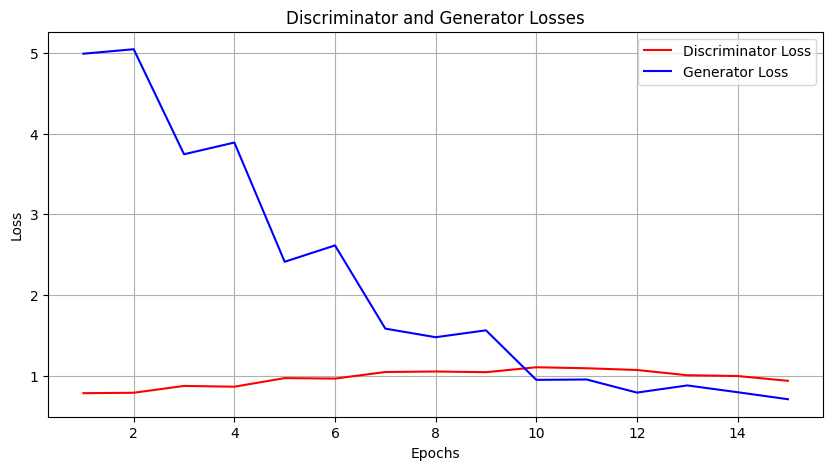

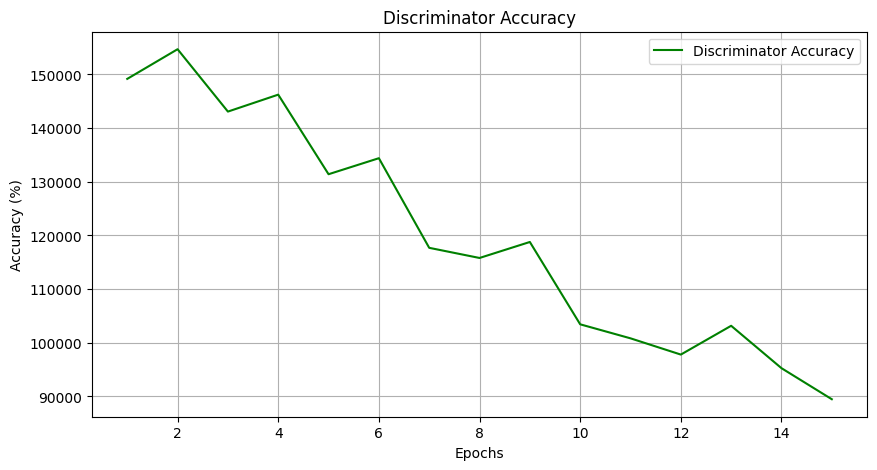

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU
generator = generator.to(device)
discriminator = discriminator.to(device)

# Optimizers and criterion
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Initialize lists to store losses and accuracies
d_losses = []
g_losses = []
d_accuracies = []

early_stopping_patience = 5  # Number of epochs to wait for improvement
best_g_loss = float('inf')
patience_counter = 0

# L1 or L2 Regularization
l2_lambda = 0.01  # Weight for L2 regularization
l1_lambda = 0.0   # Weight for L1 regularization (set to > 0 for L1 regularization)

# Training loop
for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    correct_d_real = 0
    correct_d_fake = 0
    total_d = 0

    for i, (source, target) in enumerate(tqdm(subset_dataloader)):  # Use subset_dataloader
        source, target = source.to(device), target.to(device)

        # Concatenate the source and target images to create real input
        real_input = torch.cat((source, target), 1)
        fake_target = generator(real_input)
        fake_input = torch.cat((source, fake_target.detach()), 1)

        # Ensure real_labels and fake_labels match the batch size of the discriminator output
        batch_size = real_input.size(0)
        real_labels = torch.ones(batch_size, 1, 29, 29, device=device)    # Label smoothing for real
        fake_labels = torch.zeros(batch_size, 1, 29, 29, device=device)  # Fake labels

        # Train the Discriminator 2 times before Generator
        for _ in range(2):
            optimizer_d.zero_grad()
            real_output = discriminator(real_input)
            fake_output = discriminator(fake_input)

            d_loss_real = criterion(real_output, real_labels)
            d_loss_fake = criterion(fake_output, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Add L2 Regularization
            l2_reg = sum(param.norm(2) for param in discriminator.parameters())
            d_loss += l2_lambda * l2_reg

            d_loss.backward()
            optimizer_d.step()

            # Track discriminator accuracy
            correct_d_real += (real_output > 0.5).sum().item()  # Correct real predictions
            correct_d_fake += (fake_output < 0.5).sum().item()  # Correct fake predictions
            total_d += real_output.size(0)

        # Train the Generator once
        optimizer_g.zero_grad()
        fake_input = torch.cat((source, fake_target), 1)  # Regenerate fake_input
        fake_output = discriminator(fake_input)

        # Generator loss = adversarial loss + feature matching loss
        g_adv_loss = criterion(fake_output, real_labels)
        g_fm_loss = feature_matching_loss(discriminator, real_input, fake_input)
        g_loss = g_adv_loss + 0.1 * g_fm_loss

        # Add L1 Regularization
        if l1_lambda > 0:
            l1_reg = sum(param.abs().sum() for param in generator.parameters())
            g_loss += l1_lambda * l1_reg

        g_loss.backward()
        optimizer_g.step()

        # Track losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

        # Print losses
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(subset_dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Compute discriminator accuracy
    d_accuracy = (correct_d_real + correct_d_fake) / total_d * 100
    d_accuracies.append(d_accuracy)

    # Save generated images for visualization
    vutils.save_image(fake_target, f"output_epoch_{epoch+1}.png", normalize=True)
    vutils.save_image(source, f"source_epoch_{epoch+1}.png", normalize=True)

    # Save losses for plotting
    d_losses.append(epoch_d_loss / len(subset_dataloader))
    g_losses.append(epoch_g_loss / len(subset_dataloader))

    # Early stopping check
    avg_g_loss = epoch_g_loss / len(subset_dataloader)
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        patience_counter = 0
        print(f"Generator Loss improved to {best_g_loss:.4f}.")
    else:
        patience_counter += 1
        print(f"No improvement in Generator Loss for {patience_counter} epoch(s).")

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered. Training halted.")
        break

# Plot the loss graph for Discriminator and Generator
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(d_losses) + 1), d_losses, label="Discriminator Loss", color='r')
plt.plot(range(1, len(g_losses) + 1), g_losses, label="Generator Loss", color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')
plt.legend()
plt.grid(True)
plt.savefig("loss_graph.png")
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(d_accuracies) + 1), d_accuracies, label="Discriminator Accuracy", color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Discriminator Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_graph.png")
plt.show()
